In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

In [3]:
bird = 'B1240'
d = 128

In [4]:
#ratings = [1,2,3]
#ratings_str = ''.join([str(x) for x in ratings])

In [5]:
#sort_path =  '/mnt/cube/srrudrar/sorted/B1596/block4/continuous/Rhythm_FPGA-100.0/'#
#
#clusters = []
#for rating in ratings:
#    x = tu.get_clusters_by_rating(sort_path, rating)
#    clusters.extend(x)
#
#n_cells = len(clusters)

In [6]:
#np.save('/mnt/cube/srrudrar/temporal_model/units_to_process_B1596.npy',clusters)

### Load dsets

In [7]:
def kozlov_averaging(spec, n_rows, n_cols):
    '''
    Average rows and columns of spectrogram according to Kozlov & Gentner 2016 
    In Andrei's paper he averaged twice along rows(frequency bins) and three times
    across columns (time bins).

    n_rows specifies how many times to average rows pairwise, and n_cols specifies how many times
    to average columsn pairwise.
    '''
    spec_c = np.copy(spec)

    for idx in range(n_rows):
        spec_c = MNE.avg_pairwise(spec_c, axis=0)

    for idx in range(n_cols):
        spec_c = MNE.avg_pairwise(spec_c, axis=1)

    return spec_c

In [8]:
stim_spec1 = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/spec_test_{}.npy'.format(bird,d,d)) ###change
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}.npy'.format(bird,d,d))###change

In [9]:
stim_spec1 = stim_spec1.reshape((np.shape(stim_spec1)[0],32,32))

In [10]:
np.shape(stim_spec1), np.shape(stim_resp)

((5706, 32, 32), (5706, 214, 32))

In [11]:
stim_spec = [kozlov_averaging(s,1,2).reshape((d,)) for s in stim_spec1]

In [12]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 128), (5706, 214, 32))

In [13]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [14]:
nsegbins = 32

In [15]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [16]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 128), (5706, 214))

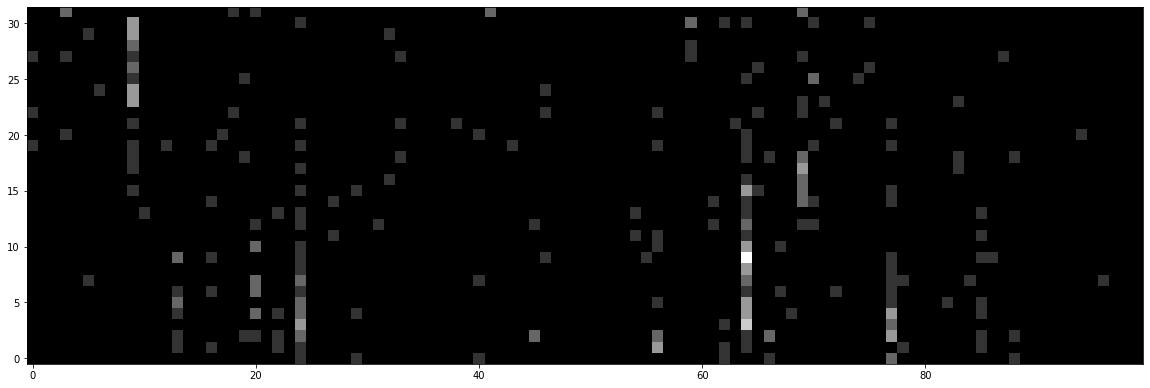

In [17]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [18]:
len_units = np.shape(resp_mne)[1]

In [19]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process_{}.npy'.format(bird)))        ###change

In [20]:
exp_path = '/mnt/cube/srrudrar/raw_spec/{}/32x32/stim_resp_32x32_{}/test_set_mne1/'.format(bird,d)           ###change

In [21]:
# obtain all preprocessed datas

%matplotlib inline
sdim = d                                                                                                          ###change                                                                
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.155366
    2       0    0.154716
    3       0    0.152168
    4       0    0.151477
    5       0    0.150422
    6       0    0.150004
    7       0    0.148498
    8       0    0.146310
    9       0    0.146259
   10       0    0.147217
   11       1    0.147447
   12       2    0.146437
   13       3    0.146671
   14       4    0.145254
   15       0    0.145244
   16       0    0.145531
   17       1    0.145449
   18       2    0.146584
   19       3    0.146938
   20       4    0.148598
   21       5    0.148545
   22       6    0.147910
   23       7    0.145739
   24       8    0.145853
   25       9    0.144473
   26       0    0.144908
   27       1    0.144469
   28       0    0.143526
   29       0    0.143645
   30       1    0.143825
   31       2    0.143414
   32       0    0.143507
   33       1    0.142956
   34       0    0.143064
   35       1    0.143465
   36       2    0.143659
   37       3    0.143047
   38       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.151349
    2       0    0.149171
    3       0    0.146309
    4       0    0.146812
    5       1    0.147312
    6       2    0.144757
    7       0    0.144206
    8       0    0.143425
    9       0    0.142573
   10       0    0.142095
   11       0    0.141074
   12       0    0.141946
   13       1    0.140687
   14       0    0.139114
   15       0    0.140740
   16       1    0.140878
   17       2    0.138295
   18       0    0.138371
   19       1    0.137562
   20       0    0.137989
   21       1    0.138574
   22       2    0.137987
   23       3    0.137677
   24       4    0.137073
   25       0    0.138038
   26       1    0.138456
   27       2    0.137345
   28       3    0.137522
   29       4    0.137607
   30       5    0.136871
   31       0    0.137433
   32       1    0.136415
   33       0    0.136140
   34       0    0.134883
   35       0    0.134950
   36       1    0.134855
   37       0    0.135396
   38       1    0.136031
   39       

   27       0    0.113885
   28       1    0.114085
   29       2    0.113383
   30       0    0.113126
   31       0    0.113096
   32       0    0.112971
   33       0    0.112729
   34       0    0.112739
   35       1    0.112783
   36       2    0.112838
   37       3    0.112960
   38       4    0.112630
   39       0    0.112637
   40       1    0.112862
   41       2    0.112785
   42       3    0.112329
   43       0    0.112486
   44       1    0.112450
   45       2    0.112544
   46       3    0.112511
   47       4    0.113317
   48       5    0.112978
   49       6    0.112779
   50       7    0.112566
   51       8    0.112756
   52       9    0.112945
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.102091
    2       0    0.101582
    3       0    0.100565
    4       0    0.100914
    5       1    0.101279
    6       2    0.100153
    7       0    0.099258
    8       0    0.099081
    9       0    0.098806
   10       0    0.098658
   11       

   40       1    0.089820
   41       2    0.089572
   42       0    0.089475
   43       0    0.089456
   44       0    0.089393
   45       0    0.089367
   46       0    0.089418
   47       1    0.089359
   48       0    0.089379
   49       1    0.089299
   50       0    0.089294
   51       0    0.089174
   52       0    0.089245
   53       1    0.089310
   54       2    0.089129
   55       0    0.089177
   56       1    0.089033
   57       0    0.089074
   58       1    0.089007
   59       0    0.088974
   60       0    0.088992
   61       1    0.089003
   62       2    0.088954
   63       0    0.088968
   64       1    0.088925
   65       0    0.088996
   66       1    0.088911
   67       0    0.088983
   68       1    0.088894
   69       0    0.088744
   70       0    0.088775
   71       1    0.088793
   72       2    0.088696
   73       0    0.088715
   74       1    0.088749
   75       2    0.088734
   76       3    0.088698
   77       4    0.088720
   78       

   35       7    0.184226
   36       0    0.183938
   37       0    0.183809
   38       0    0.183610
   39       0    0.183711
   40       1    0.183780
   41       2    0.184023
   42       3    0.183791
   43       4    0.183736
   44       5    0.183796
   45       6    0.183698
   46       7    0.183538
   47       0    0.183458
   48       0    0.183390
   49       0    0.183258
   50       0    0.183169
   51       0    0.182874
   52       0    0.182911
   53       1    0.183047
   54       2    0.183149
   55       3    0.183129
   56       4    0.182960
   57       5    0.182839
   58       0    0.182664
   59       0    0.182687
   60       1    0.182795
   61       2    0.182824
   62       3    0.182803
   63       4    0.182939
   64       5    0.183014
   65       6    0.182939
   66       7    0.183435
   67       8    0.183915
   68       9    0.184429
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.065206
    2       0    0.063344
    3       

    6       0    0.105820
    7       0    0.104946
    8       0    0.103157
    9       0    0.103482
   10       1    0.103286
   11       2    0.103580
   12       3    0.103164
   13       4    0.103046
   14       0    0.102758
   15       0    0.102338
   16       0    0.102177
   17       0    0.101878
   18       0    0.102310
   19       1    0.102461
   20       2    0.101899
   21       3    0.101728
   22       0    0.101578
   23       0    0.101447
   24       0    0.101296
   25       0    0.101357
   26       1    0.100805
   27       0    0.101637
   28       1    0.101860
   29       2    0.101379
   30       3    0.101365
   31       4    0.101241
   32       5    0.100820
   33       6    0.100792
   34       0    0.100677
   35       0    0.100657
   36       0    0.100792
   37       1    0.100886
   38       2    0.101022
   39       3    0.101164
   40       4    0.101097
   41       5    0.101039
   42       6    0.100938
   43       7    0.100607
   44       

    4       0    0.131192
    5       0    0.128714
    6       0    0.127451
    7       0    0.127410
    8       0    0.127041
    9       0    0.126655
   10       0    0.125811
   11       0    0.124977
   12       0    0.124893
   13       0    0.125001
   14       1    0.124310
   15       0    0.123588
   16       0    0.123077
   17       0    0.122512
   18       0    0.122023
   19       0    0.122175
   20       1    0.121319
   21       0    0.121407
   22       1    0.121493
   23       2    0.120927
   24       0    0.120793
   25       0    0.120899
   26       1    0.120873
   27       2    0.120357
   28       0    0.120251
   29       0    0.120148
   30       0    0.120150
   31       1    0.120221
   32       2    0.120142
   33       0    0.119716
   34       0    0.119677
   35       0    0.119104
   36       0    0.118999
   37       0    0.118866
   38       0    0.118842
   39       0    0.118856
   40       1    0.119017
   41       2    0.119079
   42       

   27       2    0.149082
   28       0    0.149191
   29       1    0.149429
   30       2    0.150750
   31       3    0.150466
   32       4    0.148924
   33       0    0.148772
   34       0    0.148861
   35       1    0.148679
   36       0    0.148866
   37       1    0.148798
   38       2    0.148329
   39       0    0.148209
   40       0    0.148430
   41       1    0.148362
   42       2    0.148475
   43       3    0.148456
   44       4    0.148145
   45       0    0.148045
   46       0    0.148219
   47       1    0.148040
   48       0    0.148186
   49       1    0.148313
   50       2    0.148133
   51       3    0.148492
   52       4    0.148280
   53       5    0.148213
   54       6    0.149284
   55       7    0.149438
   56       8    0.149093
   57       9    0.149099
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.162207
    2       0    0.160949
    3       0    0.161261
    4       1    0.158168
    5       0    0.157865
    6       

    1       0    0.288739
    2       0    0.286648
    3       0    0.286926
    4       1    0.285340
    5       0    0.283877
    6       0    0.283287
    7       0    0.281410
    8       0    0.280655
    9       0    0.279451
   10       0    0.278947
   11       0    0.278133
   12       0    0.276818
   13       0    0.275331
   14       0    0.274654
   15       0    0.274689
   16       1    0.273926
   17       0    0.272878
   18       0    0.272247
   19       0    0.272253
   20       1    0.271870
   21       0    0.271846
   22       0    0.271722
   23       0    0.271811
   24       1    0.271233
   25       0    0.271138
   26       0    0.270526
   27       0    0.270952
   28       1    0.270996
   29       2    0.269733
   30       0    0.269597
   31       0    0.269107
   32       0    0.269001
   33       0    0.268980
   34       0    0.268709
   35       0    0.268526
   36       0    0.267941
   37       0    0.267401
   38       0    0.267364
   39       

    9       0    0.041727
   10       0    0.041338
   11       0    0.040718
   12       0    0.040585
   13       0    0.040724
   14       1    0.040705
   15       2    0.040665
   16       3    0.040782
   17       4    0.040860
   18       5    0.040704
   19       6    0.040893
   20       7    0.040892
   21       8    0.040540
   22       0    0.040455
   23       0    0.040377
   24       0    0.040565
   25       1    0.040495
   26       2    0.040393
   27       3    0.040409
   28       4    0.040454
   29       5    0.040422
   30       6    0.040481
   31       7    0.040589
   32       8    0.040528
   33       9    0.040472
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.165457
    2       0    0.164903
    3       0    0.164449
    4       0    0.164407
    5       0    0.163984
    6       0    0.163146
    7       0    0.162352
    8       0    0.161950
    9       0    0.161815
   10       0    0.161679
   11       0    0.161453
   12       0    0.161539
   13       1    0.161062
   14       0    0.160944
   15       0    0.160513
   16       0    0.160554
   17       1    0.160177
   18       0    0.159602
   19       0    0.159288
   20       0    0.159349
   21       1    0.159422
   22       2    0.159272
   23       0    0.159120
   24       0    0.159178
   25       1    0.159010
   26       0    0.159006
   27       0    0.159103
   28       1    0.158973
   29       0    0.158909
   30       0    0.159111
   31       1    0.159081
   32       2    0.158776
   33       0    0.158718
   34       0    0.158733
   35       1    0.158668
   36       0    0.158564
   37       0    0.158461
   38       0    0.158616
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.174884
    2       0    0.173425
    3       0    0.173010
    4       0    0.172844
    5       0    0.172753
    6       0    0.172665
    7       0    0.172085
    8       0    0.171162
    9       0    0.170846
   10       0    0.170413
   11       0    0.170401
   12       0    0.170448
   13       1    0.170015
   14       0    0.169899
   15       0    0.169772
   16       0    0.169580
   17       0    0.169580
   18       1    0.169420
   19       0    0.169462
   20       1    0.169453
   21       2    0.169372
   22       0    0.168711
   23       0    0.168770
   24       1    0.168777
   25       2    0.168673
   26       0    0.168580
   27       0    0.168723
   28       1    0.168866
   29       2    0.168715
   30       3    0.168746
   31       4    0.168535
   32       0    0.168464
   33       0    0.168391
   34       0    0.168215
   35       0    0.168123
   36       0    0.168109
   37       0    0.168180
   38       1    0.168171
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.169672
    2       0    0.167778
    3       0    0.167162
    4       0    0.166307
    5       0    0.165062
    6       0    0.164691
    7       0    0.164295
    8       0    0.163883
    9       0    0.163454
   10       0    0.163343
   11       0    0.163180
   12       0    0.163048
   13       0    0.162761
   14       0    0.162324
   15       0    0.162240
   16       0    0.161882
   17       0    0.161715
   18       0    0.161543
   19       0    0.161320
   20       0    0.161242
   21       0    0.161180
   22       0    0.161154
   23       0    0.161120
   24       0    0.161144
   25       1    0.161136
   26       2    0.161084
   27       0    0.160990
   28       0    0.161120
   29       1    0.161089
   30       2    0.160891
   31       0    0.160571
   32       0    0.160252
   33       0    0.160270
   34       1    0.160139
   35       0    0.160041
   36       0    0.159909
   37       0    0.160002
   38       1    0.159893
   39       

    9       1    0.614461
   10       0    0.613267
   11       0    0.612370
   12       0    0.612512
   13       1    0.611446
   14       0    0.611810
   15       1    0.611723
   16       2    0.612073
   17       3    0.611360
   18       0    0.611303
   19       0    0.609819
   20       0    0.609880
   21       1    0.610222
   22       2    0.609598
   23       0    0.609003
   24       0    0.609217
   25       1    0.609193
   26       2    0.608919
   27       0    0.609393
   28       1    0.609107
   29       2    0.609227
   30       3    0.608896
   31       0    0.608427
   32       0    0.609160
   33       1    0.609241
   34       2    0.608114
   35       0    0.608036
   36       0    0.608460
   37       1    0.608174
   38       2    0.607950
   39       0    0.607561
   40       0    0.607753
   41       1    0.607952
   42       2    0.607821
   43       3    0.607845
   44       4    0.608132
   45       5    0.608022
   46       6    0.608220
   47       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.624093
    2       0    0.622381
    3       0    0.619653
    4       0    0.619633
    5       0    0.616631
    6       0    0.615019
    7       0    0.614182
    8       0    0.613308
    9       0    0.612782
   10       0    0.611794
   11       0    0.611483
   12       0    0.611291
   13       0    0.611041
   14       0    0.610425
   15       0    0.610140
   16       0    0.608656
   17       0    0.607998
   18       0    0.607293
   19       0    0.607164
   20       0    0.606558
   21       0    0.605862
   22       0    0.605577
   23       0    0.605043
   24       0    0.604464
   25       0    0.603710
   26       0    0.603835
   27       1    0.603810
   28       2    0.603489
   29       0    0.603108
   30       0    0.603289
   31       1    0.603190
   32       2    0.602838
   33       0    0.602518
   34       0    0.602331
   35       0    0.602430
   36       1    0.602386
   37       2    0.602061
   38       0    0.601977
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.628364
    2       0    0.626122
    3       0    0.622588
    4       0    0.621834
    5       0    0.619095
    6       0    0.618369
    7       0    0.617984
    8       0    0.619060
    9       1    0.617967
   10       0    0.617341
   11       0    0.614366
   12       0    0.613817
   13       0    0.612921
   14       0    0.612109
   15       0    0.611723
   16       0    0.611056
   17       0    0.610712
   18       0    0.610416
   19       0    0.609832
   20       0    0.609669
   21       0    0.609226
   22       0    0.609331
   23       1    0.609485
   24       2    0.609867
   25       3    0.610339
   26       4    0.610864
   27       5    0.610354
   28       6    0.610465
   29       7    0.610695
   30       8    0.609949
   31       9    0.609170
   32       0    0.608892
   33       0    0.608336
   34       0    0.608203
   35       0    0.608106
   36       0    0.607685
   37       0    0.607298
   38       0    0.606684
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.624293
    2       0    0.622015
    3       0    0.621378
    4       0    0.620745
    5       0    0.616870
    6       0    0.616067
    7       0    0.615657
    8       0    0.612390
    9       0    0.612142
   10       0    0.612138
   11       0    0.609430
   12       0    0.609152
   13       0    0.609386
   14       1    0.609495
   15       2    0.609491
   16       3    0.609079
   17       0    0.608210
   18       0    0.608316
   19       1    0.607776
   20       0    0.607718
   21       0    0.607582
   22       0    0.607745
   23       1    0.607361
   24       0    0.606645
   25       0    0.606182
   26       0    0.606058
   27       0    0.605828
   28       0    0.606136
   29       1    0.606193
   30       2    0.606479
   31       3    0.606550
   32       4    0.606293
   33       5    0.606486
   34       6    0.606257
   35       7    0.605819
   36       0    0.605620
   37       0    0.605567
   38       0    0.604981
   39       

   45       1    0.132915
   46       2    0.133451
   47       3    0.133153
   48       4    0.132989
   49       5    0.132820
   50       6    0.132718
   51       7    0.132713
   52       8    0.132668
   53       9    0.132527
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.304853
    2       0    0.303356
    3       0    0.302108
    4       0    0.302220
    5       1    0.302171
    6       2    0.301926
    7       0    0.300791
    8       0    0.299466
    9       0    0.297949
   10       0    0.297609
   11       0    0.297810
   12       1    0.295959
   13       0    0.295727
   14       0    0.295907
   15       1    0.297286
   16       2    0.296153
   17       3    0.295989
   18       4    0.294193
   19       0    0.294300
   20       1    0.295375
   21       2    0.296276
   22       3    0.295705
   23       4    0.295116
   24       5    0.294946
   25       6    0.296483
   26       7    0.296495
   27       8    0.296477
   28       9    0.295230
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.310089
    2       0    0.309687
    3       0    0.309271
    4       0    0.309031
    5       0    0.309942
    6       1    0.309273
    7       2    0.307844
    8       0    0.306403
    9       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.311293
    2       0    0.310910
    3       0    0.309802
    4       0    0.308744
    5       0    0.308298
    6       0    0.307289
    7       0    0.306475
    8       0    0.306244
    9       0    0.305901
   10       0    0.304963
   11       0    0.304944
   12       0    0.305048
   13       1    0.304129
   14       0    0.303276
   15       0    0.303827
   16       1    0.303158
   17       0    0.303103
   18       0    0.301660
   19       0    0.302765
   20       1    0.303118
   21       2    0.302345
   22       3    0.301753
   23       4    0.301016
   24       0    0.301617
   25       1    0.301531
   26       2    0.301044
   27       3    0.301361
   28       4    0.301441
   29       5    0.300934
   30       0    0.301521
   31       1    0.301101
   32       2    0.301861
   33       3    0.301676
   34       4    0.302482
   35       5    0.303024
   36       6    0.302432
   37       7    0.302631
   38       8    0.302700
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.308447
    2       0    0.307261
    3       0    0.306368
    4       0    0.305844
    5       0    0.304719
    6       0    0.304070
    7       0    0.303495
    8       0    0.302843
    9       0    0.302912
   10       1    0.302307
   11       0    0.301852
   12       0    0.301286
   13       0    0.301123
   14       0    0.301060
   15       0    0.300908
   16       0    0.301153
   17       1    0.301705
   18       2    0.301329
   19       3    0.302195
   20       4    0.302060
   21       5    0.300329
   22       0    0.300124
   23       0    0.300430
   24       1    0.300386
   25       2    0.300170
   26       3    0.300160
   27       4    0.299942
   28       0    0.299159
   29       0    0.299550
   30       1    0.299532
   31       2    0.299746
   32       3    0.299649
   33       4    0.299015
   34       0    0.299428
   35       1    0.299382
   36       2    0.299315
   37       3    0.299503
   38       4    0.299165
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.450069
    2       0    0.447754
    3       0    0.446498
    4       0    0.444916
    5       0    0.443577
    6       0    0.442695
    7       0    0.442915
    8       1    0.441999
    9       0    0.442083
   10       1    0.441620
   11       0    0.441198
   12       0    0.440945
   13       0    0.440271
   14       0    0.439658
   15       0    0.438769
   16       0    0.438484
   17       0    0.437912
   18       0    0.437033
   19       0    0.436833
   20       0    0.436501
   21       0    0.436100
   22       0    0.435699
   23       0    0.435370
   24       0    0.435109
   25       0    0.435118
   26       1    0.435237
   27       2    0.435097
   28       0    0.434927
   29       0    0.434988
   30       1    0.435238
   31       2    0.435627
   32       3    0.436095
   33       4    0.435741
   34       5    0.435451
   35       6    0.434735
   36       0    0.434529
   37       0    0.434409
   38       0    0.434056
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.242076
    2       0    0.240172
    3       0    0.239955
    4       0    0.237867
    5       0    0.237175
    6       0    0.236120
    7       0    0.235230
    8       0    0.235027
    9       0    0.234800
   10       0    0.233239
   11       0    0.232730
   12       0    0.232064
   13       0    0.231936
   14       0    0.231696
   15       0    0.231528
   16       0    0.231327
   17       0    0.230789
   18       0    0.230466
   19       0    0.230310
   20       0    0.230004
   21       0    0.228898
   22       0    0.228584
   23       0    0.228488
   24       0    0.228437
   25       0    0.227996
   26       0    0.227956
   27       0    0.227867
   28       0    0.227913
   29       1    0.228062
   30       2    0.228067
   31       3    0.227981
   32       4    0.227769
   33       0    0.227673
   34       0    0.227384
   35       0    0.227216
   36       0    0.227223
   37       1    0.227141
   38       0    0.227143
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.257674
    2       0    0.254171
    3       0    0.252438
    4       0    0.250712
    5       0    0.249922
    6       0    0.249810
    7       0    0.249359
    8       0    0.248387
    9       0    0.246439
   10       0    0.246135
   11       0    0.245831
   12       0    0.245680
   13       0    0.245617
   14       0    0.245734
   15       1    0.245967
   16       2    0.245852
   17       3    0.245034
   18       0    0.244635
   19       0    0.244110
   20       0    0.243542
   21       0    0.243702
   22       1    0.243475
   23       0    0.243347
   24       0    0.242958
   25       0    0.242732
   26       0    0.242723
   27       0    0.242320
   28       0    0.242375
   29       1    0.241490
   30       0    0.241040
   31       0    0.241116
   32       1    0.240284
   33       0    0.240050
   34       0    0.240549
   35       1    0.240585
   36       2    0.240278
   37       3    0.240103
   38       4    0.240090
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.243955
    2       0    0.240843
    3       0    0.239320
    4       0    0.238774
    5       0    0.237382
    6       0    0.237424
    7       1    0.234521
    8       0    0.232764
    9       0    0.232448
   10       0    0.230749
   11       0    0.230530
   12       0    0.229820
   13       0    0.229942
   14       1    0.229552
   15       0    0.229080
   16       0    0.228711
   17       0    0.228798
   18       1    0.228073
   19       0    0.227941
   20       0    0.227606
   21       0    0.227770
   22       1    0.227907
   23       2    0.227544
   24       0    0.227486
   25       0    0.227550
   26       1    0.227447
   27       0    0.227315
   28       0    0.227401
   29       1    0.227574
   30       2    0.227436
   31       3    0.227121
   32       0    0.227306
   33       1    0.227312
   34       2    0.227016
   35       0    0.226914
   36       0    0.226990
   37       1    0.226814
   38       0    0.226588
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.246911
    2       0    0.247096
    3       0    0.247088
    4       0    0.243805
    5       0    0.241704
    6       0    0.242427
    7       1    0.242379
    8       2    0.239532
    9       0    0.238981
   10       0    0.238912
   11       0    0.239412
   12       1    0.238904
   13       0    0.239004
   14       1    0.239480
   15       2    0.238386
   16       0    0.236735
   17       0    0.238137
   18       1    0.237432
   19       2    0.236170
   20       0    0.237016
   21       1    0.236737
   22       2    0.235509
   23       0    0.235062
   24       0    0.235229
   25       1    0.234941
   26       0    0.235260
   27       1    0.234497
   28       0    0.234682
   29       1    0.234562
   30       2    0.233884
   31       0    0.234258
   32       1    0.234213
   33       2    0.233600
   34       0    0.233720
   35       1    0.233577
   36       0    0.233286
   37       0    0.233669
   38       1    0.233760
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.124245
    2       0    0.123829
    3       0    0.123211
    4       0    0.123363
    5       1    0.123796
    6       2    0.122968
    7       0    0.122588
    8       0    0.122617
    9       1    0.122545
   10       0    0.121903
   11       0    0.121967
   12       1    0.121860
   13       0    0.122049
   14       1    0.121687
   15       0    0.122033
   16       1    0.121541
   17       0    0.122233
   18       1    0.122321
   19       2    0.121895
   20       3    0.121878
   21       4    0.121594
   22       5    0.121715
   23       6    0.121933
   24       7    0.121653
   25       8    0.121601
   26       9    0.121280
   27       0    0.121360
   28       1    0.121201
   29       0    0.121409
   30       1    0.120979
   31       0    0.120467
   32       0    0.120569
   33       1    0.120837
   34       2    0.120718
   35       3    0.120779
   36       4    0.120985
   37       5    0.120952
   38       6    0.120822
   39       

   50       4    0.092520
   51       5    0.092490
   52       6    0.092525
   53       7    0.092741
   54       8    0.092757
   55       9    0.092773
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.107498
    2       0    0.105253
    3       0    0.103909
    4       0    0.103348
    5       0    0.102999
    6       0    0.103415
    7       1    0.102098
    8       0    0.101150
    9       0    0.101171
   10       1    0.101053
   11       0    0.101037
   12       0    0.101853
   13       1    0.102539
   14       2    0.102905
   15       3    0.102863
   16       4    0.101689
   17       5    0.100973
   18       0    0.100613
   19       0    0.099579
   20       0    0.099595
   21       1    0.099610
   22       2    0.099837
   23       3    0.099349
   24       0    0.098910
   25       0    0.098400
   26       0    0.098341
   27       0    0.098230
   28       0    0.098333
   29       1    0.098232
   30       2    0.097663
   31       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.582513
    2       0    0.583507
    3       0    0.580311
    4       0    0.580547
    5       1    0.577321
    6       0    0.574376
    7       0    0.573463
    8       0    0.572195
    9       0    0.570620
   10       0    0.569568
   11       0    0.568098
   12       0    0.567318
   13       0    0.566770
   14       0    0.566137
   15       0    0.564159
   16       0    0.563873
   17       0    0.563338
   18       0    0.563541
   19       1    0.562490
   20       0    0.562557
   21       1    0.561742
   22       0    0.561307
   23       0    0.560865
   24       0    0.560139
   25       0    0.560198
   26       1    0.560087
   27       0    0.559931
   28       0    0.560011
   29       1    0.559840
   30       0    0.559623
   31       0    0.559353
   32       0    0.559422
   33       1    0.559199
   34       0    0.558778
   35       0    0.558796
   36       1    0.558789
   37       2    0.558550
   38       0    0.558081
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.600013
    2       0    0.597260
    3       0    0.593310
    4       0    0.591560
    5       0    0.588888
    6       0    0.587710
    7       0    0.588024
    8       1    0.586355
    9       0    0.584907
   10       0    0.585730
   11       1    0.586002
   12       2    0.584410
   13       0    0.583832
   14       0    0.581506
   15       0    0.581415
   16       0    0.580222
   17       0    0.581143
   18       1    0.581142
   19       2    0.580869
   20       3    0.579882
   21       0    0.579415
   22       0    0.578945
   23       0    0.579654
   24       1    0.579413
   25       2    0.579822
   26       3    0.579380
   27       4    0.578962
   28       5    0.578422
   29       0    0.577748
   30       0    0.576425
   31       0    0.576657
   32       1    0.576547
   33       2    0.577196
   34       3    0.576923
   35       4    0.577692
   36       5    0.577232
   37       6    0.576945
   38       7    0.576253
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.603039
    2       0    0.594785
    3       0    0.592128
    4       0    0.591053
    5       0    0.588251
    6       0    0.587787
    7       0    0.587110
    8       0    0.585538
    9       0    0.584846
   10       0    0.584214
   11       0    0.585011
   12       1    0.585121
   13       2    0.584260
   14       3    0.582933
   15       0    0.581959
   16       0    0.581413
   17       0    0.579939
   18       0    0.579616
   19       0    0.579404
   20       0    0.578866
   21       0    0.578804
   22       0    0.578286
   23       0    0.578449
   24       1    0.578107
   25       0    0.577602
   26       0    0.577565
   27       0    0.577304
   28       0    0.577117
   29       0    0.576662
   30       0    0.576401
   31       0    0.576404
   32       1    0.576297
   33       0    0.576112
   34       0    0.575657
   35       0    0.575469
   36       0    0.575511
   37       1    0.575589
   38       2    0.575972
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.585017
    2       0    0.579720
    3       0    0.577800
    4       0    0.577316
    5       0    0.573171
    6       0    0.570633
    7       0    0.568618
    8       0    0.568355
    9       0    0.568159
   10       0    0.567067
   11       0    0.566449
   12       0    0.565833
   13       0    0.565931
   14       1    0.565753
   15       0    0.564971
   16       0    0.564578
   17       0    0.564418
   18       0    0.564192
   19       0    0.564185
   20       0    0.564044
   21       0    0.563867
   22       0    0.562989
   23       0    0.562584
   24       0    0.562362
   25       0    0.562152
   26       0    0.561839
   27       0    0.561731
   28       0    0.561448
   29       0    0.561567
   30       1    0.561559
   31       2    0.561961
   32       3    0.561094
   33       0    0.560921
   34       0    0.560892
   35       0    0.560833
   36       0    0.560620
   37       0    0.560569
   38       0    0.560458
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.147074
    2       0    0.146372
    3       0    0.143351
    4       0    0.141743
    5       0    0.141880
    6       1    0.141821
    7       2    0.140116
    8       0    0.139599
    9       0    0.139764
   10       1    0.139258
   11       0    0.138816
   12       0    0.138874
   13       1    0.139105
   14       2    0.138049
   15       0    0.137910
   16       0    0.138143
   17       1    0.138751
   18       2    0.138696
   19       3    0.139105
   20       4    0.139131
   21       5    0.138189
   22       6    0.137974
   23       7    0.137101
   24       0    0.136868
   25       0    0.136614
   26       0    0.136592
   27       0    0.136576
   28       0    0.136735
   29       1    0.136595
   30       2    0.136292
   31       0    0.136182
   32       0    0.136157
   33       0    0.136175
   34       1    0.136057
   35       0    0.136107
   36       1    0.135868
   37       0    0.135629
   38       0    0.135508
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.162630
    2       0    0.160589
    3       0    0.156683
    4       0    0.155542
    5       0    0.155222
    6       0    0.153778
    7       0    0.152213
    8       0    0.152212
    9       0    0.151621
   10       0    0.151411
   11       0    0.151307
   12       0    0.150888
   13       0    0.150654
   14       0    0.149898
   15       0    0.149801
   16       0    0.149798
   17       0    0.149821
   18       1    0.150248
   19       2    0.150812
   20       3    0.150996
   21       4    0.150267
   22       5    0.149835
   23       6    0.150096
   24       7    0.149363
   25       0    0.149031
   26       0    0.149206
   27       1    0.149434
   28       2    0.149158
   29       3    0.149356
   30       4    0.149099
   31       5    0.150302
   32       6    0.151148
   33       7    0.151331
   34       8    0.151000
   35       9    0.150688
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.149035
    2       0    0.149358
    3       0    0.147098
    4       0    0.145635
    5       0    0.143816
    6       0    0.144640
    7       1    0.144822
    8       2    0.142367
    9       0    0.141864
   10       0    0.142564
   11       1    0.143092
   12       2    0.141583
   13       0    0.141040
   14       0    0.141015
   15       0    0.141257
   16       1    0.141690
   17       2    0.141431
   18       3    0.141171
   19       4    0.140715
   20       0    0.140525
   21       0    0.140895
   22       1    0.141264
   23       2    0.140572
   24       3    0.140007
   25       0    0.139980
   26       0    0.140045
   27       1    0.139544
   28       0    0.139216
   29       0    0.139339
   30       1    0.139355
   31       2    0.139709
   32       3    0.139424
   33       4    0.139295
   34       5    0.138908
   35       0    0.138933
   36       1    0.139005
   37       2    0.138824
   38       0    0.138767
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.163377
    2       0    0.160158
    3       0    0.156535
    4       0    0.155654
    5       0    0.155578
    6       0    0.154731
    7       0    0.152234
    8       0    0.151831
    9       0    0.151809
   10       0    0.151869
   11       1    0.152821
   12       2    0.152406
   13       3    0.152397
   14       4    0.151605
   15       0    0.150371
   16       0    0.149842
   17       0    0.149272
   18       0    0.149029
   19       0    0.148458
   20       0    0.148309
   21       0    0.148248
   22       0    0.148156
   23       0    0.147662
   24       0    0.147438
   25       0    0.147480
   26       1    0.147464
   27       2    0.147403
   28       0    0.147253
   29       0    0.146844
   30       0    0.146292
   31       0    0.145793
   32       0    0.145707
   33       0    0.145982
   34       1    0.145971
   35       2    0.145717
   36       3    0.145917
   37       4    0.145968
   38       5    0.145984
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.328600
    2       0    0.328679
    3       0    0.320370
    4       0    0.316982
    5       0    0.313534
    6       0    0.314103
    7       1    0.312484
    8       0    0.309730
    9       0    0.308020
   10       0    0.306119
   11       0    0.306105
   12       0    0.304938
   13       0    0.305648
   14       1    0.304294
   15       0    0.301514
   16       0    0.301637
   17       1    0.301204
   18       0    0.300604
   19       0    0.300804
   20       1    0.300489
   21       0    0.299525
   22       0    0.299301
   23       0    0.299371
   24       1    0.298572
   25       0    0.298934
   26       1    0.298936
   27       2    0.300096
   28       3    0.298835
   29       4    0.298880
   30       5    0.297793
   31       0    0.297401
   32       0    0.297556
   33       1    0.297361
   34       0    0.297302
   35       0    0.297022
   36       0    0.297057
   37       1    0.297214
   38       2    0.296975
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.303937
    2       0    0.301241
    3       0    0.300624
    4       0    0.298335
    5       0    0.296418
    6       0    0.294399
    7       0    0.293173
    8       0    0.291413
    9       0    0.290280
   10       0    0.289465
   11       0    0.289414
   12       0    0.288900
   13       0    0.288196
   14       0    0.288114
   15       0    0.288244
   16       1    0.286471
   17       0    0.285345
   18       0    0.285380
   19       1    0.285023
   20       0    0.283375
   21       0    0.282997
   22       0    0.283159
   23       1    0.282932
   24       0    0.282244
   25       0    0.282602
   26       1    0.282709
   27       2    0.282255
   28       3    0.282193
   29       0    0.281915
   30       0    0.281917
   31       1    0.281938
   32       2    0.282219
   33       3    0.281996
   34       4    0.281325
   35       0    0.281184
   36       0    0.281625
   37       1    0.281654
   38       2    0.281484
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.305974
    2       0    0.302368
    3       0    0.298766
    4       0    0.297660
    5       0    0.295716
    6       0    0.293745
    7       0    0.290582
    8       0    0.290446
    9       0    0.291035
   10       1    0.291198
   11       2    0.292102
   12       3    0.291125
   13       4    0.290229
   14       0    0.288317
   15       0    0.287408
   16       0    0.286349
   17       0    0.285827
   18       0    0.285419
   19       0    0.285449
   20       1    0.285297
   21       0    0.285383
   22       1    0.285207
   23       0    0.284760
   24       0    0.284640
   25       0    0.284601
   26       0    0.284411
   27       0    0.284218
   28       0    0.283333
   29       0    0.283285
   30       0    0.283534
   31       1    0.283779
   32       2    0.283884
   33       3    0.283699
   34       4    0.283601
   35       5    0.283557
   36       6    0.283483
   37       7    0.283474
   38       8    0.283456
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.305878
    2       0    0.304566
    3       0    0.301448
    4       0    0.299836
    5       0    0.298779
    6       0    0.298051
    7       0    0.297101
    8       0    0.295130
    9       0    0.292553
   10       0    0.292166
   11       0    0.290309
   12       0    0.290392
   13       1    0.289297
   14       0    0.288955
   15       0    0.288071
   16       0    0.287679
   17       0    0.287490
   18       0    0.287484
   19       0    0.287127
   20       0    0.286522
   21       0    0.286442
   22       0    0.286501
   23       1    0.286323
   24       0    0.286509
   25       1    0.286191
   26       0    0.285943
   27       0    0.284549
   28       0    0.284474
   29       0    0.284374
   30       0    0.284505
   31       1    0.284397
   32       2    0.284301
   33       0    0.284149
   34       0    0.283838
   35       0    0.283878
   36       1    0.283674
   37       0    0.283629
   38       0    0.283436
   39       

   39       0    0.229166
   40       0    0.229032
   41       0    0.228718
   42       0    0.227723
   43       0    0.227804
   44       1    0.227776
   45       2    0.227571
   46       0    0.227318
   47       0    0.227412
   48       1    0.227391
   49       2    0.227258
   50       0    0.227222
   51       0    0.227365
   52       1    0.227265
   53       2    0.226727
   54       0    0.226922
   55       1    0.227021
   56       2    0.226701
   57       0    0.226529
   58       0    0.226217
   59       0    0.226201
   60       0    0.226119
   61       0    0.226184
   62       1    0.226040
   63       0    0.226136
   64       1    0.226029
   65       0    0.226120
   66       1    0.226044
   67       2    0.226164
   68       3    0.226171
   69       4    0.226329
   70       5    0.226373
   71       6    0.226723
   72       7    0.227095
   73       8    0.226784
   74       9    0.226815
minimum of test set found
Iters   tally   ll(test) 
    1       

   24       2    0.413886
   25       0    0.413651
   26       0    0.413483
   27       0    0.413111
   28       0    0.412922
   29       0    0.411319
   30       0    0.410968
   31       0    0.411080
   32       1    0.411647
   33       2    0.411568
   34       3    0.411561
   35       4    0.411569
   36       5    0.411462
   37       6    0.411421
   38       7    0.411435
   39       8    0.411551
   40       9    0.411542
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.427088
    2       0    0.424281
    3       0    0.422837
    4       0    0.417533
    5       0    0.415388
    6       0    0.415919
    7       1    0.416577
    8       2    0.414754
    9       0    0.413752
   10       0    0.412600
   11       0    0.411020
   12       0    0.410718
   13       0    0.410087
   14       0    0.408076
   15       0    0.407554
   16       0    0.407614
   17       1    0.407484
   18       0    0.407301
   19       0    0.405798
   20       

   33       0    0.099537
   34       0    0.099588
   35       1    0.099705
   36       2    0.099631
   37       3    0.099902
   38       4    0.099871
   39       5    0.099888
   40       6    0.099806
   41       7    0.099651
   42       8    0.099683
   43       9    0.099599
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.109902
    2       0    0.110812
    3       0    0.109274
    4       0    0.107469
    5       0    0.107544
    6       1    0.107197
    7       0    0.107412
    8       1    0.106467
    9       0    0.106617
   10       1    0.107050
   11       2    0.106483
   12       3    0.106684
   13       4    0.106611
   14       5    0.105616
   15       0    0.105676
   16       1    0.105915
   17       2    0.105946
   18       3    0.105292
   19       0    0.104693
   20       0    0.104504
   21       0    0.104664
   22       1    0.104762
   23       2    0.105091
   24       3    0.105162
   25       4    0.105068
   26       

   16       2    0.113311
   17       0    0.114083
   18       1    0.114295
   19       2    0.113286
   20       0    0.113530
   21       1    0.113041
   22       0    0.112638
   23       0    0.113149
   24       1    0.114196
   25       2    0.114296
   26       3    0.113831
   27       4    0.114014
   28       5    0.115751
   29       6    0.116510
   30       7    0.116903
   31       8    0.117067
   32       9    0.116688
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.117850
    2       0    0.116801
    3       0    0.114880
    4       0    0.112246
    5       0    0.111782
    6       0    0.111164
    7       0    0.110306
    8       0    0.110169
    9       0    0.108614
   10       0    0.108452
   11       0    0.108689
   12       1    0.109031
   13       2    0.109325
   14       3    0.109543
   15       4    0.109707
   16       5    0.109539
   17       6    0.109716
   18       7    0.109912
   19       8    0.109642
   20       

   31       1    0.220371
   32       0    0.220254
   33       0    0.220193
   34       0    0.220213
   35       1    0.219918
   36       0    0.219545
   37       0    0.219666
   38       1    0.219732
   39       2    0.219639
   40       3    0.219544
   41       0    0.219877
   42       1    0.219959
   43       2    0.220698
   44       3    0.220517
   45       4    0.220061
   46       5    0.219803
   47       6    0.219620
   48       7    0.219423
   49       0    0.219231
   50       0    0.219066
   51       0    0.219132
   52       1    0.219256
   53       2    0.219619
   54       3    0.219795
   55       4    0.219876
   56       5    0.219598
   57       6    0.219457
   58       7    0.219392
   59       8    0.219248
   60       9    0.219301
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.597094
    2       0    0.594789
    3       0    0.589438
    4       0    0.588370
    5       0    0.586288
    6       0    0.585280
    7       

   29       0    0.190226
   30       0    0.190440
   31       1    0.190614
   32       2    0.190891
   33       3    0.191084
   34       4    0.191093
   35       5    0.190918
   36       6    0.190754
   37       7    0.190532
   38       8    0.190504
   39       9    0.190535
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.217490
    2       0    0.217815
    3       0    0.216779
    4       0    0.216177
    5       0    0.215625
    6       0    0.214374
    7       0    0.213520
    8       0    0.214452
    9       1    0.214075
   10       2    0.212693
   11       0    0.212972
   12       1    0.212360
   13       0    0.212429
   14       1    0.212485
   15       2    0.211852
   16       0    0.211183
   17       0    0.211117
   18       0    0.211558
   19       1    0.210450
   20       0    0.209353
   21       0    0.209501
   22       1    0.209781
   23       2    0.209544
   24       3    0.209871
   25       4    0.209861
   26       

    7       0    0.156680
    8       0    0.156337
    9       0    0.156196
   10       0    0.156895
   11       1    0.156070
   12       0    0.155329
   13       0    0.155010
   14       0    0.154871
   15       0    0.154830
   16       0    0.154807
   17       0    0.154528
   18       0    0.154190
   19       0    0.154027
   20       0    0.153947
   21       0    0.153972
   22       1    0.154302
   23       2    0.155609
   24       3    0.156906
   25       4    0.155811
   26       5    0.155531
   27       6    0.155209
   28       7    0.155070
   29       8    0.154855
   30       9    0.154659
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.172212
    2       0    0.169768
    3       0    0.164795
    4       0    0.164369
    5       0    0.163383
    6       0    0.163211
    7       0    0.161686
    8       0    0.161197
    9       0    0.160747
   10       0    0.159169
   11       0    0.159990
   12       1    0.160165
   13       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.660459
    2       0    0.659890
    3       0    0.658633
    4       0    0.657733
    5       0    0.655027
    6       0    0.654938
    7       0    0.654595
    8       0    0.654518
    9       0    0.654586
   10       1    0.654515
   11       0    0.653508
   12       0    0.653195
   13       0    0.652644
   14       0    0.652577
   15       0    0.652599
   16       1    0.652359
   17       0    0.652340
   18       0    0.652136
   19       0    0.651816
   20       0    0.651428
   21       0    0.651220
   22       0    0.651098
   23       0    0.650984
   24       0    0.650990
   25       1    0.650922
   26       0    0.651096
   27       1    0.651201
   28       2    0.651256
   29       3    0.651240
   30       4    0.651330
   31       5    0.651273
   32       6    0.651253
   33       7    0.651720
   34       8    0.651590
   35       9    0.651319
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.661225
    2       0    0.659478
    3       0    0.658241
    4       0    0.658467
    5       1    0.658443
    6       2    0.657192
    7       0    0.656173
    8       0    0.655829
    9       0    0.655237
   10       0    0.654541
   11       0    0.654012
   12       0    0.652940
   13       0    0.652556
   14       0    0.652459
   15       0    0.651881
   16       0    0.651866
   17       0    0.651984
   18       1    0.650879
   19       0    0.650493
   20       0    0.649855
   21       0    0.649552
   22       0    0.649373
   23       0    0.649248
   24       0    0.648942
   25       0    0.648893
   26       0    0.648911
   27       1    0.648920
   28       2    0.648250
   29       0    0.648177
   30       0    0.648282
   31       1    0.648329
   32       2    0.648521
   33       3    0.648441
   34       4    0.648271
   35       5    0.648068
   36       0    0.648036
   37       0    0.648194
   38       1    0.648369
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.657578
    2       0    0.657098
    3       0    0.653640
    4       0    0.652998
    5       0    0.651270
    6       0    0.650975
    7       0    0.649916
    8       0    0.648933
    9       0    0.648607
   10       0    0.648240
   11       0    0.648147
   12       0    0.648233
   13       1    0.647914
   14       0    0.647883
   15       0    0.647815
   16       0    0.647960
   17       1    0.648150
   18       2    0.648276
   19       3    0.648077
   20       4    0.648229
   21       5    0.648077
   22       6    0.648147
   23       7    0.647316
   24       0    0.647164
   25       0    0.647120
   26       0    0.647059
   27       0    0.647038
   28       0    0.646999
   29       0    0.646836
   30       0    0.646700
   31       0    0.646616
   32       0    0.646200
   33       0    0.646322
   34       1    0.646330
   35       2    0.646150
   36       0    0.645669
   37       0    0.645264
   38       0    0.645243
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.662417
    2       0    0.661465
    3       0    0.660577
    4       0    0.660329
    5       0    0.659484
    6       0    0.658176
    7       0    0.657452
    8       0    0.655869
    9       0    0.654178
   10       0    0.653786
   11       0    0.653524
   12       0    0.653267
   13       0    0.653385
   14       1    0.653290
   15       2    0.653485
   16       3    0.653319
   17       4    0.652672
   18       0    0.652522
   19       0    0.652549
   20       1    0.652728
   21       2    0.653094
   22       3    0.653261
   23       4    0.653429
   24       5    0.653161
   25       6    0.653345
   26       7    0.653179
   27       8    0.653214
   28       9    0.653118
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.152889
    2       0    0.148355
    3       0    0.147234
    4       0    0.146014
    5       0    0.145000
    6       0    0.140925
    7       0    0.140224
    8       0    0.140473
    9       

   16       1    0.589752
   17       2    0.588532
   18       0    0.587830
   19       0    0.587688
   20       0    0.587547
   21       0    0.587759
   22       1    0.587679
   23       2    0.587278
   24       0    0.587565
   25       1    0.587583
   26       2    0.588170
   27       3    0.587596
   28       4    0.587543
   29       5    0.587892
   30       6    0.588755
   31       7    0.589518
   32       8    0.588615
   33       9    0.588132
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.613601
    2       0    0.611069
    3       0    0.606579
    4       0    0.605191
    5       0    0.600528
    6       0    0.599392
    7       0    0.598996
    8       0    0.597749
    9       0    0.597823
   10       1    0.597360
   11       0    0.594015
   12       0    0.593332
   13       0    0.593313
   14       0    0.592688
   15       0    0.591754
   16       0    0.591837
   17       1    0.591243
   18       0    0.590428
   19       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.188634
    2       0    0.185867
    3       0    0.183905
    4       0    0.183925
    5       1    0.182784
    6       0    0.182454
    7       0    0.179921
    8       0    0.179669
    9       0    0.178829
   10       0    0.176516
   11       0    0.175124
   12       0    0.175419
   13       1    0.174175
   14       0    0.173668
   15       0    0.173038
   16       0    0.173377
   17       1    0.172743
   18       0    0.172097
   19       0    0.171480
   20       0    0.171722
   21       1    0.171511
   22       2    0.170164
   23       0    0.169275
   24       0    0.168485
   25       0    0.168730
   26       1    0.168017
   27       0    0.166394
   28       0    0.166552
   29       1    0.166945
   30       2    0.166716
   31       3    0.166988
   32       4    0.166812
   33       5    0.167240
   34       6    0.167501
   35       7    0.167102
   36       8    0.167303
   37       9    0.167079
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.209018
    2       0    0.205407
    3       0    0.204967
    4       0    0.202296
    5       0    0.201372
    6       0    0.198856
    7       0    0.198129
    8       0    0.198262
    9       1    0.199591
   10       2    0.197243
   11       0    0.197126
   12       0    0.194278
   13       0    0.194103
   14       0    0.194108
   15       1    0.193833
   16       0    0.192206
   17       0    0.192203
   18       0    0.191441
   19       0    0.191177
   20       0    0.190557
   21       0    0.189646
   22       0    0.189729
   23       1    0.190534
   24       2    0.191226
   25       3    0.189570
   26       0    0.189043
   27       0    0.188317
   28       0    0.188600
   29       1    0.188702
   30       2    0.187847
   31       0    0.188450
   32       1    0.188054
   33       2    0.188386
   34       3    0.188603
   35       4    0.187744
   36       0    0.187994
   37       1    0.187149
   38       0    0.187849
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.148016
    2       0    0.146825
    3       0    0.145994
    4       0    0.144473
    5       0    0.144636
    6       1    0.143956
    7       0    0.143163
    8       0    0.142563
    9       0    0.141430
   10       0    0.141216
   11       0    0.141215
   12       0    0.141025
   13       0    0.140608
   14       0    0.140565
   15       0    0.140337
   16       0    0.140376
   17       1    0.140087
   18       0    0.140093
   19       1    0.140675
   20       2    0.140262
   21       3    0.139564
   22       0    0.139404
   23       0    0.139331
   24       0    0.139352
   25       1    0.139039
   26       0    0.139011
   27       0    0.138841
   28       0    0.138892
   29       1    0.138575
   30       0    0.138518
   31       0    0.138488
   32       0    0.138506
   33       1    0.138358
   34       0    0.138599
   35       1    0.138859
   36       2    0.138691
   37       3    0.137604
   38       0    0.137479
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.153895
    2       0    0.150769
    3       0    0.150150
    4       0    0.149758
    5       0    0.149032
    6       0    0.148293
    7       0    0.146993
    8       0    0.146406
    9       0    0.144962
   10       0    0.144971
   11       1    0.144859
   12       0    0.143529
   13       0    0.143071
   14       0    0.143013
   15       0    0.142581
   16       0    0.142460
   17       0    0.142143
   18       0    0.141885
   19       0    0.141849
   20       0    0.141504
   21       0    0.141409
   22       0    0.140996
   23       0    0.140762
   24       0    0.140707
   25       0    0.140511
   26       0    0.140404
   27       0    0.140255
   28       0    0.140184
   29       0    0.140160
   30       0    0.140043
   31       0    0.139835
   32       0    0.139866
   33       1    0.139953
   34       2    0.140027
   35       3    0.139823
   36       0    0.139705
   37       0    0.139790
   38       1    0.139771
   39       

    3       0    0.149412
    4       1    0.147299
    5       0    0.147675
    6       1    0.146767
    7       0    0.145015
    8       0    0.145021
    9       1    0.144772
   10       0    0.145379
   11       1    0.143536
   12       0    0.143309
   13       0    0.142851
   14       0    0.143097
   15       1    0.142998
   16       2    0.143084
   17       3    0.141958
   18       0    0.142006
   19       1    0.141768
   20       0    0.141889
   21       1    0.141960
   22       2    0.141582
   23       0    0.141398
   24       0    0.141313
   25       0    0.141067
   26       0    0.140920
   27       0    0.140948
   28       1    0.140910
   29       0    0.140818
   30       0    0.140902
   31       1    0.140988
   32       2    0.140969
   33       3    0.140926
   34       4    0.140847
   35       5    0.140804
   36       0    0.140559
   37       0    0.140676
   38       1    0.140865
   39       2    0.140605
   40       3    0.140693
   41       

   76       0    0.449389
   77       1    0.449426
   78       2    0.449272
   79       3    0.449314
   80       4    0.449334
   81       5    0.449459
   82       6    0.449414
   83       7    0.449013
   84       0    0.449045
   85       1    0.449490
   86       2    0.449509
   87       3    0.449470
   88       4    0.449577
   89       5    0.449661
   90       6    0.449663
   91       7    0.449577
   92       8    0.449244
   93       9    0.449570
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.470654
    2       0    0.467023
    3       0    0.466135
    4       0    0.465036
    5       0    0.463815
    6       0    0.462804
    7       0    0.461896
    8       0    0.459985
    9       0    0.460445
   10       1    0.459677
   11       0    0.460389
   12       1    0.459719
   13       2    0.459753
   14       3    0.457761
   15       0    0.457825
   16       1    0.457475
   17       0    0.457124
   18       0    0.457472
   19       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.451540
    2       0    0.448746
    3       0    0.447061
    4       0    0.446502
    5       0    0.443971
    6       0    0.442911
    7       0    0.440071
    8       0    0.439740
    9       0    0.437944
   10       0    0.437448
   11       0    0.436162
   12       0    0.436186
   13       1    0.435127
   14       0    0.435467
   15       1    0.434206
   16       0    0.434302
   17       1    0.433630
   18       0    0.433346
   19       0    0.433033
   20       0    0.432323
   21       0    0.432491
   22       1    0.432051
   23       0    0.431868
   24       0    0.432283
   25       1    0.432207
   26       2    0.431735
   27       0    0.431670
   28       0    0.431769
   29       1    0.431506
   30       0    0.431500
   31       0    0.431087
   32       0    0.430636
   33       0    0.430840
   34       1    0.430778
   35       2    0.430080
   36       0    0.430119
   37       1    0.430313
   38       2    0.430206
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.458384
    2       0    0.455297
    3       0    0.451838
    4       0    0.451146
    5       0    0.448997
    6       0    0.447317
    7       0    0.443673
    8       0    0.442157
    9       0    0.441485
   10       0    0.439028
   11       0    0.437924
   12       0    0.437745
   13       0    0.437386
   14       0    0.435867
   15       0    0.435123
   16       0    0.435403
   17       1    0.434814
   18       0    0.435088
   19       1    0.434120
   20       0    0.434312
   21       1    0.433019
   22       0    0.431997
   23       0    0.432290
   24       1    0.431145
   25       0    0.430560
   26       0    0.430605
   27       1    0.430206
   28       0    0.430479
   29       1    0.430807
   30       2    0.430255
   31       3    0.429981
   32       0    0.430975
   33       1    0.431402
   34       2    0.430643
   35       3    0.429884
   36       0    0.429858
   37       0    0.429687
   38       0    0.429590
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.473151
    2       0    0.462874
    3       0    0.461754
    4       0    0.458392
    5       0    0.455810
    6       0    0.455046
    7       0    0.453620
    8       0    0.453448
    9       0    0.452755
   10       0    0.452236
   11       0    0.451105
   12       0    0.451422
   13       1    0.450175
   14       0    0.448108
   15       0    0.446461
   16       0    0.446263
   17       0    0.445548
   18       0    0.445493
   19       0    0.445661
   20       1    0.445461
   21       0    0.445669
   22       1    0.445505
   23       2    0.444272
   24       0    0.443643
   25       0    0.443868
   26       1    0.443739
   27       2    0.443564
   28       0    0.443736
   29       1    0.443984
   30       2    0.443634
   31       3    0.443533
   32       0    0.443458
   33       0    0.442983
   34       0    0.442974
   35       0    0.443023
   36       1    0.442892
   37       0    0.442570
   38       0    0.442736
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.649427
    2       0    0.645425
    3       0    0.642903
    4       0    0.642486
    5       0    0.640609
    6       0    0.640354
    7       0    0.640056
    8       0    0.640227
    9       1    0.639669
   10       0    0.638190
   11       0    0.637207
   12       0    0.637070
   13       0    0.636435
   14       0    0.636250
   15       0    0.635721
   16       0    0.634411
   17       0    0.634200
   18       0    0.634036
   19       0    0.633851
   20       0    0.633925
   21       1    0.633813
   22       0    0.634684
   23       1    0.634856
   24       2    0.635565
   25       3    0.636176
   26       4    0.636661
   27       5    0.636173
   28       6    0.635275
   29       7    0.635043
   30       8    0.634386
   31       9    0.633554
   32       0    0.633365
   33       0    0.633200
   34       0    0.632922
   35       0    0.632732
   36       0    0.632806
   37       1    0.632563
   38       0    0.631985
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.643109
    2       0    0.641277
    3       0    0.640186
    4       0    0.638813
    5       0    0.636836
    6       0    0.635873
    7       0    0.635059
    8       0    0.633774
    9       0    0.632773
   10       0    0.632090
   11       0    0.632113
   12       1    0.630709
   13       0    0.630656
   14       0    0.630359
   15       0    0.629974
   16       0    0.629752
   17       0    0.629711
   18       0    0.629479
   19       0    0.628810
   20       0    0.628666
   21       0    0.628453
   22       0    0.628214
   23       0    0.628380
   24       1    0.628299
   25       2    0.628120
   26       0    0.627909
   27       0    0.627327
   28       0    0.627111
   29       0    0.627046
   30       0    0.626791
   31       0    0.626700
   32       0    0.626807
   33       1    0.626932
   34       2    0.626917
   35       3    0.626712
   36       4    0.626562
   37       0    0.626626
   38       1    0.626436
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.647812
    2       0    0.645815
    3       0    0.644775
    4       0    0.643584
    5       0    0.642511
    6       0    0.641433
    7       0    0.639790
    8       0    0.639435
    9       0    0.638544
   10       0    0.638373
   11       0    0.637997
   12       0    0.636668
   13       0    0.635508
   14       0    0.634905
   15       0    0.633857
   16       0    0.633762
   17       0    0.633533
   18       0    0.633634
   19       1    0.633387
   20       0    0.632947
   21       0    0.632516
   22       0    0.632303
   23       0    0.631836
   24       0    0.631831
   25       0    0.631975
   26       1    0.631560
   27       0    0.631546
   28       0    0.631458
   29       0    0.630977
   30       0    0.630891
   31       0    0.630985
   32       1    0.630951
   33       2    0.630826
   34       0    0.630893
   35       1    0.630565
   36       0    0.630175
   37       0    0.630042
   38       0    0.630093
   39       

   29       0    0.147285
   30       0    0.147430
   31       1    0.147378
   32       2    0.147651
   33       3    0.147557
   34       4    0.147360
   35       5    0.147399
   36       6    0.147430
   37       7    0.147246
   38       0    0.147206
   39       0    0.147227
   40       1    0.146887
   41       0    0.147004
   42       1    0.147059
   43       2    0.147269
   44       3    0.147238
   45       4    0.147759
   46       5    0.147825
   47       6    0.147249
   48       7    0.147121
   49       8    0.147041
   50       9    0.147005
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.533941
    2       0    0.531263
    3       0    0.527410
    4       0    0.523000
    5       0    0.521841
    6       0    0.520177
    7       0    0.518525
    8       0    0.517043
    9       0    0.515931
   10       0    0.515412
   11       0    0.513028
   12       0    0.513114
   13       1    0.512918
   14       0    0.513292
   15       

   29       1    0.389590
   30       0    0.389175
   31       0    0.388861
   32       0    0.388169
   33       0    0.387970
   34       0    0.387808
   35       0    0.387676
   36       0    0.387359
   37       0    0.386416
   38       0    0.386099
   39       0    0.385951
   40       0    0.385998
   41       1    0.386088
   42       2    0.385959
   43       3    0.386115
   44       4    0.386049
   45       5    0.386416
   46       6    0.386428
   47       7    0.386500
   48       8    0.386507
   49       9    0.386309
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.412655
    2       0    0.407183
    3       0    0.405834
    4       0    0.403937
    5       0    0.401140
    6       0    0.400024
    7       0    0.396730
    8       0    0.394951
    9       0    0.394659
   10       0    0.394303
   11       0    0.393939
   12       0    0.393546
   13       0    0.393640
   14       1    0.393353
   15       0    0.393188
   16       

   30       1    0.112008
   31       0    0.112269
   32       1    0.112174
   33       2    0.112366
   34       3    0.112124
   35       4    0.112323
   36       5    0.112190
   37       6    0.112150
   38       7    0.112532
   39       8    0.112261
   40       9    0.112396
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.141727
    2       0    0.136849
    3       0    0.128417
    4       0    0.126480
    5       0    0.124364
    6       0    0.122473
    7       0    0.123197
    8       1    0.122380
    9       0    0.120236
   10       0    0.119151
   11       0    0.118281
   12       0    0.118385
   13       1    0.117661
   14       0    0.117312
   15       0    0.116689
   16       0    0.116803
   17       1    0.116531
   18       0    0.116271
   19       0    0.116700
   20       1    0.116872
   21       2    0.116333
   22       3    0.116624
   23       4    0.117220
   24       5    0.116894
   25       6    0.115918
   26       

   30       3    0.186294
   31       0    0.186224
   32       0    0.186354
   33       1    0.186674
   34       2    0.186403
   35       3    0.186077
   36       0    0.186145
   37       1    0.186307
   38       2    0.186530
   39       3    0.186192
   40       4    0.185535
   41       0    0.186477
   42       1    0.186324
   43       2    0.185480
   44       0    0.185471
   45       0    0.185609
   46       1    0.185915
   47       2    0.185878
   48       3    0.185730
   49       4    0.185367
   50       0    0.185260
   51       0    0.185363
   52       1    0.185538
   53       2    0.185915
   54       3    0.185805
   55       4    0.186107
   56       5    0.186027
   57       6    0.185805
   58       7    0.185970
   59       8    0.185934
   60       9    0.185696
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.193817
    2       0    0.190379
    3       0    0.188709
    4       0    0.188031
    5       0    0.185325
    6       

   14       0    0.464607
   15       0    0.461922
   16       0    0.460446
   17       0    0.460633
   18       1    0.459664
   19       0    0.459936
   20       1    0.458137
   21       0    0.458584
   22       1    0.457577
   23       0    0.458164
   24       1    0.457967
   25       2    0.457827
   26       3    0.457204
   27       0    0.457323
   28       1    0.456640
   29       0    0.456572
   30       0    0.456225
   31       0    0.455873
   32       0    0.455278
   33       0    0.455517
   34       1    0.455476
   35       2    0.455004
   36       0    0.455039
   37       1    0.455076
   38       2    0.454833
   39       0    0.454721
   40       0    0.455120
   41       1    0.454758
   42       2    0.454307
   43       0    0.453788
   44       0    0.453672
   45       0    0.453840
   46       1    0.453929
   47       2    0.454853
   48       3    0.454593
   49       4    0.454669
   50       5    0.454533
   51       6    0.454939
   52       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.343293
    2       0    0.333694
    3       0    0.332217
    4       0    0.330430
    5       0    0.330546
    6       1    0.331073
    7       2    0.329573
    8       0    0.329382
    9       0    0.329595
   10       1    0.328078
   11       0    0.326046
   12       0    0.324969
   13       0    0.323307
   14       0    0.323096
   15       0    0.323177
   16       1    0.323423
   17       2    0.323402
   18       3    0.322770
   19       0    0.321743
   20       0    0.321041
   21       0    0.320836
   22       0    0.320606
   23       0    0.320545
   24       0    0.320347
   25       0    0.320061
   26       0    0.319940
   27       0    0.319943
   28       1    0.318814
   29       0    0.318745
   30       0    0.318696
   31       0    0.318671
   32       0    0.318534
   33       0    0.317979
   34       0    0.317785
   35       0    0.317571
   36       0    0.317279
   37       0    0.317463
   38       1    0.317349
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.333749
    2       0    0.326576
    3       0    0.326086
    4       0    0.322723
    5       0    0.321257
    6       0    0.320188
    7       0    0.319869
    8       0    0.319776
    9       0    0.318080
   10       0    0.317414
   11       0    0.316493
   12       0    0.314319
   13       0    0.313867
   14       0    0.313849
   15       0    0.313554
   16       0    0.313353
   17       0    0.313252
   18       0    0.312940
   19       0    0.312688
   20       0    0.312238
   21       0    0.312216
   22       0    0.311433
   23       0    0.310127
   24       0    0.309257
   25       0    0.309312
   26       1    0.308548
   27       0    0.308587
   28       1    0.308429
   29       0    0.308418
   30       0    0.308354
   31       0    0.308198
   32       0    0.308211
   33       1    0.308238
   34       2    0.308039
   35       0    0.308085
   36       1    0.307917
   37       0    0.308112
   38       1    0.308438
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.365284
    2       0    0.362728
    3       0    0.362314
    4       0    0.360671
    5       0    0.360253
    6       0    0.359353
    7       0    0.357465
    8       0    0.356714
    9       0    0.356220
   10       0    0.355292
   11       0    0.354496
   12       0    0.354610
   13       1    0.354205
   14       0    0.353477
   15       0    0.353325
   16       0    0.353457
   17       1    0.353163
   18       0    0.352738
   19       0    0.353078
   20       1    0.351745
   21       0    0.352399
   22       1    0.351768
   23       2    0.352151
   24       3    0.351794
   25       4    0.351584
   26       0    0.351368
   27       0    0.351021
   28       0    0.350789
   29       0    0.350576
   30       0    0.350651
   31       1    0.350388
   32       0    0.349951
   33       0    0.349763
   34       0    0.349616
   35       0    0.349676
   36       1    0.349680
   37       2    0.349720
   38       3    0.349384
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.363347
    2       0    0.361290
    3       0    0.361376
    4       1    0.360877
    5       0    0.357213
    6       0    0.355983
    7       0    0.355358
    8       0    0.355384
    9       1    0.355224
   10       0    0.354527
   11       0    0.354610
   12       1    0.352949
   13       0    0.352628
   14       0    0.352716
   15       1    0.352741
   16       2    0.352654
   17       3    0.352677
   18       4    0.352496
   19       0    0.352130
   20       0    0.352264
   21       1    0.351546
   22       0    0.351549
   23       1    0.351349
   24       0    0.351353
   25       1    0.351097
   26       0    0.351071
   27       0    0.351046
   28       0    0.351591
   29       1    0.351709
   30       2    0.351595
   31       3    0.351434
   32       4    0.350959
   33       0    0.350874
   34       0    0.350398
   35       0    0.350408
   36       1    0.350451
   37       2    0.350396
   38       0    0.350260
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.362544
    2       0    0.360520
    3       0    0.359108
    4       0    0.358496
    5       0    0.356565
    6       0    0.356016
    7       0    0.355941
    8       0    0.354812
    9       0    0.353677
   10       0    0.353538
   11       0    0.352791
   12       0    0.353114
   13       1    0.353252
   14       2    0.352854
   15       3    0.352018
   16       0    0.351460
   17       0    0.351401
   18       0    0.351021
   19       0    0.350757
   20       0    0.350134
   21       0    0.349923
   22       0    0.349815
   23       0    0.350262
   24       1    0.350757
   25       2    0.350410
   26       3    0.350122
   27       4    0.349895
   28       5    0.349771
   29       0    0.349712
   30       0    0.349469
   31       0    0.349514
   32       1    0.349621
   33       2    0.349497
   34       3    0.349474
   35       4    0.349548
   36       5    0.349585
   37       6    0.349916
   38       7    0.350833
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.674305
    2       0    0.671437
    3       0    0.668918
    4       0    0.667914
    5       0    0.666943
    6       0    0.665782
    7       0    0.665613
    8       0    0.663327
    9       0    0.663401
   10       1    0.662456
   11       0    0.662803
   12       1    0.662069
   13       0    0.661898
   14       0    0.661314
   15       0    0.660258
   16       0    0.660110
   17       0    0.659238
   18       0    0.658913
   19       0    0.658938
   20       1    0.658632
   21       0    0.658686
   22       1    0.657895
   23       0    0.658091
   24       1    0.657952
   25       2    0.657999
   26       3    0.657854
   27       0    0.657925
   28       1    0.657650
   29       0    0.657665
   30       1    0.657788
   31       2    0.657616
   32       0    0.657335
   33       0    0.657064
   34       0    0.656593
   35       0    0.656369
   36       0    0.656419
   37       1    0.656267
   38       0    0.656210
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.669379
    2       0    0.668248
    3       0    0.666018
    4       0    0.665164
    5       0    0.663968
    6       0    0.663069
    7       0    0.663137
    8       1    0.663269
    9       2    0.661849
   10       0    0.660532
   11       0    0.660030
   12       0    0.659613
   13       0    0.659595
   14       0    0.659542
   15       0    0.659434
   16       0    0.659161
   17       0    0.658984
   18       0    0.658835
   19       0    0.659316
   20       1    0.659613
   21       2    0.658746
   22       0    0.658301
   23       0    0.658274
   24       0    0.658303
   25       1    0.658263
   26       0    0.658359
   27       1    0.657954
   28       0    0.657745
   29       0    0.657397
   30       0    0.657311
   31       0    0.657260
   32       0    0.657197
   33       0    0.657138
   34       0    0.657164
   35       1    0.657066
   36       0    0.656981
   37       0    0.657166
   38       1    0.657564
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.670303
    2       0    0.669398
    3       0    0.666598
    4       0    0.666135
    5       0    0.666743
    6       1    0.665977
    7       0    0.663706
    8       0    0.663357
    9       0    0.663251
   10       0    0.662671
   11       0    0.661542
   12       0    0.661704
   13       1    0.661224
   14       0    0.660833
   15       0    0.660335
   16       0    0.659891
   17       0    0.660092
   18       1    0.659321
   19       0    0.658457
   20       0    0.658447
   21       0    0.658563
   22       1    0.657835
   23       0    0.657567
   24       0    0.658326
   25       1    0.658116
   26       2    0.657841
   27       3    0.658119
   28       4    0.658121
   29       5    0.657606
   30       6    0.657600
   31       7    0.657910
   32       8    0.657497
   33       0    0.657188
   34       0    0.656856
   35       0    0.656603
   36       0    0.655881
   37       0    0.655926
   38       1    0.655924
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.673744
    2       0    0.669397
    3       0    0.666348
    4       0    0.666463
    5       1    0.663459
    6       0    0.662782
    7       0    0.663151
    8       1    0.662751
    9       0    0.662157
   10       0    0.662287
   11       1    0.662004
   12       0    0.661191
   13       0    0.661014
   14       0    0.660640
   15       0    0.660258
   16       0    0.660000
   17       0    0.660029
   18       1    0.659800
   19       0    0.659668
   20       0    0.659783
   21       1    0.659444
   22       0    0.658675
   23       0    0.657882
   24       0    0.657875
   25       0    0.656911
   26       0    0.656413
   27       0    0.656385
   28       0    0.656109
   29       0    0.655801
   30       0    0.655981
   31       1    0.656105
   32       2    0.655816
   33       3    0.655716
   34       0    0.655865
   35       1    0.655962
   36       2    0.655813
   37       3    0.655623
   38       0    0.655675
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.444278
    2       0    0.442686
    3       0    0.442789
    4       1    0.441980
    5       0    0.441669
    6       0    0.440835
    7       0    0.440279
    8       0    0.439623
    9       0    0.438410
   10       0    0.437858
   11       0    0.437029
   12       0    0.436676
   13       0    0.434928
   14       0    0.434580
   15       0    0.433663
   16       0    0.433639
   17       0    0.433461
   18       0    0.434097
   19       1    0.433496
   20       2    0.433677
   21       3    0.433836
   22       4    0.434560
   23       5    0.434696
   24       6    0.433247
   25       0    0.433193
   26       0    0.433048
   27       0    0.432733
   28       0    0.432637
   29       0    0.432724
   30       1    0.432729
   31       2    0.432746
   32       3    0.432311
   33       0    0.431877
   34       0    0.431890
   35       1    0.431954
   36       2    0.432277
   37       3    0.432246
   38       4    0.432223
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.441360
    2       0    0.440161
    3       0    0.439152
    4       0    0.438046
    5       0    0.436345
    6       0    0.436288
    7       0    0.435349
    8       0    0.434863
    9       0    0.434387
   10       0    0.434332
   11       0    0.434196
   12       0    0.433972
   13       0    0.433771
   14       0    0.433833
   15       1    0.433559
   16       0    0.433363
   17       0    0.433080
   18       0    0.433018
   19       0    0.434247
   20       1    0.433990
   21       2    0.434216
   22       3    0.435058
   23       4    0.435625
   24       5    0.435877
   25       6    0.436360
   26       7    0.436158
   27       8    0.435911
   28       9    0.435546
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.442697
    2       0    0.442684
    3       0    0.441602
    4       0    0.440848
    5       0    0.437970
    6       0    0.437477
    7       0    0.436862
    8       0    0.436619
    9       0    0.435477
   10       0    0.435580
   11       1    0.435334
   12       0    0.434939
   13       0    0.435576
   14       1    0.435452
   15       2    0.434734
   16       0    0.434807
   17       1    0.434949
   18       2    0.434721
   19       0    0.434334
   20       0    0.434784
   21       1    0.434526
   22       2    0.436350
   23       3    0.435905
   24       4    0.436533
   25       5    0.436121
   26       6    0.435356
   27       7    0.434545
   28       8    0.433794
   29       0    0.434108
   30       1    0.434482
   31       2    0.434187
   32       3    0.433982
   33       4    0.434134
   34       5    0.434476
   35       6    0.434490
   36       7    0.434159
   37       8    0.434276
   38       9    0.434297
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.233959
    2       0    0.232484
    3       0    0.232240
    4       0    0.230218
    5       0    0.230913
    6       1    0.227603
    7       0    0.225040
    8       0    0.224158
    9       0    0.223318
   10       0    0.221996
   11       0    0.220550
   12       0    0.221112
   13       1    0.218346
   14       0    0.216703
   15       0    0.216920
   16       1    0.215322
   17       0    0.214868
   18       0    0.214508
   19       0    0.214029
   20       0    0.214406
   21       1    0.214023
   22       0    0.214631
   23       1    0.213071
   24       0    0.212426
   25       0    0.212602
   26       1    0.210558
   27       0    0.209268
   28       0    0.208335
   29       0    0.208593
   30       1    0.207877
   31       0    0.208017
   32       1    0.208030
   33       2    0.208317
   34       3    0.208405
   35       4    0.209267
   36       5    0.209545
   37       6    0.208897
   38       7    0.208850
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.231365
    2       0    0.230295
    3       0    0.229623
    4       0    0.227168
    5       0    0.227651
    6       1    0.227062
    7       0    0.225287
    8       0    0.222397
    9       0    0.222518
   10       1    0.220692
   11       0    0.219040
   12       0    0.216410
   13       0    0.213099
   14       0    0.213347
   15       1    0.213498
   16       2    0.211917
   17       0    0.209995
   18       0    0.209827
   19       0    0.209393
   20       0    0.209098
   21       0    0.209186
   22       1    0.208901
   23       0    0.208708
   24       0    0.208962
   25       1    0.208793
   26       2    0.207643
   27       0    0.207101
   28       0    0.206439
   29       0    0.206418
   30       0    0.206400
   31       0    0.205793
   32       0    0.205775
   33       0    0.205936
   34       1    0.206015
   35       2    0.205638
   36       0    0.204526
   37       0    0.204476
   38       0    0.203953
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.225743
    2       0    0.225107
    3       0    0.223444
    4       0    0.221895
    5       0    0.220874
    6       0    0.220606
    7       0    0.219774
    8       0    0.218497
    9       0    0.218188
   10       0    0.217727
   11       0    0.216355
   12       0    0.216000
   13       0    0.214349
   14       0    0.213066
   15       0    0.211152
   16       0    0.210173
   17       0    0.209854
   18       0    0.208568
   19       0    0.207175
   20       0    0.206491
   21       0    0.206085
   22       0    0.206078
   23       0    0.205911
   24       0    0.205776
   25       0    0.205650
   26       0    0.205507
   27       0    0.205086
   28       0    0.204600
   29       0    0.204617
   30       1    0.203835
   31       0    0.204163
   32       1    0.204287
   33       2    0.203574
   34       0    0.203337
   35       0    0.203017
   36       0    0.203068
   37       1    0.202920
   38       0    0.202923
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.222231
    2       0    0.221446
    3       0    0.219549
    4       0    0.218546
    5       0    0.218428
    6       0    0.215113
    7       0    0.214997
    8       0    0.214713
    9       0    0.215069
   10       1    0.213885
   11       0    0.213888
   12       1    0.211408
   13       0    0.212168
   14       1    0.210938
   15       0    0.212174
   16       1    0.210129
   17       0    0.209812
   18       0    0.208611
   19       0    0.208743
   20       1    0.208386
   21       0    0.208450
   22       1    0.207682
   23       0    0.205617
   24       0    0.204952
   25       0    0.204401
   26       0    0.204055
   27       0    0.203640
   28       0    0.203458
   29       0    0.203087
   30       0    0.201136
   31       0    0.201007
   32       0    0.200524
   33       0    0.200642
   34       1    0.200797
   35       2    0.200460
   36       0    0.200146
   37       0    0.199371
   38       0    0.199121
   39       

   78       4    0.473959
   79       5    0.473712
   80       0    0.473692
   81       0    0.473585
   82       0    0.473388
   83       0    0.473307
   84       0    0.473095
   85       0    0.473302
   86       1    0.473422
   87       2    0.473131
   88       3    0.473105
   89       4    0.473295
   90       5    0.473269
   91       6    0.473082
   92       0    0.473162
   93       1    0.473299
   94       2    0.473324
   95       3    0.473374
   96       4    0.473410
   97       5    0.473392
   98       6    0.473353
   99       7    0.473304
  100       8    0.473245
  101       9    0.473301
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.492547
    2       0    0.489072
    3       0    0.486454
    4       0    0.484446
    5       0    0.483747
    6       0    0.482494
    7       0    0.482301
    8       0    0.478850
    9       0    0.478234
   10       0    0.476291
   11       0    0.476130
   12       0    0.475404
   13       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.549841
    2       0    0.548330
    3       0    0.545329
    4       0    0.544615
    5       0    0.543101
    6       0    0.542447
    7       0    0.541612
    8       0    0.540829
    9       0    0.540834
   10       1    0.540535
   11       0    0.540012
   12       0    0.539202
   13       0    0.538768
   14       0    0.538586
   15       0    0.538185
   16       0    0.538074
   17       0    0.537901
   18       0    0.537588
   19       0    0.537222
   20       0    0.537157
   21       0    0.536867
   22       0    0.536753
   23       0    0.536541
   24       0    0.536292
   25       0    0.536157
   26       0    0.536149
   27       0    0.535790
   28       0    0.535544
   29       0    0.535583
   30       1    0.535350
   31       0    0.535342
   32       0    0.535302
   33       0    0.535132
   34       0    0.535087
   35       0    0.534830
   36       0    0.534864
   37       1    0.534720
   38       0    0.534928
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.548109
    2       0    0.544809
    3       0    0.543033
    4       0    0.542556
    5       0    0.541725
    6       0    0.539993
    7       0    0.538716
    8       0    0.538256
    9       0    0.538074
   10       0    0.537221
   11       0    0.537262
   12       1    0.537073
   13       0    0.536882
   14       0    0.536035
   15       0    0.535748
   16       0    0.535623
   17       0    0.536006
   18       1    0.535935
   19       2    0.535747
   20       3    0.534945
   21       0    0.534854
   22       0    0.534939
   23       1    0.534826
   24       0    0.535171
   25       1    0.535544
   26       2    0.534759
   27       0    0.534448
   28       0    0.534136
   29       0    0.534117
   30       0    0.533882
   31       0    0.533892
   32       1    0.534133
   33       2    0.534791
   34       3    0.535214
   35       4    0.534986
   36       5    0.533778
   37       0    0.533816
   38       1    0.533885
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.551022
    2       0    0.549169
    3       0    0.544991
    4       0    0.543797
    5       0    0.542905
    6       0    0.542043
    7       0    0.541153
    8       0    0.540733
    9       0    0.540665
   10       0    0.540037
   11       0    0.538691
   12       0    0.538359
   13       0    0.538144
   14       0    0.538006
   15       0    0.538012
   16       1    0.538081
   17       2    0.537148
   18       0    0.536627
   19       0    0.535998
   20       0    0.535809
   21       0    0.534909
   22       0    0.534791
   23       0    0.534922
   24       1    0.534908
   25       2    0.534963
   26       3    0.534764
   27       0    0.534463
   28       0    0.534107
   29       0    0.534046
   30       0    0.533913
   31       0    0.533485
   32       0    0.533407
   33       0    0.533259
   34       0    0.533021
   35       0    0.532983
   36       0    0.532963
   37       0    0.532813
   38       0    0.532708
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.544332
    2       0    0.542782
    3       0    0.539600
    4       0    0.539108
    5       0    0.537964
    6       0    0.537247
    7       0    0.537244
    8       0    0.536667
    9       0    0.534802
   10       0    0.534299
   11       0    0.533870
   12       0    0.532934
   13       0    0.531850
   14       0    0.531661
   15       0    0.531347
   16       0    0.531596
   17       1    0.530892
   18       0    0.530681
   19       0    0.529969
   20       0    0.529946
   21       0    0.529643
   22       0    0.529587
   23       0    0.529871
   24       1    0.530077
   25       2    0.530135
   26       3    0.530278
   27       4    0.530252
   28       5    0.529892
   29       6    0.529711
   30       7    0.529446
   31       0    0.529387
   32       0    0.529370
   33       0    0.529098
   34       0    0.528089
   35       0    0.528059
   36       0    0.528022
   37       0    0.527764
   38       0    0.527669
   39       

   59       7    0.648150
   60       8    0.647720
   61       9    0.647871
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.670899
    2       0    0.670918
    3       0    0.664348
    4       0    0.663077
    5       0    0.662480
    6       0    0.658693
    7       0    0.658321
    8       0    0.654745
    9       0    0.654848
   10       1    0.653596
   11       0    0.651590
   12       0    0.651460
   13       0    0.651839
   14       1    0.650456
   15       0    0.649574
   16       0    0.650150
   17       1    0.650092
   18       2    0.649279
   19       0    0.647111
   20       0    0.647580
   21       1    0.647585
   22       2    0.646828
   23       0    0.646425
   24       0    0.646977
   25       1    0.647561
   26       2    0.646948
   27       3    0.646527
   28       4    0.647004
   29       5    0.646685
   30       6    0.645483
   31       0    0.645110
   32       0    0.645533
   33       1    0.645651
   34       2    0.645576
   35       3    0.644851
   36       0    0.644558
   37       0    0.644926
   38       1    0.644623
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.315609
    2       0    0.312680
    3       0    0.309138
    4       0    0.307011
    5       0    0.306459
    6       0    0.305502
    7       0    0.304594
    8       0    0.304743
    9       1    0.303795
   10       0    0.302390
   11       0    0.302287
   12       0    0.301684
   13       0    0.300854
   14       0    0.300580
   15       0    0.299064
   16       0    0.299469
   17       1    0.300007
   18       2    0.299389
   19       3    0.298731
   20       0    0.298637
   21       0    0.298404
   22       0    0.298073
   23       0    0.297821
   24       0    0.297390
   25       0    0.297185
   26       0    0.296739
   27       0    0.295483
   28       0    0.295006
   29       0    0.294784
   30       0    0.294560
   31       0    0.294415
   32       0    0.294247
   33       0    0.294247
   34       1    0.294191
   35       0    0.293968
   36       0    0.293855
   37       0    0.293794
   38       0    0.293789
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.327316
    2       0    0.322217
    3       0    0.319476
    4       0    0.316104
    5       0    0.314468
    6       0    0.314561
    7       1    0.314183
    8       0    0.313468
    9       0    0.312534
   10       0    0.312136
   11       0    0.311658
   12       0    0.310175
   13       0    0.309762
   14       0    0.309138
   15       0    0.309148
   16       1    0.309337
   17       2    0.309366
   18       3    0.308464
   19       0    0.307823
   20       0    0.307659
   21       0    0.307651
   22       0    0.307941
   23       1    0.307684
   24       2    0.307132
   25       0    0.306967
   26       0    0.306962
   27       0    0.306925
   28       0    0.306651
   29       0    0.306344
   30       0    0.306223
   31       0    0.305979
   32       0    0.305979
   33       0    0.305795
   34       0    0.305265
   35       0    0.305224
   36       0    0.305360
   37       1    0.305279
   38       2    0.305125
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.323410
    2       0    0.321456
    3       0    0.320323
    4       0    0.317491
    5       0    0.316355
    6       0    0.315413
    7       0    0.315367
    8       0    0.315010
    9       0    0.313060
   10       0    0.311229
   11       0    0.310499
   12       0    0.310737
   13       1    0.310925
   14       2    0.310881
   15       3    0.309610
   16       0    0.308930
   17       0    0.308056
   18       0    0.308043
   19       0    0.307563
   20       0    0.306497
   21       0    0.306321
   22       0    0.305797
   23       0    0.305747
   24       0    0.305853
   25       1    0.305866
   26       2    0.305488
   27       0    0.305119
   28       0    0.304971
   29       0    0.305117
   30       1    0.305185
   31       2    0.304824
   32       0    0.304766
   33       0    0.305337
   34       1    0.305341
   35       2    0.304718
   36       0    0.305359
   37       1    0.305776
   38       2    0.306278
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.301681
    2       0    0.297301
    3       0    0.298233
    4       1    0.295566
    5       0    0.293755
    6       0    0.291053
    7       0    0.287337
    8       0    0.286858
    9       0    0.285863
   10       0    0.285277
   11       0    0.285688
   12       1    0.286048
   13       2    0.285710
   14       3    0.284228
   15       0    0.282088
   16       0    0.281749
   17       0    0.282112
   18       1    0.281884
   19       2    0.281758
   20       3    0.280807
   21       0    0.280999
   22       1    0.280916
   23       2    0.279982
   24       0    0.279462
   25       0    0.279922
   26       1    0.279620
   27       2    0.279638
   28       3    0.279613
   29       4    0.279230
   30       0    0.279039
   31       0    0.279476
   32       1    0.280010
   33       2    0.280260
   34       3    0.279096
   35       4    0.279174
   36       5    0.278736
   37       0    0.278852
   38       1    0.277848
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.657557
    2       0    0.653326
    3       0    0.652866
    4       0    0.652041
    5       0    0.648165
    6       0    0.648215
    7       1    0.647701
    8       0    0.648070
    9       1    0.646525
   10       0    0.644428
   11       0    0.644461
   12       1    0.643880
   13       0    0.644393
   14       1    0.643830
   15       0    0.643618
   16       0    0.644398
   17       1    0.645215
   18       2    0.641213
   19       0    0.639987
   20       0    0.640482
   21       1    0.639682
   22       0    0.639423
   23       0    0.639689
   24       1    0.638976
   25       0    0.639162
   26       1    0.638779
   27       0    0.638459
   28       0    0.638685
   29       1    0.638302
   30       0    0.638259
   31       0    0.637934
   32       0    0.637686
   33       0    0.637861
   34       1    0.636959
   35       0    0.635830
   36       0    0.635542
   37       0    0.635771
   38       1    0.635838
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.658794
    2       0    0.656443
    3       0    0.653101
    4       0    0.651895
    5       0    0.649637
    6       0    0.648787
    7       0    0.647956
    8       0    0.647287
    9       0    0.646462
   10       0    0.646164
   11       0    0.645960
   12       0    0.644866
   13       0    0.644074
   14       0    0.642756
   15       0    0.641577
   16       0    0.641174
   17       0    0.641095
   18       0    0.640874
   19       0    0.639828
   20       0    0.639736
   21       0    0.639782
   22       1    0.639577
   23       0    0.639595
   24       1    0.639186
   25       0    0.638680
   26       0    0.638172
   27       0    0.637585
   28       0    0.637234
   29       0    0.637373
   30       1    0.637513
   31       2    0.637785
   32       3    0.637432
   33       4    0.637019
   34       0    0.636978
   35       0    0.636904
   36       0    0.636306
   37       0    0.636323
   38       1    0.636353
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.659990
    2       0    0.658024
    3       0    0.656708
    4       0    0.655236
    5       0    0.654177
    6       0    0.654016
    7       0    0.652551
    8       0    0.650965
    9       0    0.650566
   10       0    0.650088
   11       0    0.649734
   12       0    0.648531
   13       0    0.646567
   14       0    0.645834
   15       0    0.644643
   16       0    0.644388
   17       0    0.644718
   18       1    0.644607
   19       2    0.644761
   20       3    0.644540
   21       4    0.644697
   22       5    0.644650
   23       6    0.644183
   24       0    0.643838
   25       0    0.643670
   26       0    0.643145
   27       0    0.642789
   28       0    0.642797
   29       1    0.642507
   30       0    0.641952
   31       0    0.641092
   32       0    0.641183
   33       1    0.641116
   34       2    0.640912
   35       0    0.640962
   36       1    0.640873
   37       0    0.640721
   38       0    0.640853
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.657885
    2       0    0.655915
    3       0    0.652417
    4       0    0.651338
    5       0    0.649328
    6       0    0.648820
    7       0    0.647338
    8       0    0.646150
    9       0    0.645752
   10       0    0.644649
   11       0    0.642639
   12       0    0.641774
   13       0    0.641724
   14       0    0.641442
   15       0    0.640492
   16       0    0.639919
   17       0    0.639499
   18       0    0.639417
   19       0    0.639289
   20       0    0.639401
   21       1    0.639227
   22       0    0.638559
   23       0    0.638360
   24       0    0.638283
   25       0    0.638002
   26       0    0.637843
   27       0    0.637591
   28       0    0.637233
   29       0    0.636781
   30       0    0.636581
   31       0    0.636833
   32       1    0.636780
   33       2    0.636792
   34       3    0.635882
   35       0    0.635902
   36       1    0.635878
   37       0    0.635631
   38       0    0.635362
   39       

    9       0    0.549364
   10       1    0.548735
   11       0    0.547816
   12       0    0.546466
   13       0    0.545918
   14       0    0.545263
   15       0    0.545069
   16       0    0.545005
   17       0    0.544835
   18       0    0.543041
   19       0    0.542906
   20       0    0.541694
   21       0    0.541725
   22       1    0.541396
   23       0    0.541285
   24       0    0.540844
   25       0    0.539851
   26       0    0.539106
   27       0    0.538564
   28       0    0.538599
   29       1    0.538591
   30       2    0.538370
   31       0    0.537408
   32       0    0.537336
   33       0    0.537120
   34       0    0.537069
   35       0    0.537073
   36       1    0.537010
   37       0    0.536891
   38       0    0.536279
   39       0    0.536203
   40       0    0.536111
   41       0    0.535959
   42       0    0.535681
   43       0    0.535894
   44       1    0.535923
   45       2    0.535582
   46       0    0.535672
   47       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.224404
    2       0    0.221510
    3       0    0.220366
    4       0    0.219068
    5       0    0.217126
    6       0    0.217071
    7       0    0.216454
    8       0    0.215083
    9       0    0.215024
   10       0    0.214716
   11       0    0.214584
   12       0    0.214362
   13       0    0.214457
   14       1    0.214279
   15       0    0.212953
   16       0    0.212427
   17       0    0.212273
   18       0    0.212204
   19       0    0.213208
   20       1    0.213783
   21       2    0.213470
   22       3    0.213427
   23       4    0.212262
   24       5    0.211673
   25       0    0.211761
   26       1    0.211973
   27       2    0.212340
   28       3    0.211857
   29       4    0.211889
   30       5    0.211811
   31       6    0.211589
   32       0    0.211608
   33       1    0.211169
   34       0    0.211122
   35       0    0.211214
   36       1    0.211206
   37       2    0.211224
   38       3    0.211222
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.233120
    2       0    0.229872
    3       0    0.228736
    4       0    0.228457
    5       0    0.227516
    6       0    0.227904
    7       1    0.227273
    8       0    0.224773
    9       0    0.224314
   10       0    0.223592
   11       0    0.223992
   12       1    0.223825
   13       2    0.222783
   14       0    0.222748
   15       0    0.221276
   16       0    0.221565
   17       1    0.221610
   18       2    0.219512
   19       0    0.219438
   20       0    0.219135
   21       0    0.219117
   22       0    0.219164
   23       1    0.219433
   24       2    0.220159
   25       3    0.220148
   26       4    0.220195
   27       5    0.220417
   28       6    0.220248
   29       7    0.220078
   30       8    0.220029
   31       9    0.220038
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.219935
    2       0    0.218138
    3       0    0.217981
    4       0    0.216115
    5       0    0.215393
    6       0    0.214471
    7       0    0.214714
    8       1    0.214413
    9       0    0.214219
   10       0    0.213241
   11       0    0.212681
   12       0    0.212675
   13       0    0.212566
   14       0    0.212504
   15       0    0.212275
   16       0    0.212166
   17       0    0.212120
   18       0    0.211880
   19       0    0.211308
   20       0    0.210992
   21       0    0.210991
   22       0    0.210923
   23       0    0.210778
   24       0    0.211412
   25       1    0.211394
   26       2    0.211439
   27       3    0.211445
   28       4    0.211253
   29       5    0.211195
   30       6    0.211136
   31       7    0.210515
   32       0    0.210313
   33       0    0.210219
   34       0    0.210332
   35       1    0.210250
   36       2    0.210283
   37       3    0.210193
   38       0    0.210629
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.235622
    2       0    0.232714
    3       0    0.231130
    4       0    0.229739
    5       0    0.228585
    6       0    0.228350
    7       0    0.227996
    8       0    0.228081
    9       1    0.227509
   10       0    0.227560
   11       1    0.227164
   12       0    0.226934
   13       0    0.226696
   14       0    0.226482
   15       0    0.226493
   16       1    0.226911
   17       2    0.226342
   18       0    0.225980
   19       0    0.225400
   20       0    0.224684
   21       0    0.224715
   22       1    0.224393
   23       0    0.224564
   24       1    0.224326
   25       0    0.224269
   26       0    0.223906
   27       0    0.223590
   28       0    0.223406
   29       0    0.223600
   30       1    0.223798
   31       2    0.223687
   32       3    0.223790
   33       4    0.223913
   34       5    0.223788
   35       6    0.223802
   36       7    0.223750
   37       8    0.224028
   38       9    0.224176
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.282271
    2       0    0.280175
    3       0    0.280460
    4       1    0.276843
    5       0    0.276979
    6       1    0.274077
    7       0    0.273784
    8       0    0.273959
    9       1    0.273632
   10       0    0.274410
   11       1    0.273569
   12       0    0.272640
   13       0    0.272529
   14       0    0.271463
   15       0    0.271787
   16       1    0.270151
   17       0    0.269742
   18       0    0.270383
   19       1    0.270279
   20       2    0.268872
   21       0    0.269310
   22       1    0.269067
   23       2    0.268370
   24       0    0.268409
   25       1    0.268488
   26       2    0.267948
   27       0    0.267655
   28       0    0.267769
   29       1    0.266360
   30       0    0.266026
   31       0    0.265172
   32       0    0.265734
   33       1    0.266482
   34       2    0.265231
   35       3    0.267522
   36       4    0.267196
   37       5    0.266013
   38       6    0.265665
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.279999
    2       0    0.278941
    3       0    0.277095
    4       0    0.274286
    5       0    0.273578
    6       0    0.272940
    7       0    0.273046
    8       1    0.272913
    9       0    0.272614
   10       0    0.269686
   11       0    0.269497
   12       0    0.269303
   13       0    0.268498
   14       0    0.268052
   15       0    0.267749
   16       0    0.267332
   17       0    0.267242
   18       0    0.266432
   19       0    0.265863
   20       0    0.265202
   21       0    0.264268
   22       0    0.264012
   23       0    0.263808
   24       0    0.263403
   25       0    0.263291
   26       0    0.263388
   27       1    0.263286
   28       0    0.262897
   29       0    0.262680
   30       0    0.262361
   31       0    0.262271
   32       0    0.262071
   33       0    0.262045
   34       0    0.262030
   35       0    0.261840
   36       0    0.261215
   37       0    0.260998
   38       0    0.261143
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.280774
    2       0    0.279264
    3       0    0.278566
    4       0    0.276609
    5       0    0.276312
    6       0    0.275839
    7       0    0.274983
    8       0    0.273633
    9       0    0.273372
   10       0    0.273008
   11       0    0.273087
   12       1    0.272286
   13       0    0.272807
   14       1    0.273063
   15       2    0.273215
   16       3    0.273754
   17       4    0.273672
   18       5    0.273693
   19       6    0.272914
   20       7    0.272243
   21       0    0.272191
   22       0    0.271937
   23       0    0.270618
   24       0    0.270519
   25       0    0.269818
   26       0    0.268841
   27       0    0.268367
   28       0    0.267783
   29       0    0.267625
   30       0    0.267799
   31       1    0.267574
   32       0    0.267211
   33       0    0.266975
   34       0    0.267026
   35       1    0.267160
   36       2    0.267317
   37       3    0.267101
   38       4    0.267490
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.267076
    2       0    0.266287
    3       0    0.266736
    4       1    0.264750
    5       0    0.262658
    6       0    0.260741
    7       0    0.260289
    8       0    0.259651
    9       0    0.259752
   10       1    0.260414
   11       2    0.262634
   12       3    0.260920
   13       4    0.258453
   14       0    0.257855
   15       0    0.257165
   16       0    0.256076
   17       0    0.255750
   18       0    0.255886
   19       1    0.255378
   20       0    0.255392
   21       1    0.255327
   22       0    0.256134
   23       1    0.256463
   24       2    0.256816
   25       3    0.255124
   26       0    0.253772
   27       0    0.253344
   28       0    0.253803
   29       1    0.254071
   30       2    0.253500
   31       3    0.253122
   32       0    0.252807
   33       0    0.253019
   34       1    0.253164
   35       2    0.252892
   36       3    0.252725
   37       0    0.252904
   38       1    0.253238
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.388638
    2       0    0.386822
    3       0    0.385677
    4       0    0.384255
    5       0    0.384116
    6       0    0.382138
    7       0    0.379987
    8       0    0.379825
    9       0    0.379670
   10       0    0.379582
   11       0    0.379241
   12       0    0.378490
   13       0    0.377771
   14       0    0.377700
   15       0    0.377683
   16       0    0.377668
   17       0    0.377161
   18       0    0.377062
   19       0    0.377014
   20       0    0.376736
   21       0    0.375129
   22       0    0.374564
   23       0    0.374445
   24       0    0.374407
   25       0    0.374229
   26       0    0.373715
   27       0    0.373617
   28       0    0.373369
   29       0    0.373184
   30       0    0.372809
   31       0    0.372739
   32       0    0.372754
   33       1    0.372182
   34       0    0.371964
   35       0    0.371517
   36       0    0.371345
   37       0    0.371108
   38       0    0.370979
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.385638
    2       0    0.384130
    3       0    0.380654
    4       0    0.380478
    5       0    0.380019
    6       0    0.381100
    7       1    0.380753
    8       2    0.377727
    9       0    0.375819
   10       0    0.375752
   11       0    0.375565
   12       0    0.374496
   13       0    0.374361
   14       0    0.373708
   15       0    0.373439
   16       0    0.373802
   17       1    0.373778
   18       2    0.372642
   19       0    0.372645
   20       1    0.373989
   21       2    0.373081
   22       3    0.372280
   23       0    0.372331
   24       1    0.371977
   25       0    0.371748
   26       0    0.371016
   27       0    0.371141
   28       1    0.371284
   29       2    0.370205
   30       0    0.369632
   31       0    0.370508
   32       1    0.370481
   33       2    0.370511
   34       3    0.370443
   35       4    0.369101
   36       0    0.369429
   37       1    0.369351
   38       2    0.369521
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.387743
    2       0    0.386040
    3       0    0.385059
    4       0    0.383056
    5       0    0.383035
    6       0    0.381818
    7       0    0.381439
    8       0    0.380360
    9       0    0.379692
   10       0    0.379788
   11       1    0.378161
   12       0    0.378197
   13       1    0.377700
   14       0    0.376487
   15       0    0.376072
   16       0    0.376721
   17       1    0.376774
   18       2    0.376795
   19       3    0.376274
   20       4    0.376366
   21       5    0.376172
   22       6    0.376136
   23       7    0.375761
   24       0    0.375982
   25       1    0.376641
   26       2    0.377267
   27       3    0.376350
   28       4    0.375791
   29       5    0.375287
   30       0    0.375198
   31       0    0.375406
   32       1    0.375019
   33       0    0.374399
   34       0    0.373923
   35       0    0.373252
   36       0    0.373478
   37       1    0.373941
   38       2    0.373436
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.389308
    2       0    0.386780
    3       0    0.388573
    4       1    0.386387
    5       0    0.384367
    6       0    0.382403
    7       0    0.381012
    8       0    0.379620
    9       0    0.379631
   10       1    0.380291
   11       2    0.380843
   12       3    0.378957
   13       0    0.378487
   14       0    0.378926
   15       1    0.379367
   16       2    0.377718
   17       0    0.377074
   18       0    0.376865
   19       0    0.378306
   20       1    0.378790
   21       2    0.377691
   22       3    0.376846
   23       0    0.376097
   24       0    0.375923
   25       0    0.376152
   26       1    0.375910
   27       0    0.375794
   28       0    0.376566
   29       1    0.377565
   30       2    0.377953
   31       3    0.376890
   32       4    0.375087
   33       0    0.374874
   34       0    0.374940
   35       1    0.375018
   36       2    0.375126
   37       3    0.375098
   38       4    0.374953
   39       

   23       0    0.576770
   24       1    0.575771
   25       0    0.576203
   26       1    0.575543
   27       0    0.576628
   28       1    0.577162
   29       2    0.576173
   30       3    0.575404
   31       0    0.575394
   32       0    0.574558
   33       0    0.573923
   34       0    0.573844
   35       0    0.573649
   36       0    0.573907
   37       1    0.574424
   38       2    0.574191
   39       3    0.574304
   40       4    0.574398
   41       5    0.572831
   42       0    0.572644
   43       0    0.572961
   44       1    0.572845
   45       2    0.573108
   46       3    0.573705
   47       4    0.574161
   48       5    0.573040
   49       6    0.572973
   50       7    0.572114
   51       0    0.571461
   52       0    0.571272
   53       0    0.570886
   54       0    0.571044
   55       1    0.570901
   56       2    0.571122
   57       3    0.571216
   58       4    0.571132
   59       5    0.570893
   60       6    0.571012
   61       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.326172
    2       0    0.321198
    3       0    0.320398
    4       0    0.315295
    5       0    0.314374
    6       0    0.313218
    7       0    0.312520
    8       0    0.312017
    9       0    0.309834
   10       0    0.309733
   11       0    0.309243
   12       0    0.309315
   13       1    0.309168
   14       0    0.308103
   15       0    0.307592
   16       0    0.307200
   17       0    0.306907
   18       0    0.307023
   19       1    0.307386
   20       2    0.307445
   21       3    0.307372
   22       4    0.306752
   23       0    0.306741
   24       0    0.305927
   25       0    0.305696
   26       0    0.305643
   27       0    0.305644
   28       1    0.305430
   29       0    0.305233
   30       0    0.305038
   31       0    0.305113
   32       1    0.305168
   33       2    0.304919
   34       0    0.304859
   35       0    0.305012
   36       1    0.304904
   37       2    0.305126
   38       3    0.305080
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.322282
    2       0    0.317458
    3       0    0.316162
    4       0    0.312674
    5       0    0.310887
    6       0    0.309926
    7       0    0.308321
    8       0    0.307353
    9       0    0.306267
   10       0    0.305829
   11       0    0.305663
   12       0    0.305461
   13       0    0.305227
   14       0    0.304968
   15       0    0.304468
   16       0    0.304300
   17       0    0.304143
   18       0    0.304066
   19       0    0.303880
   20       0    0.303403
   21       0    0.302780
   22       0    0.302607
   23       0    0.302126
   24       0    0.301835
   25       0    0.301859
   26       1    0.301824
   27       0    0.301710
   28       0    0.301720
   29       1    0.301495
   30       0    0.301354
   31       0    0.301067
   32       0    0.300898
   33       0    0.300842
   34       0    0.300735
   35       0    0.300641
   36       0    0.300567
   37       0    0.300436
   38       0    0.300479
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.325969
    2       0    0.317208
    3       0    0.316682
    4       0    0.313000
    5       0    0.312269
    6       0    0.311530
    7       0    0.310893
    8       0    0.310193
    9       0    0.308550
   10       0    0.309036
   11       1    0.309251
   12       2    0.309069
   13       3    0.307949
   14       0    0.307591
   15       0    0.307115
   16       0    0.306225
   17       0    0.305939
   18       0    0.304922
   19       0    0.304393
   20       0    0.304082
   21       0    0.303895
   22       0    0.303601
   23       0    0.303865
   24       1    0.304200
   25       2    0.303898
   26       3    0.303505
   27       0    0.303416
   28       0    0.303499
   29       1    0.303729
   30       2    0.303592
   31       3    0.303403
   32       0    0.303677
   33       1    0.303469
   34       2    0.302711
   35       0    0.302904
   36       1    0.302459
   37       0    0.303642
   38       1    0.303163
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.318319
    2       0    0.310812
    3       0    0.309122
    4       0    0.307002
    5       0    0.305786
    6       0    0.305937
    7       1    0.306573
    8       2    0.302846
    9       0    0.302388
   10       0    0.301638
   11       0    0.300963
   12       0    0.300916
   13       0    0.300590
   14       0    0.299975
   15       0    0.299508
   16       0    0.299164
   17       0    0.298897
   18       0    0.298812
   19       0    0.298700
   20       0    0.298811
   21       1    0.299147
   22       2    0.298439
   23       0    0.298027
   24       0    0.297723
   25       0    0.297476
   26       0    0.297338
   27       0    0.297303
   28       0    0.297154
   29       0    0.296938
   30       0    0.296747
   31       0    0.296640
   32       0    0.296465
   33       0    0.296342
   34       0    0.296267
   35       0    0.296305
   36       1    0.296329
   37       2    0.296210
   38       0    0.296207
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.483482
    2       0    0.478902
    3       0    0.476930
    4       0    0.476768
    5       0    0.475376
    6       0    0.473321
    7       0    0.472478
    8       0    0.472206
    9       0    0.471833
   10       0    0.470025
   11       0    0.469778
   12       0    0.468024
   13       0    0.467373
   14       0    0.467528
   15       1    0.466522
   16       0    0.466220
   17       0    0.465720
   18       0    0.465009
   19       0    0.465080
   20       1    0.465310
   21       2    0.465334
   22       3    0.464700
   23       0    0.463707
   24       0    0.463388
   25       0    0.463404
   26       1    0.463347
   27       0    0.462965
   28       0    0.462904
   29       0    0.462676
   30       0    0.462688
   31       1    0.462883
   32       2    0.462802
   33       3    0.462596
   34       0    0.463062
   35       1    0.463299
   36       2    0.462996
   37       3    0.462090
   38       0    0.461820
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.480744
    2       0    0.477991
    3       0    0.475881
    4       0    0.475025
    5       0    0.470456
    6       0    0.470132
    7       0    0.468004
    8       0    0.465590
    9       0    0.465102
   10       0    0.463712
   11       0    0.463158
   12       0    0.462394
   13       0    0.461328
   14       0    0.461292
   15       0    0.460549
   16       0    0.460073
   17       0    0.459953
   18       0    0.459573
   19       0    0.459173
   20       0    0.459046
   21       0    0.459043
   22       0    0.458998
   23       0    0.458896
   24       0    0.458378
   25       0    0.458119
   26       0    0.457238
   27       0    0.457058
   28       0    0.457005
   29       0    0.456921
   30       0    0.456397
   31       0    0.455933
   32       0    0.455670
   33       0    0.455409
   34       0    0.454928
   35       0    0.454678
   36       0    0.454649
   37       0    0.454593
   38       0    0.454534
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.494607
    2       0    0.493627
    3       0    0.489417
    4       0    0.488652
    5       0    0.489283
    6       1    0.488288
    7       0    0.488719
    8       1    0.488700
    9       2    0.483237
   10       0    0.482918
   11       0    0.482730
   12       0    0.479924
   13       0    0.479213
   14       0    0.479083
   15       0    0.478841
   16       0    0.477896
   17       0    0.478207
   18       1    0.478664
   19       2    0.478213
   20       3    0.477289
   21       0    0.477352
   22       1    0.477286
   23       0    0.476684
   24       0    0.476197
   25       0    0.476959
   26       1    0.476259
   27       2    0.476099
   28       0    0.476487
   29       1    0.476711
   30       2    0.476261
   31       3    0.476124
   32       4    0.476703
   33       5    0.476355
   34       6    0.475970
   35       0    0.475907
   36       0    0.475132
   37       0    0.475317
   38       1    0.474887
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.491705
    2       0    0.489501
    3       0    0.486783
    4       0    0.484915
    5       0    0.482223
    6       0    0.481991
    7       0    0.480312
    8       0    0.478227
    9       0    0.478287
   10       1    0.476384
   11       0    0.476880
   12       1    0.475287
   13       0    0.475525
   14       1    0.474739
   15       0    0.475092
   16       1    0.474596
   17       0    0.475059
   18       1    0.475135
   19       2    0.473809
   20       0    0.473338
   21       0    0.472827
   22       0    0.472485
   23       0    0.472516
   24       1    0.471514
   25       0    0.471166
   26       0    0.471012
   27       0    0.470972
   28       0    0.470670
   29       0    0.470779
   30       1    0.470799
   31       2    0.470313
   32       0    0.469863
   33       0    0.470110
   34       1    0.470006
   35       2    0.469729
   36       0    0.469751
   37       1    0.469631
   38       0    0.469564
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.192435
    2       0    0.190189
    3       0    0.189587
    4       0    0.188632
    5       0    0.188836
    6       1    0.187735
    7       0    0.187777
    8       1    0.187266
    9       0    0.185225
   10       0    0.183749
   11       0    0.184341
   12       1    0.184216
   13       2    0.183535
   14       0    0.183890
   15       1    0.182856
   16       0    0.181975
   17       0    0.181734
   18       0    0.182099
   19       1    0.181892
   20       2    0.181478
   21       0    0.181660
   22       1    0.181125
   23       0    0.181469
   24       1    0.180753
   25       0    0.182023
   26       1    0.182791
   27       2    0.182501
   28       3    0.182302
   29       4    0.182332
   30       5    0.182108
   31       6    0.182448
   32       7    0.182635
   33       8    0.182297
   34       9    0.182371
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.209516
    2       0    0.204640
    3       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.196539
    2       0    0.194983
    3       0    0.193721
    4       0    0.193101
    5       0    0.191877
    6       0    0.191167
    7       0    0.190726
    8       0    0.190692
    9       0    0.190041
   10       0    0.189802
   11       0    0.189243
   12       0    0.188795
   13       0    0.188557
   14       0    0.187934
   15       0    0.187663
   16       0    0.187672
   17       1    0.187756
   18       2    0.187813
   19       3    0.188039
   20       4    0.188059
   21       5    0.187977
   22       6    0.187908
   23       7    0.187606
   24       0    0.187577
   25       0    0.187555
   26       0    0.187682
   27       1    0.187449
   28       0    0.187471
   29       1    0.187315
   30       0    0.187115
   31       0    0.186895
   32       0    0.186942
   33       1    0.186954
   34       2    0.186952
   35       3    0.186976
   36       4    0.186771
   37       0    0.186546
   38       0    0.186300
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.189587
    2       0    0.190433
    3       0    0.190524
    4       1    0.189209
    5       0    0.185399
    6       0    0.184961
    7       0    0.185071
    8       1    0.185071
    9       2    0.185381
   10       3    0.184796
   11       0    0.184367
   12       0    0.183899
   13       0    0.183900
   14       1    0.183579
   15       0    0.183745
   16       1    0.184047
   17       2    0.182603
   18       0    0.182131
   19       0    0.182002
   20       0    0.181622
   21       0    0.182472
   22       1    0.182547
   23       2    0.180564
   24       0    0.180232
   25       0    0.180190
   26       0    0.180277
   27       1    0.180235
   28       2    0.179787
   29       0    0.179748
   30       0    0.179790
   31       1    0.179808
   32       2    0.179946
   33       3    0.179767
   34       4    0.180250
   35       5    0.180465
   36       6    0.180269
   37       7    0.179729
   38       0    0.179634
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.334296
    2       0    0.330054
    3       0    0.329309
    4       0    0.328345
    5       0    0.328282
    6       0    0.325324
    7       0    0.323262
    8       0    0.320780
    9       0    0.320680
   10       0    0.319748
   11       0    0.319205
   12       0    0.318295
   13       0    0.318027
   14       0    0.315015
   15       0    0.312420
   16       0    0.311407
   17       0    0.311204
   18       0    0.310526
   19       0    0.309828
   20       0    0.309687
   21       0    0.309594
   22       0    0.309782
   23       1    0.309932
   24       2    0.309841
   25       3    0.309577
   26       0    0.309901
   27       1    0.310014
   28       2    0.309661
   29       3    0.309590
   30       4    0.309367
   31       0    0.308706
   32       0    0.308558
   33       0    0.307985
   34       0    0.307409
   35       0    0.306939
   36       0    0.306903
   37       0    0.306944
   38       1    0.307241
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.343925
    2       0    0.337291
    3       0    0.334255
    4       0    0.331966
    5       0    0.328408
    6       0    0.327887
    7       0    0.324076
    8       0    0.324131
    9       1    0.322644
   10       0    0.321751
   11       0    0.321005
   12       0    0.321073
   13       1    0.321042
   14       2    0.320301
   15       0    0.319959
   16       0    0.319791
   17       0    0.319367
   18       0    0.319261
   19       0    0.318977
   20       0    0.317876
   21       0    0.317919
   22       1    0.318372
   23       2    0.318128
   24       3    0.317842
   25       0    0.317005
   26       0    0.316811
   27       0    0.316312
   28       0    0.316177
   29       0    0.315431
   30       0    0.314673
   31       0    0.314546
   32       0    0.314350
   33       0    0.314256
   34       0    0.313694
   35       0    0.313385
   36       0    0.313532
   37       1    0.314495
   38       2    0.314232
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.346493
    2       0    0.341144
    3       0    0.338875
    4       0    0.336735
    5       0    0.333900
    6       0    0.333524
    7       0    0.332402
    8       0    0.331550
    9       0    0.330889
   10       0    0.330084
   11       0    0.329092
   12       0    0.328475
   13       0    0.327592
   14       0    0.325947
   15       0    0.324938
   16       0    0.325069
   17       1    0.324972
   18       2    0.324634
   19       0    0.323917
   20       0    0.323680
   21       0    0.323878
   22       1    0.323640
   23       0    0.323308
   24       0    0.322502
   25       0    0.321962
   26       0    0.321999
   27       1    0.321993
   28       2    0.321612
   29       0    0.321895
   30       1    0.321839
   31       2    0.322113
   32       3    0.321950
   33       4    0.321629
   34       5    0.321115
   35       0    0.320375
   36       0    0.320467
   37       1    0.320210
   38       0    0.320392
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.341962
    2       0    0.339859
    3       0    0.335235
    4       0    0.334094
    5       0    0.330532
    6       0    0.329301
    7       0    0.327567
    8       0    0.326126
    9       0    0.326209
   10       1    0.325495
   11       0    0.324852
   12       0    0.324045
   13       0    0.323553
   14       0    0.322905
   15       0    0.322873
   16       0    0.322806
   17       0    0.322134
   18       0    0.321686
   19       0    0.321785
   20       1    0.321710
   21       2    0.321948
   22       3    0.321526
   23       0    0.321108
   24       0    0.321085
   25       0    0.321520
   26       1    0.320822
   27       0    0.319991
   28       0    0.319871
   29       0    0.320059
   30       1    0.319715
   31       0    0.318920
   32       0    0.318831
   33       0    0.319110
   34       1    0.318982
   35       2    0.318802
   36       0    0.319110
   37       1    0.319578
   38       2    0.319737
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.230711
    2       0    0.226015
    3       0    0.225890
    4       0    0.225422
    5       0    0.224965
    6       0    0.223698
    7       0    0.222743
    8       0    0.222475
    9       0    0.222027
   10       0    0.222390
   11       1    0.221890
   12       0    0.221436
   13       0    0.220892
   14       0    0.220142
   15       0    0.219974
   16       0    0.219885
   17       0    0.219618
   18       0    0.219578
   19       0    0.218930
   20       0    0.218879
   21       0    0.217801
   22       0    0.217988
   23       1    0.217809
   24       2    0.217274
   25       0    0.217251
   26       0    0.217171
   27       0    0.216914
   28       0    0.217068
   29       1    0.216928
   30       2    0.216801
   31       0    0.216627
   32       0    0.216284
   33       0    0.216225
   34       0    0.216369
   35       1    0.216058
   36       0    0.215713
   37       0    0.215655
   38       0    0.215577
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.233010
    2       0    0.232727
    3       0    0.229304
    4       0    0.228290
    5       0    0.227587
    6       0    0.227573
    7       0    0.227125
    8       0    0.225437
    9       0    0.225404
   10       0    0.225772
   11       1    0.224136
   12       0    0.222802
   13       0    0.222951
   14       1    0.222710
   15       0    0.221560
   16       0    0.221105
   17       0    0.221152
   18       1    0.220297
   19       0    0.219835
   20       0    0.220246
   21       1    0.220209
   22       2    0.220026
   23       3    0.219813
   24       0    0.218468
   25       0    0.218259
   26       0    0.218725
   27       1    0.218655
   28       2    0.219009
   29       3    0.219172
   30       4    0.219436
   31       5    0.218207
   32       0    0.217893
   33       0    0.218296
   34       1    0.217979
   35       2    0.217634
   36       0    0.217867
   37       1    0.217926
   38       2    0.217690
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.233825
    2       0    0.233144
    3       0    0.227031
    4       0    0.227029
    5       0    0.226056
    6       0    0.225945
    7       0    0.224668
    8       0    0.223602
    9       0    0.223094
   10       0    0.221972
   11       0    0.221910
   12       0    0.220954
   13       0    0.220778
   14       0    0.219479
   15       0    0.219219
   16       0    0.218791
   17       0    0.217895
   18       0    0.218013
   19       1    0.217334
   20       0    0.216842
   21       0    0.216905
   22       1    0.216179
   23       0    0.216036
   24       0    0.215968
   25       0    0.215827
   26       0    0.215576
   27       0    0.215210
   28       0    0.214495
   29       0    0.213848
   30       0    0.213788
   31       0    0.213990
   32       1    0.213807
   33       2    0.213663
   34       0    0.213647
   35       0    0.213915
   36       1    0.214021
   37       2    0.213961
   38       3    0.213852
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.222433
    2       0    0.221356
    3       0    0.217053
    4       0    0.215223
    5       0    0.215771
    6       1    0.216024
    7       2    0.215927
    8       3    0.213576
    9       0    0.212875
   10       0    0.212634
   11       0    0.213286
   12       1    0.212010
   13       0    0.212334
   14       1    0.212724
   15       2    0.211496
   16       0    0.211241
   17       0    0.210981
   18       0    0.210639
   19       0    0.210774
   20       1    0.211313
   21       2    0.210599
   22       0    0.210041
   23       0    0.210852
   24       1    0.211165
   25       2    0.209986
   26       0    0.209919
   27       0    0.210128
   28       1    0.210107
   29       2    0.209477
   30       0    0.209557
   31       1    0.209565
   32       2    0.209312
   33       0    0.209209
   34       0    0.209203
   35       0    0.209329
   36       1    0.209203
   37       2    0.208981
   38       0    0.208876
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.368095
    2       0    0.364893
    3       0    0.366740
    4       1    0.366724
    5       2    0.360462
    6       0    0.358588
    7       0    0.357626
    8       0    0.355249
    9       0    0.351016
   10       0    0.350910
   11       0    0.350020
   12       0    0.350187
   13       1    0.349937
   14       0    0.348791
   15       0    0.349363
   16       1    0.348737
   17       0    0.348413
   18       0    0.346482
   19       0    0.344764
   20       0    0.345212
   21       1    0.345564
   22       2    0.345688
   23       3    0.345023
   24       4    0.344265
   25       0    0.344204
   26       0    0.344571
   27       1    0.344348
   28       2    0.343766
   29       0    0.343126
   30       0    0.343002
   31       0    0.343585
   32       1    0.343906
   33       2    0.343005
   34       3    0.342860
   35       0    0.343965
   36       1    0.343796
   37       2    0.343233
   38       3    0.343214
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.378756
    2       0    0.376893
    3       0    0.374795
    4       0    0.369303
    5       0    0.369372
    6       1    0.366934
    7       0    0.364659
    8       0    0.363191
    9       0    0.359706
   10       0    0.359893
   11       1    0.360644
   12       2    0.361278
   13       3    0.360425
   14       4    0.358958
   15       0    0.357924
   16       0    0.356825
   17       0    0.357224
   18       1    0.356902
   19       2    0.356070
   20       0    0.353916
   21       0    0.353523
   22       0    0.351961
   23       0    0.352360
   24       1    0.352256
   25       2    0.352384
   26       3    0.351900
   27       0    0.351434
   28       0    0.351212
   29       0    0.351044
   30       0    0.351592
   31       1    0.351371
   32       2    0.351119
   33       3    0.350535
   34       0    0.350993
   35       1    0.350882
   36       2    0.350692
   37       3    0.349776
   38       0    0.349451
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.369120
    2       0    0.367040
    3       0    0.364724
    4       0    0.361531
    5       0    0.361254
    6       0    0.352729
    7       0    0.353187
    8       1    0.350128
    9       0    0.350514
   10       1    0.348265
   11       0    0.346901
   12       0    0.346870
   13       0    0.345882
   14       0    0.344539
   15       0    0.344983
   16       1    0.345116
   17       2    0.343547
   18       0    0.342519
   19       0    0.343323
   20       1    0.343437
   21       2    0.341337
   22       0    0.341494
   23       1    0.340946
   24       0    0.340231
   25       0    0.338997
   26       0    0.338473
   27       0    0.340042
   28       1    0.340095
   29       2    0.342372
   30       3    0.340638
   31       4    0.340532
   32       5    0.337809
   33       0    0.337272
   34       0    0.337374
   35       1    0.337585
   36       2    0.337092
   37       0    0.336504
   38       0    0.336457
   39       

   37       0    0.300162
   38       1    0.300221
   39       2    0.301092
   40       3    0.301296
   41       4    0.301059
   42       5    0.300702
   43       6    0.300656
   44       7    0.299719
   45       0    0.299123
   46       0    0.298277
   47       0    0.298598
   48       1    0.299229
   49       2    0.299287
   50       3    0.298911
   51       4    0.299028
   52       5    0.299261
   53       6    0.299603
   54       7    0.300051
   55       8    0.299896
   56       9    0.299650
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.239544
    2       0    0.239164
    3       0    0.238362
    4       0    0.237240
    5       0    0.236989
    6       0    0.235817
    7       0    0.235639
    8       0    0.235688
    9       1    0.235619
   10       0    0.235625
   11       1    0.235460
   12       0    0.235294
   13       0    0.235093
   14       0    0.235024
   15       0    0.234659
   16       0    0.234556
   17       

  117       0    0.123556
  118       1    0.123587
  119       2    0.123183
  120       0    0.123247
  121       1    0.123321
  122       2    0.123009
  123       0    0.122794
  124       0    0.123060
  125       1    0.122925
  126       2    0.122745
  127       0    0.122906
  128       1    0.123332
  129       2    0.123113
  130       3    0.122965
  131       4    0.123115
  132       5    0.123037
  133       6    0.123100
  134       7    0.122765
  135       8    0.122814
  136       9    0.123118
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.148910
    2       0    0.147640
    3       0    0.146495
    4       0    0.146145
    5       0    0.145570
    6       0    0.146527
    7       1    0.146993
    8       2    0.141775
    9       0    0.140864
   10       0    0.139990
   11       0    0.139378
   12       0    0.138199
   13       0    0.137503
   14       0    0.137211
   15       0    0.136644
   16       0    0.136638
   17       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.309387
    2       0    0.307197
    3       0    0.305352
    4       0    0.303960
    5       0    0.302532
    6       0    0.301693
    7       0    0.300783
    8       0    0.299754
    9       0    0.299287
   10       0    0.298880
   11       0    0.298889
   12       1    0.298561
   13       0    0.296897
   14       0    0.296168
   15       0    0.295516
   16       0    0.295583
   17       1    0.295508
   18       0    0.295613
   19       1    0.295535
   20       2    0.295328
   21       0    0.295134
   22       0    0.294684
   23       0    0.294670
   24       0    0.294670
   25       0    0.293725
   26       0    0.293564
   27       0    0.293190
   28       0    0.292980
   29       0    0.292892
   30       0    0.292708
   31       0    0.292586
   32       0    0.292451
   33       0    0.292292
   34       0    0.292202
   35       0    0.292231
   36       1    0.292462
   37       2    0.292609
   38       3    0.292530
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.313605
    2       0    0.310025
    3       0    0.308560
    4       0    0.308444
    5       0    0.304986
    6       0    0.305057
    7       1    0.305146
    8       2    0.303953
    9       0    0.303276
   10       0    0.302716
   11       0    0.302060
   12       0    0.302165
   13       1    0.301854
   14       0    0.301085
   15       0    0.300237
   16       0    0.300477
   17       1    0.299999
   18       0    0.299224
   19       0    0.299369
   20       1    0.299654
   21       2    0.298659
   22       0    0.298789
   23       1    0.299028
   24       2    0.298423
   25       0    0.298041
   26       0    0.297888
   27       0    0.297690
   28       0    0.297870
   29       1    0.297591
   30       0    0.297635
   31       1    0.297384
   32       0    0.297446
   33       1    0.297195
   34       0    0.297319
   35       1    0.297507
   36       2    0.297099
   37       0    0.296996
   38       0    0.296500
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.331429
    2       0    0.326792
    3       0    0.323689
    4       0    0.323542
    5       0    0.323717
    6       1    0.322932
    7       0    0.320948
    8       0    0.319681
    9       0    0.318981
   10       0    0.318824
   11       0    0.316601
   12       0    0.315445
   13       0    0.314282
   14       0    0.313712
   15       0    0.312813
   16       0    0.312231
   17       0    0.311887
   18       0    0.311770
   19       0    0.311374
   20       0    0.311166
   21       0    0.311045
   22       0    0.311225
   23       1    0.311136
   24       2    0.310818
   25       0    0.310662
   26       0    0.310340
   27       0    0.310221
   28       0    0.310334
   29       1    0.310253
   30       2    0.310262
   31       3    0.310090
   32       0    0.310038
   33       0    0.309696
   34       0    0.309980
   35       1    0.309862
   36       2    0.309257
   37       0    0.308770
   38       0    0.308622
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.307878
    2       0    0.304581
    3       0    0.304189
    4       0    0.303062
    5       0    0.300430
    6       0    0.300422
    7       0    0.299870
    8       0    0.299393
    9       0    0.299345
   10       0    0.298603
   11       0    0.297815
   12       0    0.297827
   13       1    0.297464
   14       0    0.296730
   15       0    0.296662
   16       0    0.296302
   17       0    0.296303
   18       1    0.296333
   19       2    0.295965
   20       0    0.295350
   21       0    0.295140
   22       0    0.294876
   23       0    0.294628
   24       0    0.294382
   25       0    0.294060
   26       0    0.294090
   27       1    0.294029
   28       0    0.294090
   29       1    0.294088
   30       2    0.293852
   31       0    0.293877
   32       1    0.293572
   33       0    0.293551
   34       0    0.293420
   35       0    0.293080
   36       0    0.293367
   37       1    0.293421
   38       2    0.293100
   39       

    3       0    0.644114
    4       0    0.643675
    5       0    0.643542
    6       0    0.643231
    7       0    0.639299
    8       0    0.639003
    9       0    0.637959
   10       0    0.636132
   11       0    0.636127
   12       0    0.635429
   13       0    0.634964
   14       0    0.633873
   15       0    0.633679
   16       0    0.631557
   17       0    0.631794
   18       1    0.631445
   19       0    0.631358
   20       0    0.630979
   21       0    0.631077
   22       1    0.630981
   23       2    0.631785
   24       3    0.631830
   25       4    0.630846
   26       0    0.630685
   27       0    0.630059
   28       0    0.630003
   29       0    0.629981
   30       0    0.629753
   31       0    0.629703
   32       0    0.629402
   33       0    0.629637
   34       1    0.629506
   35       2    0.629678
   36       3    0.629659
   37       4    0.629998
   38       5    0.630381
   39       6    0.631657
   40       7    0.632615
   41       

   71       0    0.190019
   72       1    0.189993
   73       2    0.189835
   74       0    0.190164
   75       1    0.190543
   76       2    0.190106
   77       3    0.189915
   78       4    0.190010
   79       5    0.190001
   80       6    0.189954
   81       7    0.189849
   82       8    0.189758
   83       0    0.189706
   84       0    0.189756
   85       1    0.189791
   86       2    0.189736
   87       3    0.189736
   88       4    0.189856
   89       5    0.189967
   90       6    0.190044
   91       7    0.190124
   92       8    0.190202
   93       9    0.190132
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.220075
    2       0    0.217952
    3       0    0.218676
    4       1    0.215999
    5       0    0.216016
    6       1    0.215735
    7       0    0.214752
    8       0    0.214908
    9       1    0.214447
   10       0    0.213682
   11       0    0.213692
   12       1    0.212950
   13       0    0.212021
   14       

   12       0    0.131207
   13       0    0.130172
   14       0    0.129836
   15       0    0.128991
   16       0    0.128740
   17       0    0.128718
   18       0    0.128374
   19       0    0.128271
   20       0    0.128041
   21       0    0.128241
   22       1    0.128414
   23       2    0.128897
   24       3    0.128528
   25       4    0.128064
   26       5    0.127904
   27       0    0.127974
   28       1    0.127842
   29       0    0.127456
   30       0    0.127206
   31       0    0.127295
   32       1    0.127243
   33       2    0.127371
   34       3    0.127438
   35       4    0.126926
   36       0    0.126935
   37       1    0.127101
   38       2    0.127265
   39       3    0.127247
   40       4    0.127324
   41       5    0.127155
   42       6    0.126511
   43       0    0.126538
   44       1    0.126449
   45       0    0.126465
   46       1    0.126247
   47       0    0.126251
   48       1    0.126357
   49       2    0.126357
   50       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.211310
    2       0    0.209766
    3       0    0.210145
    4       1    0.207701
    5       0    0.205304
    6       0    0.205228
    7       0    0.203733
    8       0    0.203991
    9       1    0.205787
   10       2    0.205134
   11       3    0.201864
   12       0    0.201394
   13       0    0.202173
   14       1    0.203612
   15       2    0.201540
   16       3    0.201128
   17       0    0.202401
   18       1    0.200366
   19       0    0.201647
   20       1    0.200224
   21       0    0.199389
   22       0    0.198645
   23       0    0.199204
   24       1    0.198603
   25       0    0.197914
   26       0    0.198363
   27       1    0.199030
   28       2    0.198719
   29       3    0.198135
   30       4    0.198180
   31       5    0.198687
   32       6    0.197159
   33       0    0.197439
   34       1    0.197716
   35       2    0.196797
   36       0    0.197062
   37       1    0.196795
   38       0    0.196779
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.256204
    2       0    0.253203
    3       0    0.249921
    4       0    0.248903
    5       0    0.248293
    6       0    0.246637
    7       0    0.246416
    8       0    0.245848
    9       0    0.245801
   10       0    0.245391
   11       0    0.244824
   12       0    0.244399
   13       0    0.243946
   14       0    0.243588
   15       0    0.243688
   16       1    0.243469
   17       0    0.243100
   18       0    0.242835
   19       0    0.241921
   20       0    0.241303
   21       0    0.241089
   22       0    0.240930
   23       0    0.240487
   24       0    0.240404
   25       0    0.240434
   26       1    0.241009
   27       2    0.241714
   28       3    0.240618
   29       4    0.239929
   30       0    0.239251
   31       0    0.239243
   32       0    0.239176
   33       0    0.239461
   34       1    0.239324
   35       2    0.239446
   36       3    0.238881
   37       0    0.238577
   38       0    0.238692
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.233473
    2       0    0.232875
    3       0    0.232097
    4       0    0.231623
    5       0    0.230276
    6       0    0.229747
    7       0    0.229470
    8       0    0.228592
    9       0    0.228493
   10       0    0.227654
   11       0    0.227393
   12       0    0.226919
   13       0    0.226256
   14       0    0.226069
   15       0    0.225845
   16       0    0.226215
   17       1    0.226021
   18       2    0.225796
   19       0    0.225459
   20       0    0.225165
   21       0    0.224958
   22       0    0.225184
   23       1    0.225326
   24       2    0.224710
   25       0    0.224026
   26       0    0.223558
   27       0    0.223625
   28       1    0.223505
   29       0    0.223602
   30       1    0.223338
   31       0    0.223085
   32       0    0.223119
   33       1    0.222538
   34       0    0.222389
   35       0    0.222724
   36       1    0.222009
   37       0    0.222033
   38       1    0.222063
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.253389
    2       0    0.252266
    3       0    0.252825
    4       1    0.252106
    5       0    0.252319
    6       1    0.250949
    7       0    0.249904
    8       0    0.248796
    9       0    0.247771
   10       0    0.245559
   11       0    0.245816
   12       1    0.245052
   13       0    0.244157
   14       0    0.243922
   15       0    0.243405
   16       0    0.243338
   17       0    0.243711
   18       1    0.243359
   19       2    0.242900
   20       0    0.242724
   21       0    0.242810
   22       1    0.242765
   23       2    0.242347
   24       0    0.242365
   25       1    0.242265
   26       0    0.242101
   27       0    0.242072
   28       0    0.242093
   29       1    0.242054
   30       0    0.241928
   31       0    0.241572
   32       0    0.241806
   33       1    0.242313
   34       2    0.243143
   35       3    0.242090
   36       4    0.241753
   37       5    0.241937
   38       6    0.241690
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.243876
    2       0    0.242355
    3       0    0.242257
    4       0    0.241591
    5       0    0.241466
    6       0    0.240242
    7       0    0.238621
    8       0    0.238432
    9       0    0.237195
   10       0    0.236686
   11       0    0.236534
   12       0    0.235838
   13       0    0.235553
   14       0    0.235286
   15       0    0.235261
   16       0    0.233855
   17       0    0.234012
   18       1    0.233143
   19       0    0.233893
   20       1    0.233369
   21       2    0.232307
   22       0    0.231917
   23       0    0.232006
   24       1    0.232404
   25       2    0.231948
   26       3    0.231639
   27       0    0.231449
   28       0    0.230991
   29       0    0.230898
   30       0    0.230793
   31       0    0.231077
   32       1    0.231111
   33       2    0.231034
   34       3    0.230666
   35       0    0.230718
   36       1    0.230600
   37       0    0.230425
   38       0    0.230368
   39       

    3       0    0.175126
    4       0    0.173936
    5       0    0.172454
    6       0    0.172257
    7       0    0.172506
    8       1    0.170565
    9       0    0.168225
   10       0    0.167874
   11       0    0.166927
   12       0    0.166957
   13       1    0.166546
   14       0    0.165645
   15       0    0.164615
   16       0    0.164372
   17       0    0.163658
   18       0    0.163120
   19       0    0.163170
   20       1    0.162657
   21       0    0.162821
   22       1    0.162608
   23       0    0.162100
   24       0    0.162083
   25       0    0.161978
   26       0    0.161636
   27       0    0.162011
   28       1    0.161358
   29       0    0.161788
   30       1    0.161483
   31       2    0.160627
   32       0    0.160642
   33       1    0.160647
   34       2    0.160219
   35       0    0.160224
   36       1    0.160495
   37       2    0.160368
   38       3    0.160419
   39       4    0.160536
   40       5    0.160415
   41       

   36       1    0.082984
   37       2    0.083553
   38       3    0.082761
   39       4    0.082559
   40       0    0.082315
   41       0    0.082849
   42       1    0.082608
   43       2    0.082540
   44       3    0.082137
   45       0    0.082050
   46       0    0.082215
   47       1    0.082339
   48       2    0.082425
   49       3    0.082091
   50       4    0.081944
   51       0    0.082158
   52       1    0.082178
   53       2    0.082021
   54       3    0.081955
   55       4    0.082004
   56       5    0.081963
   57       6    0.082070
   58       7    0.081933
   59       0    0.082070
   60       1    0.082367
   61       2    0.082290
   62       3    0.081637
   63       0    0.081904
   64       1    0.081913
   65       2    0.082419
   66       3    0.082063
   67       4    0.081801
   68       5    0.081925
   69       6    0.081790
   70       7    0.081587
   71       0    0.081631
   72       1    0.081888
   73       2    0.081717
   74       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.552854
    2       0    0.550283
    3       0    0.551053
    4       1    0.549565
    5       0    0.545802
    6       0    0.544464
    7       0    0.545066
    8       1    0.543644
    9       0    0.541134
   10       0    0.539958
   11       0    0.539328
   12       0    0.538125
   13       0    0.538179
   14       1    0.537714
   15       0    0.536954
   16       0    0.536576
   17       0    0.536391
   18       0    0.534687
   19       0    0.534444
   20       0    0.534597
   21       1    0.533832
   22       0    0.533570
   23       0    0.533786
   24       1    0.533082
   25       0    0.532802
   26       0    0.532882
   27       1    0.532793
   28       0    0.531801
   29       0    0.531793
   30       0    0.531800
   31       1    0.531638
   32       0    0.531554
   33       0    0.531384
   34       0    0.531558
   35       1    0.531532
   36       2    0.531241
   37       0    0.531243
   38       1    0.531207
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.559305
    2       0    0.558564
    3       0    0.556867
    4       0    0.553429
    5       0    0.551388
    6       0    0.549613
    7       0    0.548774
    8       0    0.546624
    9       0    0.544524
   10       0    0.544335
   11       0    0.543156
   12       0    0.542679
   13       0    0.542422
   14       0    0.542413
   15       0    0.542195
   16       0    0.541946
   17       0    0.541995
   18       1    0.541358
   19       0    0.540919
   20       0    0.540874
   21       0    0.540836
   22       0    0.539797
   23       0    0.539556
   24       0    0.538785
   25       0    0.538102
   26       0    0.537384
   27       0    0.537398
   28       1    0.536977
   29       0    0.536727
   30       0    0.536397
   31       0    0.536641
   32       1    0.536618
   33       2    0.536324
   34       0    0.536141
   35       0    0.536157
   36       1    0.536022
   37       0    0.535853
   38       0    0.535712
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.551187
    2       0    0.549407
    3       0    0.547617
    4       0    0.542585
    5       0    0.542254
    6       0    0.540686
    7       0    0.539281
    8       0    0.538698
    9       0    0.533265
   10       0    0.532448
   11       0    0.531216
   12       0    0.531103
   13       0    0.530777
   14       0    0.530482
   15       0    0.529919
   16       0    0.529840
   17       0    0.529652
   18       0    0.529189
   19       0    0.528999
   20       0    0.528881
   21       0    0.528682
   22       0    0.528491
   23       0    0.527720
   24       0    0.526999
   25       0    0.526715
   26       0    0.526514
   27       0    0.526181
   28       0    0.525719
   29       0    0.525708
   30       0    0.525720
   31       1    0.525544
   32       0    0.525425
   33       0    0.525136
   34       0    0.524839
   35       0    0.524606
   36       0    0.524351
   37       0    0.524303
   38       0    0.524323
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.554627
    2       0    0.553382
    3       0    0.552183
    4       0    0.551339
    5       0    0.550637
    6       0    0.547891
    7       0    0.547265
    8       0    0.545785
    9       0    0.543863
   10       0    0.543354
   11       0    0.542253
   12       0    0.541986
   13       0    0.541967
   14       0    0.542623
   15       1    0.540227
   16       0    0.539468
   17       0    0.538813
   18       0    0.537938
   19       0    0.537698
   20       0    0.537241
   21       0    0.536932
   22       0    0.536425
   23       0    0.536217
   24       0    0.536086
   25       0    0.535330
   26       0    0.535165
   27       0    0.534837
   28       0    0.534834
   29       0    0.534684
   30       0    0.534629
   31       0    0.534605
   32       0    0.534582
   33       0    0.534507
   34       0    0.534647
   35       1    0.534679
   36       2    0.534583
   37       3    0.534575
   38       4    0.534606
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.116105
    2       0    0.114507
    3       0    0.116469
    4       1    0.116786
    5       2    0.117050
    6       3    0.114879
    7       4    0.114017
    8       0    0.113951
    9       0    0.110773
   10       0    0.110527
   11       0    0.108713
   12       0    0.107571
   13       0    0.106946
   14       0    0.106099
   15       0    0.105840
   16       0    0.105658
   17       0    0.105903
   18       1    0.105478
   19       0    0.105735
   20       1    0.105421
   21       0    0.105051
   22       0    0.104462
   23       0    0.104013
   24       0    0.104089
   25       1    0.103281
   26       0    0.103184
   27       0    0.102940
   28       0    0.103136
   29       1    0.102942
   30       2    0.103309
   31       3    0.102578
   32       0    0.102198
   33       0    0.101818
   34       0    0.101963
   35       1    0.101188
   36       0    0.101064
   37       0    0.101234
   38       1    0.101130
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.117147
    2       0    0.116090
    3       0    0.115492
    4       0    0.115228
    5       0    0.115357
    6       1    0.112574
    7       0    0.111290
    8       0    0.111506
    9       1    0.109084
   10       0    0.107016
   11       0    0.107090
   12       1    0.106376
   13       0    0.105466
   14       0    0.105226
   15       0    0.105403
   16       1    0.105427
   17       2    0.105863
   18       3    0.105738
   19       4    0.104433
   20       0    0.103952
   21       0    0.103532
   22       0    0.103471
   23       0    0.102443
   24       0    0.103040
   25       1    0.102228
   26       0    0.101755
   27       0    0.101343
   28       0    0.101430
   29       1    0.101606
   30       2    0.101428
   31       3    0.101448
   32       4    0.101661
   33       5    0.101403
   34       6    0.101193
   35       0    0.101208
   36       1    0.100840
   37       0    0.100353
   38       0    0.100222
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.118133
    2       0    0.115669
    3       0    0.115811
    4       1    0.113472
    5       0    0.112757
    6       0    0.112360
    7       0    0.112044
    8       0    0.111149
    9       0    0.109863
   10       0    0.109992
   11       1    0.109483
   12       0    0.109106
   13       0    0.108944
   14       0    0.108215
   15       0    0.107992
   16       0    0.107187
   17       0    0.106711
   18       0    0.106503
   19       0    0.104978
   20       0    0.104722
   21       0    0.104963
   22       1    0.105002
   23       2    0.103836
   24       0    0.103770
   25       0    0.103317
   26       0    0.103136
   27       0    0.103120
   28       0    0.103042
   29       0    0.102947
   30       0    0.102973
   31       1    0.102962
   32       2    0.102759
   33       0    0.102582
   34       0    0.102172
   35       0    0.102131
   36       0    0.102043
   37       0    0.102210
   38       1    0.102100
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.119713
    2       0    0.119661
    3       0    0.118826
    4       0    0.118904
    5       1    0.116808
    6       0    0.116958
    7       1    0.115562
    8       0    0.114412
    9       0    0.114281
   10       0    0.113772
   11       0    0.112274
   12       0    0.112430
   13       1    0.111552
   14       0    0.111614
   15       1    0.111024
   16       0    0.111102
   17       1    0.110261
   18       0    0.109411
   19       0    0.109576
   20       1    0.108737
   21       0    0.108803
   22       1    0.108895
   23       2    0.109079
   24       3    0.108916
   25       4    0.108421
   26       0    0.108137
   27       0    0.108139
   28       1    0.108022
   29       0    0.107947
   30       0    0.107580
   31       0    0.107638
   32       1    0.108035
   33       2    0.108567
   34       3    0.108852
   35       4    0.108129
   36       5    0.108056
   37       6    0.107570
   38       0    0.107186
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.291406
    2       0    0.288742
    3       0    0.286494
    4       0    0.287394
    5       1    0.286657
    6       2    0.283938
    7       0    0.285080
    8       1    0.283555
    9       0    0.282412
   10       0    0.281334
   11       0    0.280261
   12       0    0.280935
   13       1    0.280264
   14       2    0.279551
   15       0    0.279701
   16       1    0.279740
   17       2    0.278625
   18       0    0.278182
   19       0    0.278424
   20       1    0.277397
   21       0    0.277547
   22       1    0.277204
   23       0    0.277307
   24       1    0.277460
   25       2    0.277031
   26       0    0.277237
   27       1    0.276891
   28       0    0.277157
   29       1    0.276188
   30       0    0.276494
   31       1    0.276251
   32       2    0.276506
   33       3    0.276413
   34       4    0.276568
   35       5    0.275079
   36       0    0.274411
   37       0    0.274255
   38       0    0.274062
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.275249
    2       0    0.272602
    3       0    0.271142
    4       0    0.269988
    5       0    0.268386
    6       0    0.267692
    7       0    0.267325
    8       0    0.267082
    9       0    0.267292
   10       1    0.265268
   11       0    0.265396
   12       1    0.264759
   13       0    0.264223
   14       0    0.263890
   15       0    0.263788
   16       0    0.263339
   17       0    0.262626
   18       0    0.262600
   19       0    0.262301
   20       0    0.262004
   21       0    0.261694
   22       0    0.261764
   23       1    0.261676
   24       0    0.261442
   25       0    0.261128
   26       0    0.261033
   27       0    0.260666
   28       0    0.259946
   29       0    0.259940
   30       0    0.259947
   31       1    0.260843
   32       2    0.260707
   33       3    0.260841
   34       4    0.260773
   35       5    0.261100
   36       6    0.261322
   37       7    0.261147
   38       8    0.260974
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.289000
    2       0    0.287461
    3       0    0.286043
    4       0    0.285576
    5       0    0.285602
    6       1    0.283703
    7       0    0.282872
    8       0    0.280910
    9       0    0.280838
   10       0    0.280772
   11       0    0.280061
   12       0    0.279156
   13       0    0.278843
   14       0    0.278201
   15       0    0.278163
   16       0    0.278192
   17       1    0.277540
   18       0    0.277139
   19       0    0.277003
   20       0    0.276954
   21       0    0.276970
   22       1    0.276389
   23       0    0.276297
   24       0    0.275625
   25       0    0.275056
   26       0    0.274558
   27       0    0.274832
   28       1    0.274647
   29       2    0.274259
   30       0    0.273936
   31       0    0.273553
   32       0    0.273702
   33       1    0.273797
   34       2    0.273342
   35       0    0.273292
   36       0    0.273352
   37       1    0.273287
   38       0    0.272972
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.282085
    2       0    0.279924
    3       0    0.279185
    4       0    0.279084
    5       0    0.277314
    6       0    0.276249
    7       0    0.274915
    8       0    0.274439
    9       0    0.274069
   10       0    0.273112
   11       0    0.272674
   12       0    0.272297
   13       0    0.271684
   14       0    0.271639
   15       0    0.271267
   16       0    0.271086
   17       0    0.271180
   18       1    0.271195
   19       2    0.270837
   20       0    0.270836
   21       0    0.270445
   22       0    0.270429
   23       0    0.269640
   24       0    0.269297
   25       0    0.268938
   26       0    0.268695
   27       0    0.268854
   28       1    0.268664
   29       0    0.268212
   30       0    0.267958
   31       0    0.267798
   32       0    0.267707
   33       0    0.267423
   34       0    0.267473
   35       1    0.267416
   36       0    0.267084
   37       0    0.267021
   38       0    0.266921
   39       

   28       1    0.434295
   29       0    0.433797
   30       0    0.433902
   31       1    0.432480
   32       0    0.433112
   33       1    0.433145
   34       2    0.434071
   35       3    0.433709
   36       4    0.434437
   37       5    0.433110
   38       6    0.434116
   39       7    0.434322
   40       8    0.435081
   41       9    0.435093
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.640629
    2       0    0.636479
    3       0    0.635773
    4       0    0.633637
    5       0    0.633422
    6       0    0.632857
    7       0    0.632548
    8       0    0.631210
    9       0    0.630441
   10       0    0.630421
   11       0    0.629597
   12       0    0.628163
   13       0    0.627921
   14       0    0.627893
   15       0    0.627482
   16       0    0.626842
   17       0    0.626444
   18       0    0.626605
   19       1    0.626775
   20       2    0.626345
   21       0    0.625838
   22       0    0.625676
   23       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.299199
    2       0    0.299528
    3       0    0.298984
    4       0    0.298494
    5       0    0.296504
    6       0    0.294880
    7       0    0.292291
    8       0    0.291697
    9       0    0.290227
   10       0    0.289625
   11       0    0.289213
   12       0    0.288695
   13       0    0.288030
   14       0    0.287280
   15       0    0.286564
   16       0    0.286387
   17       0    0.285396
   18       0    0.285073
   19       0    0.284927
   20       0    0.285006
   21       1    0.284977
   22       2    0.285183
   23       3    0.284779
   24       0    0.284539
   25       0    0.284520
   26       0    0.284249
   27       0    0.284192
   28       0    0.283652
   29       0    0.283302
   30       0    0.282889
   31       0    0.282806
   32       0    0.282504
   33       0    0.282460
   34       0    0.282829
   35       1    0.282675
   36       2    0.282285
   37       0    0.282250
   38       0    0.282362
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.306210
    2       0    0.305836
    3       0    0.303430
    4       0    0.303944
    5       1    0.304009
    6       2    0.297875
    7       0    0.297054
    8       0    0.297128
    9       1    0.296096
   10       0    0.295429
   11       0    0.294836
   12       0    0.293887
   13       0    0.293801
   14       0    0.293605
   15       0    0.293863
   16       1    0.293791
   17       2    0.292284
   18       0    0.291994
   19       0    0.292169
   20       1    0.292066
   21       2    0.291589
   22       0    0.291839
   23       1    0.291630
   24       2    0.290236
   25       0    0.290132
   26       0    0.290220
   27       1    0.289957
   28       0    0.289346
   29       0    0.289366
   30       1    0.289491
   31       2    0.289246
   32       0    0.289192
   33       0    0.289134
   34       0    0.289428
   35       1    0.289030
   36       0    0.288490
   37       0    0.288491
   38       1    0.288365
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.305251
    2       0    0.305390
    3       0    0.304048
    4       0    0.303060
    5       0    0.302176
    6       0    0.299941
    7       0    0.298955
    8       0    0.298410
    9       0    0.297232
   10       0    0.296463
   11       0    0.295133
   12       0    0.294599
   13       0    0.294657
   14       1    0.294573
   15       0    0.294430
   16       0    0.294628
   17       1    0.294217
   18       0    0.293848
   19       0    0.293746
   20       0    0.293473
   21       0    0.293128
   22       0    0.292664
   23       0    0.292565
   24       0    0.292419
   25       0    0.292051
   26       0    0.292079
   27       1    0.291934
   28       0    0.291670
   29       0    0.291623
   30       0    0.291511
   31       0    0.291064
   32       0    0.290810
   33       0    0.290850
   34       1    0.291189
   35       2    0.290982
   36       3    0.290668
   37       0    0.290457
   38       0    0.290233
   39       

   13       1    0.086475
   14       2    0.084905
   15       0    0.084476
   16       0    0.084010
   17       0    0.083807
   18       0    0.083845
   19       1    0.083779
   20       0    0.084322
   21       1    0.084281
   22       2    0.083128
   23       0    0.082658
   24       0    0.082014
   25       0    0.081977
   26       0    0.082161
   27       1    0.082292
   28       2    0.082316
   29       3    0.082470
   30       4    0.082573
   31       5    0.082447
   32       6    0.082329
   33       7    0.081687
   34       0    0.081636
   35       0    0.081633
   36       0    0.081780
   37       1    0.081829
   38       2    0.081967
   39       3    0.082067
   40       4    0.082295
   41       5    0.082618
   42       6    0.082362
   43       7    0.082111
   44       8    0.081988
   45       9    0.081469
   46       0    0.081191
   47       0    0.081126
   48       0    0.081242
   49       1    0.081353
   50       2    0.081512
   51       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.449781
    2       0    0.443291
    3       0    0.443445
    4       1    0.441783
    5       0    0.441228
    6       0    0.439364
    7       0    0.439513
    8       1    0.438284
    9       0    0.438841
   10       1    0.438102
   11       0    0.438350
   12       1    0.436107
   13       0    0.435502
   14       0    0.435659
   15       1    0.434875
   16       0    0.435296
   17       1    0.434998
   18       2    0.435121
   19       3    0.433977
   20       0    0.433499
   21       0    0.432996
   22       0    0.433125
   23       1    0.433031
   24       2    0.432445
   25       0    0.432510
   26       1    0.432600
   27       2    0.432298
   28       0    0.432385
   29       1    0.432655
   30       2    0.432657
   31       3    0.432774
   32       4    0.433065
   33       5    0.433190
   34       6    0.432999
   35       7    0.432884
   36       8    0.433239
   37       9    0.433133
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.448654
    2       0    0.441764
    3       0    0.441285
    4       0    0.441337
    5       1    0.440947
    6       0    0.440017
    7       0    0.439317
    8       0    0.438811
    9       0    0.438289
   10       0    0.438496
   11       1    0.437745
   12       0    0.437508
   13       0    0.436986
   14       0    0.436815
   15       0    0.436449
   16       0    0.436193
   17       0    0.435888
   18       0    0.435710
   19       0    0.435598
   20       0    0.435490
   21       0    0.435428
   22       0    0.435059
   23       0    0.433931
   24       0    0.433735
   25       0    0.433484
   26       0    0.432930
   27       0    0.432983
   28       1    0.433514
   29       2    0.433829
   30       3    0.433499
   31       4    0.432995
   32       5    0.432865
   33       0    0.432671
   34       0    0.432496
   35       0    0.432518
   36       1    0.432508
   37       2    0.432516
   38       3    0.432576
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.444167
    2       0    0.438068
    3       0    0.437284
    4       0    0.437143
    5       0    0.436860
    6       0    0.435453
    7       0    0.434581
    8       0    0.434153
    9       0    0.434026
   10       0    0.433592
   11       0    0.433709
   12       1    0.432699
   13       0    0.434239
   14       1    0.435145
   15       2    0.433946
   16       3    0.431813
   17       0    0.431450
   18       0    0.431258
   19       0    0.430817
   20       0    0.430794
   21       0    0.430567
   22       0    0.430506
   23       0    0.430037
   24       0    0.429648
   25       0    0.429534
   26       0    0.429191
   27       0    0.429578
   28       1    0.429602
   29       2    0.428883
   30       0    0.428856
   31       0    0.428518
   32       0    0.428509
   33       0    0.428703
   34       1    0.428616
   35       2    0.428416
   36       0    0.428417
   37       1    0.428527
   38       2    0.428422
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.441552
    2       0    0.437839
    3       0    0.437288
    4       0    0.436232
    5       0    0.434852
    6       0    0.434094
    7       0    0.433268
    8       0    0.433226
    9       0    0.433022
   10       0    0.433003
   11       0    0.432420
   12       0    0.432416
   13       0    0.431452
   14       0    0.431504
   15       1    0.431059
   16       0    0.430423
   17       0    0.430493
   18       1    0.430231
   19       0    0.430074
   20       0    0.430303
   21       1    0.430249
   22       2    0.429900
   23       0    0.429713
   24       0    0.429680
   25       0    0.429588
   26       0    0.429418
   27       0    0.429214
   28       0    0.429133
   29       0    0.428652
   30       0    0.428501
   31       0    0.428624
   32       1    0.428776
   33       2    0.428627
   34       3    0.428681
   35       4    0.428620
   36       5    0.428405
   37       0    0.428415
   38       1    0.428481
   39       

    1       0    0.167956
    2       0    0.168003
    3       0    0.167223
    4       0    0.166825
    5       0    0.166203
    6       0    0.165791
    7       0    0.166113
    8       1    0.165818
    9       2    0.164861
   10       0    0.164016
   11       0    0.163928
   12       0    0.163267
   13       0    0.163886
   14       1    0.163601
   15       2    0.163017
   16       0    0.163024
   17       1    0.162535
   18       0    0.162614
   19       1    0.162804
   20       2    0.162887
   21       3    0.162672
   22       4    0.162693
   23       5    0.162871
   24       6    0.161954
   25       0    0.161434
   26       0    0.161277
   27       0    0.161295
   28       1    0.160791
   29       0    0.160674
   30       0    0.160892
   31       1    0.161100
   32       2    0.161000
   33       3    0.160479
   34       0    0.160626
   35       1    0.160481
   36       2    0.160451
   37       0    0.160510
   38       1    0.160163
   39       

    1       0    0.048546
    2       0    0.047185
    3       0    0.048163
    4       1    0.047814
    5       2    0.046942
    6       0    0.045981
    7       0    0.045792
    8       0    0.044688
    9       0    0.044906
   10       1    0.044711
   11       2    0.044319
   12       0    0.044339
   13       1    0.044260
   14       0    0.044344
   15       1    0.044197
   16       0    0.044357
   17       1    0.044138
   18       0    0.044026
   19       0    0.044032
   20       1    0.044020
   21       0    0.044133
   22       1    0.043971
   23       0    0.043825
   24       0    0.043950
   25       1    0.044075
   26       2    0.044238
   27       3    0.044053
   28       4    0.043970
   29       5    0.043968
   30       6    0.044043
   31       7    0.044149
   32       8    0.044167
   33       9    0.044247
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.049451
    2       0    0.047717
    3       0    0.047532
    4       

Iters   tally   ll(test) 
    1       0    0.027997
    2       0    0.026870
    3       0    0.025108
    4       0    0.024450
    5       0    0.024324
    6       0    0.024308
    7       0    0.024191
    8       0    0.023712
    9       0    0.023049
   10       0    0.022958
   11       0    0.022983
   12       1    0.022718
   13       0    0.022847
   14       1    0.022991
   15       2    0.022841
   16       3    0.022758
   17       4    0.022810
   18       5    0.022552
   19       0    0.022350
   20       0    0.022416
   21       1    0.022441
   22       2    0.022601
   23       3    0.022482
   24       4    0.022428
   25       5    0.022468
   26       6    0.022443
   27       7    0.022364
   28       8    0.022346
   29       0    0.022358
   30       1    0.022319
   31       0    0.022434
   32       1    0.022756
   33       2    0.022598
   34       3    0.022860
   35       4    0.023486
   36       5    0.023096
   37       6    0.022542
   38       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.263043
    2       0    0.262209
    3       0    0.261282
    4       0    0.261336
    5       1    0.260816
    6       0    0.261187
    7       1    0.261621
    8       2    0.261191
    9       3    0.259719
   10       0    0.259356
   11       0    0.258038
   12       0    0.257565
   13       0    0.256751
   14       0    0.256782
   15       1    0.256647
   16       0    0.256328
   17       0    0.256586
   18       1    0.256161
   19       0    0.255432
   20       0    0.254367
   21       0    0.254782
   22       1    0.254042
   23       0    0.253607
   24       0    0.253247
   25       0    0.253104
   26       0    0.253430
   27       1    0.253290
   28       2    0.252943
   29       0    0.252367
   30       0    0.252549
   31       1    0.252661
   32       2    0.253478
   33       3    0.253403
   34       4    0.253220
   35       5    0.253210
   36       6    0.253266
   37       7    0.252769
   38       8    0.252724
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.274389
    2       0    0.273457
    3       0    0.277908
    4       1    0.279804
    5       2    0.275930
    6       3    0.273976
    7       4    0.273304
    8       0    0.273055
    9       0    0.270954
   10       0    0.270840
   11       0    0.270356
   12       0    0.270605
   13       1    0.270917
   14       2    0.271298
   15       3    0.271656
   16       4    0.271917
   17       5    0.273293
   18       6    0.273039
   19       7    0.272081
   20       8    0.271807
   21       9    0.271118
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.266998
    2       0    0.266611
    3       0    0.267408
    4       1    0.267273
    5       2    0.266236
    6       0    0.265432
    7       0    0.262471
    8       0    0.262702
    9       1    0.262072
   10       0    0.261357
   11       0    0.261986
   12       1    0.262287
   13       2    0.262002
   14       3    0.261252
   15       0    0.261237
   16       0    0.260198
   17       0    0.259660
   18       0    0.259379
   19       0    0.259739
   20       1    0.260456
   21       2    0.260207
   22       3    0.258952
   23       0    0.259475
   24       1    0.259564
   25       2    0.259875
   26       3    0.259728
   27       4    0.258854
   28       0    0.258204
   29       0    0.258156
   30       0    0.258121
   31       0    0.257843
   32       0    0.257949
   33       1    0.258387
   34       2    0.258084
   35       3    0.257825
   36       0    0.257517
   37       0    0.257589
   38       1    0.257179
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.266500
    2       0    0.266421
    3       0    0.265294
    4       0    0.265601
    5       1    0.265819
    6       2    0.263754
    7       0    0.263123
    8       0    0.262034
    9       0    0.261755
   10       0    0.261488
   11       0    0.261284
   12       0    0.260115
   13       0    0.259716
   14       0    0.260927
   15       1    0.262182
   16       2    0.260486
   17       3    0.257018
   18       0    0.257282
   19       1    0.258124
   20       2    0.258549
   21       3    0.257405
   22       4    0.257528
   23       5    0.257242
   24       6    0.257225
   25       7    0.256625
   26       0    0.256226
   27       0    0.256625
   28       1    0.256134
   29       0    0.256032
   30       0    0.255113
   31       0    0.254873
   32       0    0.255039
   33       1    0.255130
   34       2    0.254960
   35       3    0.254879
   36       4    0.253582
   37       0    0.253417
   38       0    0.253373
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.213754
    2       0    0.212702
    3       0    0.211683
    4       0    0.210758
    5       0    0.210285
    6       0    0.208904
    7       0    0.207304
    8       0    0.207492
    9       1    0.207339
   10       2    0.205447
   11       0    0.205097
   12       0    0.204936
   13       0    0.204940
   14       1    0.204951
   15       2    0.204920
   16       0    0.204219
   17       0    0.204147
   18       0    0.204206
   19       1    0.204782
   20       2    0.204720
   21       3    0.204655
   22       4    0.204752
   23       5    0.204695
   24       6    0.204614
   25       7    0.204004
   26       0    0.203334
   27       0    0.203220
   28       0    0.202952
   29       0    0.202735
   30       0    0.202536
   31       0    0.202046
   32       0    0.202162
   33       1    0.202093
   34       2    0.201258
   35       0    0.201253
   36       0    0.201091
   37       0    0.201004
   38       0    0.201313
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.222676
    2       0    0.218831
    3       0    0.218437
    4       0    0.218704
    5       1    0.219609
    6       2    0.216608
    7       0    0.215208
    8       0    0.214943
    9       0    0.215159
   10       1    0.212572
   11       0    0.211718
   12       0    0.212306
   13       1    0.212629
   14       2    0.210085
   15       0    0.210399
   16       1    0.209227
   17       0    0.210619
   18       1    0.209938
   19       2    0.207350
   20       0    0.207419
   21       1    0.207198
   22       0    0.208442
   23       1    0.208244
   24       2    0.207628
   25       3    0.207135
   26       0    0.207355
   27       1    0.207758
   28       2    0.206670
   29       0    0.206218
   30       0    0.206459
   31       1    0.206683
   32       2    0.204814
   33       0    0.204518
   34       0    0.205223
   35       1    0.205250
   36       2    0.204303
   37       0    0.204594
   38       1    0.204625
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.218108
    2       0    0.217387
    3       0    0.216904
    4       0    0.214414
    5       0    0.214418
    6       1    0.212177
    7       0    0.211428
    8       0    0.210633
    9       0    0.209558
   10       0    0.208784
   11       0    0.208577
   12       0    0.208820
   13       1    0.209076
   14       2    0.208480
   15       0    0.207083
   16       0    0.206535
   17       0    0.206497
   18       0    0.206850
   19       1    0.206475
   20       0    0.205238
   21       0    0.204749
   22       0    0.204755
   23       1    0.204901
   24       2    0.204803
   25       3    0.204431
   26       0    0.204596
   27       1    0.204667
   28       2    0.204751
   29       3    0.203781
   30       0    0.203520
   31       0    0.203401
   32       0    0.203170
   33       0    0.202816
   34       0    0.202792
   35       0    0.202965
   36       1    0.202860
   37       2    0.202824
   38       3    0.202852
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.222842
    2       0    0.221093
    3       0    0.220556
    4       0    0.219225
    5       0    0.218742
    6       0    0.216454
    7       0    0.215552
    8       0    0.215451
    9       0    0.212687
   10       0    0.212182
   11       0    0.211452
   12       0    0.211188
   13       0    0.210824
   14       0    0.210569
   15       0    0.209742
   16       0    0.207722
   17       0    0.207194
   18       0    0.206503
   19       0    0.206055
   20       0    0.206247
   21       1    0.206103
   22       2    0.204973
   23       0    0.204545
   24       0    0.204325
   25       0    0.204230
   26       0    0.204114
   27       0    0.203998
   28       0    0.203953
   29       0    0.203956
   30       1    0.203921
   31       0    0.203936
   32       1    0.204304
   33       2    0.204439
   34       3    0.204279
   35       4    0.203899
   36       0    0.203764
   37       0    0.203072
   38       0    0.202550
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.442451
    2       0    0.439557
    3       0    0.436188
    4       0    0.433602
    5       0    0.431144
    6       0    0.429305
    7       0    0.428537
    8       0    0.427058
    9       0    0.424444
   10       0    0.423125
   11       0    0.422198
   12       0    0.421794
   13       0    0.421731
   14       0    0.419688
   15       0    0.419493
   16       0    0.419417
   17       0    0.418360
   18       0    0.416528
   19       0    0.416024
   20       0    0.415695
   21       0    0.416035
   22       1    0.415879
   23       2    0.415201
   24       0    0.415482
   25       1    0.415831
   26       2    0.415093
   27       0    0.414142
   28       0    0.413900
   29       0    0.413828
   30       0    0.413477
   31       0    0.413085
   32       0    0.413453
   33       1    0.413189
   34       2    0.412750
   35       0    0.412224
   36       0    0.412628
   37       1    0.413108
   38       2    0.412516
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.461169
    2       0    0.456858
    3       0    0.453200
    4       0    0.454359
    5       1    0.454489
    6       2    0.450753
    7       0    0.449768
    8       0    0.450319
    9       1    0.447582
   10       0    0.446320
   11       0    0.444995
   12       0    0.445379
   13       1    0.442726
   14       0    0.443028
   15       1    0.440888
   16       0    0.440877
   17       0    0.439367
   18       0    0.438248
   19       0    0.437161
   20       0    0.436258
   21       0    0.435237
   22       0    0.435410
   23       1    0.434937
   24       0    0.434838
   25       0    0.434154
   26       0    0.433373
   27       0    0.432632
   28       0    0.433041
   29       1    0.432658
   30       2    0.433157
   31       3    0.432735
   32       4    0.433500
   33       5    0.433226
   34       6    0.433665
   35       7    0.433096
   36       8    0.432603
   37       0    0.432003
   38       0    0.432198
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.437438
    2       0    0.434212
    3       0    0.429835
    4       0    0.429008
    5       0    0.427631
    6       0    0.425987
    7       0    0.424185
    8       0    0.423165
    9       0    0.422484
   10       0    0.421933
   11       0    0.420371
   12       0    0.419262
   13       0    0.418672
   14       0    0.418158
   15       0    0.417674
   16       0    0.415755
   17       0    0.415171
   18       0    0.413230
   19       0    0.413319
   20       1    0.412775
   21       0    0.412146
   22       0    0.412068
   23       0    0.412195
   24       1    0.412003
   25       0    0.411700
   26       0    0.411577
   27       0    0.411135
   28       0    0.410365
   29       0    0.410409
   30       1    0.408749
   31       0    0.408428
   32       0    0.408382
   33       0    0.407430
   34       0    0.407198
   35       0    0.406702
   36       0    0.406189
   37       0    0.406289
   38       1    0.406319
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.457117
    2       0    0.454365
    3       0    0.450224
    4       0    0.449365
    5       0    0.447015
    6       0    0.446718
    7       0    0.445340
    8       0    0.443629
    9       0    0.442850
   10       0    0.442499
   11       0    0.442062
   12       0    0.441589
   13       0    0.439389
   14       0    0.438882
   15       0    0.437085
   16       0    0.435612
   17       0    0.434606
   18       0    0.434439
   19       0    0.434266
   20       0    0.434189
   21       0    0.434280
   22       1    0.432910
   23       0    0.432684
   24       0    0.432515
   25       0    0.432403
   26       0    0.432233
   27       0    0.432354
   28       1    0.432354
   29       2    0.431612
   30       0    0.431542
   31       0    0.431373
   32       0    0.431299
   33       0    0.430880
   34       0    0.431004
   35       1    0.430984
   36       2    0.430704
   37       0    0.430476
   38       0    0.429682
   39       

    1       0    0.528511
    2       0    0.522296
    3       0    0.520067
    4       0    0.517325
    5       0    0.515654
    6       0    0.513820
    7       0    0.513917
    8       1    0.513008
    9       0    0.510981
   10       0    0.509273
   11       0    0.508395
   12       0    0.506149
   13       0    0.502302
   14       0    0.497103
   15       0    0.493579
   16       0    0.493143
   17       0    0.493336
   18       1    0.489652
   19       0    0.488657
   20       0    0.487016
   21       0    0.486797
   22       0    0.487238
   23       1    0.487765
   24       2    0.487562
   25       3    0.485548
   26       0    0.485750
   27       1    0.486640
   28       2    0.486205
   29       3    0.484685
   30       0    0.484905
   31       1    0.485039
   32       2    0.484000
   33       0    0.482857
   34       0    0.482071
   35       0    0.481649
   36       0    0.483015
   37       1    0.483424
   38       2    0.481123
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.486512
    2       0    0.483535
    3       0    0.482876
    4       0    0.480293
    5       0    0.480165
    6       0    0.478275
    7       0    0.477928
    8       0    0.476733
    9       0    0.476564
   10       0    0.475992
   11       0    0.475732
   12       0    0.475354
   13       0    0.473692
   14       0    0.473347
   15       0    0.472482
   16       0    0.472236
   17       0    0.472070
   18       0    0.472404
   19       1    0.472256
   20       2    0.472026
   21       0    0.471848
   22       0    0.471827
   23       0    0.470476
   24       0    0.470362
   25       0    0.470513
   26       1    0.470449
   27       2    0.471472
   28       3    0.471751
   29       4    0.472098
   30       5    0.472285
   31       6    0.472337
   32       7    0.471511
   33       8    0.470890
   34       9    0.470327
   35       0    0.470340
   36       1    0.470269
   37       0    0.470081
   38       0    0.470209
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.485141
    2       0    0.483769
    3       0    0.482789
    4       0    0.480646
    5       0    0.479630
    6       0    0.478898
    7       0    0.477476
    8       0    0.475785
    9       0    0.475475
   10       0    0.474542
   11       0    0.473111
   12       0    0.472867
   13       0    0.472970
   14       1    0.472727
   15       0    0.472404
   16       0    0.471951
   17       0    0.471879
   18       0    0.471676
   19       0    0.471458
   20       0    0.471146
   21       0    0.471101
   22       0    0.471071
   23       0    0.469418
   24       0    0.469603
   25       1    0.469297
   26       0    0.468650
   27       0    0.468426
   28       0    0.468481
   29       1    0.468354
   30       0    0.468261
   31       0    0.468072
   32       0    0.467956
   33       0    0.468013
   34       1    0.467958
   35       2    0.468050
   36       3    0.467910
   37       0    0.467985
   38       1    0.468019
   39       

   26       0    0.129583
   27       0    0.129268
   28       0    0.129726
   29       1    0.129659
   30       2    0.129044
   31       0    0.129197
   32       1    0.129451
   33       2    0.129342
   34       3    0.129307
   35       4    0.129056
   36       5    0.129094
   37       6    0.129228
   38       7    0.129076
   39       8    0.128852
   40       0    0.128657
   41       0    0.128803
   42       1    0.128967
   43       2    0.129097
   44       3    0.128888
   45       4    0.128674
   46       5    0.129016
   47       6    0.129264
   48       7    0.129152
   49       8    0.129093
   50       9    0.129227
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.151968
    2       0    0.150439
    3       0    0.150678
    4       1    0.149554
    5       0    0.148541
    6       0    0.147787
    7       0    0.147772
    8       0    0.147149
    9       0    0.145806
   10       0    0.146466
   11       1    0.146273
   12       

   31       2    0.182541
   32       0    0.183630
   33       1    0.182355
   34       0    0.181131
   35       0    0.179777
   36       0    0.179823
   37       1    0.179463
   38       0    0.179558
   39       1    0.179681
   40       2    0.179548
   41       3    0.179832
   42       4    0.179960
   43       5    0.179499
   44       6    0.179445
   45       0    0.179402
   46       0    0.179613
   47       1    0.179615
   48       2    0.179492
   49       3    0.179288
   50       0    0.179050
   51       0    0.178741
   52       0    0.178683
   53       0    0.178341
   54       0    0.178438
   55       1    0.178250
   56       0    0.178062
   57       0    0.178636
   58       1    0.178740
   59       2    0.178248
   60       3    0.178015
   61       0    0.177723
   62       0    0.177818
   63       1    0.177860
   64       2    0.177819
   65       3    0.177831
   66       4    0.177607
   67       0    0.177472
   68       0    0.177351
   69       

   10       0    0.062889
   11       0    0.062281
   12       0    0.063139
   13       1    0.063217
   14       2    0.063645
   15       3    0.062992
   16       4    0.063174
   17       5    0.062885
   18       6    0.062845
   19       7    0.063036
   20       8    0.063460
   21       9    0.063142
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.650267
    2       0    0.648972
    3       0    0.644775
    4       0    0.644776
    5       1    0.642970
    6       0    0.641940
    7       0    0.640064
    8       0    0.639638
    9       0    0.638477
   10       0    0.638103
   11       0    0.637261
   12       0    0.637320
   13       1    0.637287
   14       2    0.636273
   15       0    0.635882
   16       0    0.636039
   17       1    0.635756
   18       0    0.635479
   19       0    0.635340
   20       0    0.635545
   21       1    0.635010
   22       0    0.634639
   23       0    0.634800
   24       1    0.634408
   25       0    0.633601
   26       0    0.633680
   27       1    0.633999
   28       2    0.633619
   29       3    0.633646
   30       4    0.633447
   31       0    0.633535
   32       1    0.633982
   33       2    0.633962
   34       3    0.633689
   35       4    0.634246
   36       5    0.634540
   37       6    0.634198
   38       7    0.633820
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.652181
    2       0    0.649870
    3       0    0.647015
    4       0    0.645713
    5       0    0.645215
    6       0    0.644901
    7       0    0.642998
    8       0    0.642491
    9       0    0.642705
   10       1    0.641612
   11       0    0.641280
   12       0    0.641201
   13       0    0.639910
   14       0    0.639829
   15       0    0.639371
   16       0    0.639366
   17       0    0.640045
   18       1    0.640402
   19       2    0.638827
   20       0    0.638411
   21       0    0.638343
   22       0    0.637883
   23       0    0.637914
   24       1    0.637128
   25       0    0.637793
   26       1    0.637588
   27       2    0.638955
   28       3    0.638432
   29       4    0.638923
   30       5    0.638471
   31       6    0.638050
   32       7    0.638088
   33       8    0.636061
   34       0    0.635944
   35       0    0.635441
   36       0    0.635871
   37       1    0.635448
   38       2    0.635632
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.650461
    2       0    0.649678
    3       0    0.644951
    4       0    0.644158
    5       0    0.643500
    6       0    0.641947
    7       0    0.640819
    8       0    0.638715
    9       0    0.638289
   10       0    0.637549
   11       0    0.637135
   12       0    0.637039
   13       0    0.635657
   14       0    0.635361
   15       0    0.635260
   16       0    0.634633
   17       0    0.634580
   18       0    0.634722
   19       1    0.634857
   20       2    0.634369
   21       0    0.633919
   22       0    0.633756
   23       0    0.633571
   24       0    0.633449
   25       0    0.633379
   26       0    0.633345
   27       0    0.633318
   28       0    0.633320
   29       1    0.633238
   30       0    0.633133
   31       0    0.632856
   32       0    0.632797
   33       0    0.632482
   34       0    0.632453
   35       0    0.632421
   36       0    0.632378
   37       0    0.632326
   38       0    0.632137
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.651146
    2       0    0.649338
    3       0    0.646895
    4       0    0.646204
    5       0    0.645801
    6       0    0.644311
    7       0    0.643376
    8       0    0.643441
    9       1    0.642742
   10       0    0.641246
   11       0    0.640656
   12       0    0.640610
   13       0    0.639518
   14       0    0.639642
   15       1    0.638506
   16       0    0.638259
   17       0    0.638187
   18       0    0.638210
   19       1    0.637814
   20       0    0.637630
   21       0    0.638292
   22       1    0.637995
   23       2    0.637420
   24       0    0.636759
   25       0    0.636632
   26       0    0.636797
   27       1    0.636760
   28       2    0.636885
   29       3    0.636761
   30       4    0.636610
   31       0    0.636247
   32       0    0.636271
   33       1    0.635778
   34       0    0.635583
   35       0    0.635596
   36       1    0.635463
   37       0    0.635304
   38       0    0.634996
   39       

   41       0    0.151204
   42       1    0.151082
   43       0    0.150826
   44       0    0.151483
   45       1    0.151674
   46       2    0.150781
   47       0    0.150853
   48       1    0.150658
   49       0    0.150966
   50       1    0.150770
   51       2    0.150495
   52       0    0.151059
   53       1    0.151254
   54       2    0.152102
   55       3    0.150506
   56       4    0.150812
   57       5    0.150293
   58       0    0.149986
   59       0    0.150470
   60       1    0.150529
   61       2    0.150247
   62       3    0.150362
   63       4    0.150317
   64       5    0.150675
   65       6    0.150441
   66       7    0.150758
   67       8    0.151796
   68       9    0.151205
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.159357
    2       0    0.159652
    3       0    0.160071
    4       1    0.160953
    5       2    0.162009
    6       3    0.162171
    7       4    0.162525
    8       5    0.161826
    9       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.652949
    2       0    0.649850
    3       0    0.649453
    4       0    0.648306
    5       0    0.648208
    6       0    0.646567
    7       0    0.646306
    8       0    0.645083
    9       0    0.644752
   10       0    0.644090
   11       0    0.643747
   12       0    0.643656
   13       0    0.643267
   14       0    0.643036
   15       0    0.642779
   16       0    0.642722
   17       0    0.642566
   18       0    0.641884
   19       0    0.641746
   20       0    0.641413
   21       0    0.641257
   22       0    0.641126
   23       0    0.640963
   24       0    0.640685
   25       0    0.640613
   26       0    0.640493
   27       0    0.640366
   28       0    0.640176
   29       0    0.640165
   30       0    0.640350
   31       1    0.640277
   32       2    0.640175
   33       3    0.639895
   34       0    0.639957
   35       1    0.640072
   36       2    0.639856
   37       0    0.639673
   38       0    0.639736
   39       

   45       4    0.219358
   46       5    0.219185
   47       0    0.219095
   48       0    0.219134
   49       1    0.219112
   50       2    0.219159
   51       3    0.219082
   52       0    0.219064
   53       0    0.218900
   54       0    0.218767
   55       0    0.218255
   56       0    0.218311
   57       1    0.218226
   58       0    0.218324
   59       1    0.218471
   60       2    0.218360
   61       3    0.218207
   62       0    0.217866
   63       0    0.217917
   64       1    0.217878
   65       2    0.217833
   66       0    0.217871
   67       1    0.217748
   68       0    0.217669
   69       0    0.217531
   70       0    0.217579
   71       1    0.217569
   72       2    0.217534
   73       3    0.217584
   74       4    0.217725
   75       5    0.217695
   76       6    0.217681
   77       7    0.217732
   78       8    0.217602
   79       9    0.217769
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.229521
    2       

    5       0    0.587685
    6       0    0.585876
    7       0    0.585339
    8       0    0.584572
    9       0    0.583276
   10       0    0.583196
   11       0    0.581987
   12       0    0.580714
   13       0    0.577111
   14       0    0.575850
   15       0    0.576160
   16       1    0.576092
   17       2    0.575429
   18       0    0.574916
   19       0    0.574302
   20       0    0.573934
   21       0    0.573924
   22       0    0.573976
   23       1    0.573552
   24       0    0.573001
   25       0    0.573139
   26       1    0.572513
   27       0    0.572042
   28       0    0.572349
   29       1    0.571729
   30       0    0.571435
   31       0    0.571685
   32       1    0.571338
   33       0    0.571536
   34       1    0.570635
   35       0    0.570026
   36       0    0.569286
   37       0    0.569807
   38       1    0.569983
   39       2    0.569548
   40       3    0.569266
   41       0    0.569286
   42       1    0.569372
   43       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.229902
    2       0    0.226639
    3       0    0.226345
    4       0    0.223639
    5       0    0.223912
    6       1    0.222259
    7       0    0.221309
    8       0    0.220818
    9       0    0.220118
   10       0    0.219767
   11       0    0.218444
   12       0    0.218794
   13       1    0.217673
   14       0    0.217840
   15       1    0.217684
   16       2    0.216529
   17       0    0.216690
   18       1    0.217072
   19       2    0.216436
   20       0    0.216652
   21       1    0.216066
   22       0    0.216062
   23       0    0.215245
   24       0    0.215188
   25       0    0.214803
   26       0    0.214792
   27       0    0.215403
   28       1    0.215274
   29       2    0.214576
   30       0    0.214367
   31       0    0.214661
   32       1    0.214265
   33       0    0.214659
   34       1    0.214885
   35       2    0.214387
   36       3    0.215116
   37       4    0.215712
   38       5    0.215114
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.211354
    2       0    0.210991
    3       0    0.210319
    4       0    0.209203
    5       0    0.208298
    6       0    0.208033
    7       0    0.207032
    8       0    0.206528
    9       0    0.205429
   10       0    0.204984
   11       0    0.205072
   12       1    0.204344
   13       0    0.203131
   14       0    0.202540
   15       0    0.202296
   16       0    0.202143
   17       0    0.202265
   18       1    0.202119
   19       0    0.201621
   20       0    0.201513
   21       0    0.201718
   22       1    0.201130
   23       0    0.201095
   24       0    0.201273
   25       1    0.201179
   26       2    0.202526
   27       3    0.202987
   28       4    0.200513
   29       0    0.200540
   30       1    0.200904
   31       2    0.201071
   32       3    0.200655
   33       4    0.200750
   34       5    0.201211
   35       6    0.201406
   36       7    0.200854
   37       8    0.200772
   38       9    0.201084
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.201722
    2       0    0.199897
    3       0    0.200394
    4       1    0.199917
    5       2    0.199799
    6       0    0.197480
    7       0    0.195302
    8       0    0.194600
    9       0    0.193204
   10       0    0.191714
   11       0    0.190891
   12       0    0.190332
   13       0    0.189968
   14       0    0.190092
   15       1    0.190434
   16       2    0.190145
   17       3    0.189657
   18       0    0.189755
   19       1    0.189704
   20       2    0.189581
   21       0    0.191808
   22       1    0.191592
   23       2    0.192855
   24       3    0.193624
   25       4    0.192152
   26       5    0.191306
   27       6    0.191096
   28       7    0.190594
   29       8    0.189051
   30       0    0.188475
   31       0    0.188339
   32       0    0.188166
   33       0    0.188243
   34       1    0.188275
   35       2    0.188337
   36       3    0.188448
   37       4    0.188386
   38       5    0.188209
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.217285
    2       0    0.216317
    3       0    0.215391
    4       0    0.212676
    5       0    0.210151
    6       0    0.208650
    7       0    0.206904
    8       0    0.206846
    9       0    0.205082
   10       0    0.204849
   11       0    0.205334
   12       1    0.205559
   13       2    0.204177
   14       0    0.203840
   15       0    0.203145
   16       0    0.202872
   17       0    0.202613
   18       0    0.202491
   19       0    0.202234
   20       0    0.201969
   21       0    0.201886
   22       0    0.201941
   23       1    0.202161
   24       2    0.201926
   25       3    0.201592
   26       0    0.201419
   27       0    0.201476
   28       1    0.201300
   29       0    0.201284
   30       0    0.200801
   31       0    0.200100
   32       0    0.199927
   33       0    0.200227
   34       1    0.200047
   35       2    0.200168
   36       3    0.199732
   37       0    0.199362
   38       0    0.199603
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.159444
    2       0    0.158362
    3       0    0.160417
    4       1    0.157241
    5       0    0.153196
    6       0    0.151796
    7       0    0.151199
    8       0    0.149758
    9       0    0.149358
   10       0    0.149718
   11       1    0.149695
   12       2    0.149658
   13       3    0.149518
   14       4    0.149131
   15       0    0.148398
   16       0    0.148063
   17       0    0.147237
   18       0    0.147122
   19       0    0.147712
   20       1    0.147764
   21       2    0.147303
   22       3    0.147176
   23       4    0.146537
   24       0    0.145797
   25       0    0.146157
   26       1    0.146516
   27       2    0.146248
   28       3    0.146246
   29       4    0.146314
   30       5    0.146248
   31       6    0.146312
   32       7    0.146236
   33       8    0.145708
   34       0    0.145568
   35       0    0.146077
   36       1    0.146211
   37       2    0.146151
   38       3    0.146060
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.154631
    2       0    0.151691
    3       0    0.151479
    4       0    0.151209
    5       0    0.150567
    6       0    0.153285
    7       1    0.156418
    8       2    0.154820
    9       3    0.150637
   10       4    0.146784
   11       0    0.147886
   12       1    0.147847
   13       2    0.147138
   14       3    0.149654
   15       4    0.149994
   16       5    0.146187
   17       0    0.145670
   18       0    0.143745
   19       0    0.144665
   20       1    0.144158
   21       2    0.145461
   22       3    0.142898
   23       0    0.144073
   24       1    0.145087
   25       2    0.144101
   26       3    0.144643
   27       4    0.143599
   28       5    0.142915
   29       6    0.144798
   30       7    0.144475
   31       8    0.145668
   32       9    0.145119
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.166268
    2       0    0.163580
    3       0    0.161415
    4       0    0.159241
    5       0    0.160188
    6       1    0.155108
    7       0    0.155549
    8       1    0.152949
    9       0    0.153682
   10       1    0.152108
   11       0    0.150580
   12       0    0.151638
   13       1    0.151309
   14       2    0.149762
   15       0    0.150365
   16       1    0.148987
   17       0    0.149866
   18       1    0.149451
   19       2    0.148636
   20       0    0.149015
   21       1    0.148674
   22       2    0.147805
   23       0    0.149154
   24       1    0.149142
   25       2    0.148149
   26       3    0.147926
   27       4    0.147303
   28       0    0.147856
   29       1    0.147169
   30       0    0.147167
   31       0    0.146635
   32       0    0.146244
   33       0    0.146089
   34       0    0.145698
   35       0    0.145881
   36       1    0.146364
   37       2    0.145989
   38       3    0.145718
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.134238
    2       0    0.133827
    3       0    0.134194
    4       1    0.131962
    5       0    0.132028
    6       1    0.131475
    7       0    0.130275
    8       0    0.130487
    9       1    0.129631
   10       0    0.127376
   11       0    0.127716
   12       1    0.127571
   13       2    0.126606
   14       0    0.126251
   15       0    0.126544
   16       1    0.126710
   17       2    0.126243
   18       0    0.126528
   19       1    0.125910
   20       0    0.123336
   21       0    0.123375
   22       1    0.123618
   23       2    0.122678
   24       0    0.122826
   25       1    0.123174
   26       2    0.123120
   27       3    0.122559
   28       0    0.122845
   29       1    0.123087
   30       2    0.122673
   31       3    0.122719
   32       4    0.122386
   33       0    0.123584
   34       1    0.123620
   35       2    0.124422
   36       3    0.124239
   37       4    0.124836
   38       5    0.124163
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.593183
    2       0    0.591938
    3       0    0.590195
    4       0    0.589741
    5       0    0.588902
    6       0    0.588133
    7       0    0.587443
    8       0    0.587141
    9       0    0.587047
   10       0    0.586901
   11       0    0.586891
   12       0    0.585138
   13       0    0.584910
   14       0    0.584174
   15       0    0.584914
   16       1    0.586029
   17       2    0.586197
   18       3    0.584940
   19       4    0.584445
   20       5    0.583832
   21       0    0.582216
   22       0    0.581469
   23       0    0.581545
   24       1    0.581630
   25       2    0.581019
   26       0    0.581401
   27       1    0.581333
   28       2    0.581762
   29       3    0.581369
   30       4    0.581797
   31       5    0.581856
   32       6    0.582291
   33       7    0.582431
   34       8    0.581345
   35       9    0.581399
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.585326
    2       0    0.583934
    3       0    0.583115
    4       0    0.582446
    5       0    0.582212
    6       0    0.581624
    7       0    0.580778
    8       0    0.579039
    9       0    0.578349
   10       0    0.577953
   11       0    0.577818
   12       0    0.577502
   13       0    0.576968
   14       0    0.576604
   15       0    0.576019
   16       0    0.575659
   17       0    0.575559
   18       0    0.575179
   19       0    0.574884
   20       0    0.574614
   21       0    0.574242
   22       0    0.574059
   23       0    0.573867
   24       0    0.573900
   25       1    0.573971
   26       2    0.573759
   27       0    0.573496
   28       0    0.573199
   29       0    0.573269
   30       1    0.572948
   31       0    0.572847
   32       0    0.572788
   33       0    0.572625
   34       0    0.571927
   35       0    0.571789
   36       0    0.571589
   37       0    0.571446
   38       0    0.571523
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.588883
    2       0    0.587706
    3       0    0.586497
    4       0    0.584796
    5       0    0.584683
    6       0    0.584080
    7       0    0.583606
    8       0    0.582650
    9       0    0.581314
   10       0    0.581721
   11       1    0.580808
   12       0    0.579394
   13       0    0.578843
   14       0    0.578215
   15       0    0.578030
   16       0    0.577348
   17       0    0.576769
   18       0    0.576530
   19       0    0.576439
   20       0    0.575752
   21       0    0.575428
   22       0    0.575124
   23       0    0.575187
   24       1    0.574919
   25       0    0.574672
   26       0    0.574688
   27       1    0.574702
   28       2    0.574386
   29       0    0.574113
   30       0    0.574153
   31       1    0.573951
   32       0    0.573607
   33       0    0.573600
   34       0    0.573404
   35       0    0.573037
   36       0    0.573067
   37       1    0.572748
   38       0    0.572857
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.505503
    2       0    0.503654
    3       0    0.503772
    4       1    0.502517
    5       0    0.502988
    6       1    0.501459
    7       0    0.501388
    8       0    0.501116
    9       0    0.500616
   10       0    0.500833
   11       1    0.500048
   12       0    0.499300
   13       0    0.497938
   14       0    0.497460
   15       0    0.497009
   16       0    0.496509
   17       0    0.496283
   18       0    0.496385
   19       1    0.496463
   20       2    0.497052
   21       3    0.497093
   22       4    0.496838
   23       5    0.495959
   24       0    0.495127
   25       0    0.495076
   26       0    0.494917
   27       0    0.495389
   28       1    0.495286
   29       2    0.494622
   30       0    0.494750
   31       1    0.494462
   32       0    0.494687
   33       1    0.494987
   34       2    0.494604
   35       3    0.495311
   36       4    0.495634
   37       5    0.495189
   38       6    0.494998
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.510316
    2       0    0.509661
    3       0    0.506551
    4       0    0.506103
    5       0    0.505411
    6       0    0.504869
    7       0    0.505630
    8       1    0.505493
    9       2    0.504854
   10       0    0.503710
   11       0    0.502893
   12       0    0.502156
   13       0    0.501574
   14       0    0.501586
   15       1    0.501758
   16       2    0.501757
   17       3    0.501918
   18       4    0.501846
   19       5    0.501671
   20       6    0.499270
   21       0    0.499485
   22       1    0.499132
   23       0    0.498203
   24       0    0.497499
   25       0    0.496443
   26       0    0.496316
   27       0    0.496491
   28       1    0.496570
   29       2    0.496514
   30       3    0.496844
   31       4    0.496979
   32       5    0.497219
   33       6    0.496922
   34       7    0.496484
   35       8    0.496253
   36       0    0.495751
   37       0    0.495389
   38       0    0.495405
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.499395
    2       0    0.498594
    3       0    0.496726
    4       0    0.496163
    5       0    0.496285
    6       1    0.495787
    7       0    0.494901
    8       0    0.494968
    9       1    0.493490
   10       0    0.492746
   11       0    0.492395
   12       0    0.492059
   13       0    0.491933
   14       0    0.490110
   15       0    0.489984
   16       0    0.489762
   17       0    0.489565
   18       0    0.489004
   19       0    0.489022
   20       1    0.488771
   21       0    0.488498
   22       0    0.488166
   23       0    0.488090
   24       0    0.488179
   25       1    0.487922
   26       0    0.488886
   27       1    0.489432
   28       2    0.488261
   29       3    0.487797
   30       0    0.487544
   31       0    0.486148
   32       0    0.485255
   33       0    0.485028
   34       0    0.484971
   35       0    0.484616
   36       0    0.484060
   37       0    0.483760
   38       0    0.483696
   39       

   18       0    0.186285
   19       0    0.186180
   20       0    0.185453
   21       0    0.185041
   22       0    0.185100
   23       1    0.184665
   24       0    0.183723
   25       0    0.183539
   26       0    0.183508
   27       0    0.183240
   28       0    0.183372
   29       1    0.183107
   30       0    0.183118
   31       1    0.183161
   32       2    0.182704
   33       0    0.182475
   34       0    0.183811
   35       1    0.183731
   36       2    0.182675
   37       3    0.183271
   38       4    0.183198
   39       5    0.182883
   40       6    0.181481
   41       0    0.181504
   42       1    0.181251
   43       0    0.181590
   44       1    0.181772
   45       2    0.181950
   46       3    0.181464
   47       4    0.181157
   48       0    0.181200
   49       1    0.181359
   50       2    0.181248
   51       3    0.181354
   52       4    0.180568
   53       0    0.180908
   54       1    0.181348
   55       2    0.181014
   56       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.165933
    2       0    0.161045
    3       0    0.163146
    4       1    0.163326
    5       2    0.161454
    6       3    0.157227
    7       0    0.157191
    8       0    0.155467
    9       0    0.155372
   10       0    0.154927
   11       0    0.154879
   12       0    0.155854
   13       1    0.155442
   14       2    0.156616
   15       3    0.155532
   16       4    0.154174
   17       0    0.153835
   18       0    0.152992
   19       0    0.153753
   20       1    0.153200
   21       2    0.154230
   22       3    0.153475
   23       4    0.154906
   24       5    0.155115
   25       6    0.153215
   26       7    0.152437
   27       0    0.152492
   28       1    0.152783
   29       2    0.152298
   30       0    0.152371
   31       1    0.152267
   32       0    0.152498
   33       1    0.151862
   34       0    0.152237
   35       1    0.152107
   36       2    0.151323
   37       0    0.151795
   38       1    0.151697
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.167928
    2       0    0.164750
    3       0    0.164142
    4       0    0.164542
    5       1    0.163405
    6       0    0.162575
    7       0    0.160876
    8       0    0.160664
    9       0    0.161707
   10       1    0.160200
   11       0    0.160650
   12       1    0.159372
   13       0    0.159366
   14       0    0.158233
   15       0    0.157288
   16       0    0.155728
   17       0    0.155084
   18       0    0.155276
   19       1    0.154775
   20       0    0.154144
   21       0    0.152528
   22       0    0.151120
   23       0    0.150703
   24       0    0.150321
   25       0    0.150014
   26       0    0.150036
   27       1    0.150030
   28       2    0.150078
   29       3    0.150440
   30       4    0.150442
   31       5    0.150274
   32       6    0.150185
   33       7    0.150475
   34       8    0.150635
   35       9    0.150104
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.171490
    2       0    0.170632
    3       0    0.167923
    4       0    0.166796
    5       0    0.166248
    6       0    0.165330
    7       0    0.165505
    8       1    0.165818
    9       2    0.165653
   10       3    0.167075
   11       4    0.166161
   12       5    0.165295
   13       0    0.163990
   14       0    0.163465
   15       0    0.163283
   16       0    0.162274
   17       0    0.161496
   18       0    0.160855
   19       0    0.161257
   20       1    0.160595
   21       0    0.160607
   22       1    0.159406
   23       0    0.159365
   24       0    0.159593
   25       1    0.159126
   26       0    0.159870
   27       1    0.159716
   28       2    0.160630
   29       3    0.160401
   30       4    0.160668
   31       5    0.161291
   32       6    0.163109
   33       7    0.164410
   34       8    0.164925
   35       9    0.162978
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.169688
    2       0    0.169864
    3       0    0.167629
    4       0    0.164549
    5       0    0.161480
    6       0    0.161617
    7       1    0.162262
    8       2    0.162540
    9       3    0.160417
   10       0    0.160747
   11       1    0.160234
   12       0    0.157774
   13       0    0.157330
   14       0    0.157520
   15       1    0.156658
   16       0    0.156054
   17       0    0.156274
   18       1    0.155983
   19       0    0.155265
   20       0    0.155405
   21       1    0.156059
   22       2    0.155533
   23       3    0.155449
   24       4    0.154075
   25       0    0.154021
   26       0    0.154234
   27       1    0.154544
   28       2    0.153051
   29       0    0.153002
   30       0    0.152522
   31       0    0.153109
   32       1    0.154614
   33       2    0.154144
   34       3    0.153775
   35       4    0.153121
   36       5    0.152847
   37       6    0.153124
   38       7    0.153251
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.452960
    2       0    0.450004
    3       0    0.447656
    4       0    0.446801
    5       0    0.446320
    6       0    0.445734
    7       0    0.445823
    8       1    0.445907
    9       2    0.446335
   10       3    0.444941
   11       0    0.445462
   12       1    0.445600
   13       2    0.445164
   14       3    0.444541
   15       0    0.444627
   16       1    0.444973
   17       2    0.444634
   18       3    0.445302
   19       4    0.445196
   20       5    0.445630
   21       6    0.445694
   22       7    0.444431
   23       0    0.444037
   24       0    0.443632
   25       0    0.443063
   26       0    0.442464
   27       0    0.442555
   28       1    0.440971
   29       0    0.440846
   30       0    0.440431
   31       0    0.439902
   32       0    0.439988
   33       1    0.439619
   34       0    0.439827
   35       1    0.439481
   36       0    0.438961
   37       0    0.438992
   38       1    0.439140
   39       

   26       0    0.263205
   27       1    0.263343
   28       2    0.262999
   29       0    0.262776
   30       0    0.262782
   31       1    0.262800
   32       2    0.261913
   33       0    0.262216
   34       1    0.262672
   35       2    0.263901
   36       3    0.264001
   37       4    0.263553
   38       5    0.263443
   39       6    0.263734
   40       7    0.263761
   41       8    0.263598
   42       9    0.263782
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.245578
    2       0    0.242624
    3       0    0.241088
    4       0    0.240441
    5       0    0.239264
    6       0    0.238478
    7       0    0.237709
    8       0    0.236041
    9       0    0.235769
   10       0    0.236404
   11       1    0.233532
   12       0    0.232245
   13       0    0.232232
   14       0    0.231735
   15       0    0.230807
   16       0    0.230572
   17       0    0.230247
   18       0    0.230401
   19       1    0.229975
   20       

    6       0    0.419258
    7       0    0.417177
    8       0    0.417002
    9       0    0.417194
   10       1    0.417724
   11       2    0.416946
   12       0    0.416590
   13       0    0.416566
   14       0    0.416548
   15       0    0.416267
   16       0    0.415911
   17       0    0.416162
   18       1    0.416079
   19       2    0.415464
   20       0    0.415132
   21       0    0.415022
   22       0    0.415056
   23       1    0.415150
   24       2    0.415213
   25       3    0.415047
   26       4    0.415063
   27       5    0.415028
   28       6    0.414995
   29       0    0.414952
   30       0    0.414529
   31       0    0.414382
   32       0    0.414342
   33       0    0.414408
   34       1    0.414524
   35       2    0.414460
   36       3    0.414329
   37       0    0.414593
   38       1    0.414823
   39       2    0.414953
   40       3    0.414878
   41       4    0.414321
   42       0    0.414367
   43       1    0.414346
   44       

   30       0    0.246709
   31       0    0.246896
   32       1    0.247316
   33       2    0.247929
   34       3    0.248240
   35       4    0.247779
   36       5    0.247479
   37       6    0.247026
   38       7    0.247029
   39       8    0.246590
   40       0    0.246493
   41       0    0.246201
   42       0    0.246221
   43       1    0.246379
   44       2    0.246208
   45       3    0.246044
   46       0    0.246318
   47       1    0.246562
   48       2    0.246476
   49       3    0.246732
   50       4    0.246115
   51       5    0.246593
   52       6    0.246434
   53       7    0.246649
   54       8    0.246650
   55       9    0.246892
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.397701
    2       0    0.396829
    3       0    0.396303
    4       0    0.394988
    5       0    0.395237
    6       1    0.394431
    7       0    0.393280
    8       0    0.392381
    9       0    0.392376
   10       0    0.391674
   11       

    4       0    0.374704
    5       0    0.372866
    6       0    0.372536
    7       0    0.370226
    8       0    0.368652
    9       0    0.367285
   10       0    0.366629
   11       0    0.366090
   12       0    0.366086
   13       0    0.364432
   14       0    0.363488
   15       0    0.362358
   16       0    0.361581
   17       0    0.360249
   18       0    0.360090
   19       0    0.359122
   20       0    0.358883
   21       0    0.358571
   22       0    0.358601
   23       1    0.358338
   24       0    0.358135
   25       0    0.357748
   26       0    0.357406
   27       0    0.356061
   28       0    0.355942
   29       0    0.355375
   30       0    0.355359
   31       0    0.355275
   32       0    0.355396
   33       1    0.355505
   34       2    0.355254
   35       0    0.354729
   36       0    0.354527
   37       0    0.354422
   38       0    0.354455
   39       1    0.354348
   40       0    0.354356
   41       1    0.354084
   42       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.320075
    2       0    0.312418
    3       0    0.311891
    4       0    0.309857
    5       0    0.308819
    6       0    0.307323
    7       0    0.306239
    8       0    0.306023
    9       0    0.307325
   10       1    0.305058
   11       0    0.304017
   12       0    0.301937
   13       0    0.301457
   14       0    0.300485
   15       0    0.299378
   16       0    0.298940
   17       0    0.298481
   18       0    0.298606
   19       1    0.297904
   20       0    0.297866
   21       0    0.297598
   22       0    0.297978
   23       1    0.298177
   24       2    0.297192
   25       0    0.296766
   26       0    0.296935
   27       1    0.296667
   28       0    0.296075
   29       0    0.296063
   30       0    0.296217
   31       1    0.296140
   32       2    0.295838
   33       0    0.295931
   34       1    0.296172
   35       2    0.296027
   36       3    0.295724
   37       0    0.295789
   38       1    0.295703
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.316161
    2       0    0.310124
    3       0    0.309082
    4       0    0.307322
    5       0    0.306401
    6       0    0.304591
    7       0    0.304343
    8       0    0.302349
    9       0    0.301389
   10       0    0.300180
   11       0    0.299434
   12       0    0.298845
   13       0    0.297977
   14       0    0.297821
   15       0    0.297737
   16       0    0.297407
   17       0    0.297290
   18       0    0.297180
   19       0    0.297402
   20       1    0.297097
   21       0    0.296158
   22       0    0.296046
   23       0    0.295994
   24       0    0.296097
   25       1    0.295821
   26       0    0.295285
   27       0    0.295196
   28       0    0.295091
   29       0    0.294829
   30       0    0.294816
   31       0    0.294809
   32       0    0.294987
   33       1    0.295094
   34       2    0.294787
   35       0    0.293963
   36       0    0.293644
   37       0    0.293034
   38       0    0.292964
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.319412
    2       0    0.311974
    3       0    0.310924
    4       0    0.309453
    5       0    0.309204
    6       0    0.308256
    7       0    0.307427
    8       0    0.304818
    9       0    0.305969
   10       1    0.305645
   11       2    0.303364
   12       0    0.301539
   13       0    0.301025
   14       0    0.301114
   15       1    0.298952
   16       0    0.298340
   17       0    0.298662
   18       1    0.298588
   19       2    0.298015
   20       0    0.297761
   21       0    0.297121
   22       0    0.297591
   23       1    0.297550
   24       2    0.295371
   25       0    0.295771
   26       1    0.295167
   27       0    0.294687
   28       0    0.295385
   29       1    0.295093
   30       2    0.295162
   31       3    0.294010
   32       0    0.294052
   33       1    0.294000
   34       0    0.294418
   35       1    0.294211
   36       2    0.294098
   37       3    0.293478
   38       0    0.293318
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.324247
    2       0    0.317325
    3       0    0.315747
    4       0    0.314843
    5       0    0.315094
    6       1    0.313458
    7       0    0.312731
    8       0    0.310228
    9       0    0.310471
   10       1    0.310197
   11       0    0.309113
   12       0    0.309142
   13       1    0.307609
   14       0    0.306834
   15       0    0.306946
   16       1    0.307051
   17       2    0.306494
   18       0    0.305120
   19       0    0.304500
   20       0    0.304878
   21       1    0.304628
   22       2    0.304291
   23       0    0.304897
   24       1    0.304564
   25       2    0.303633
   26       0    0.303233
   27       0    0.303463
   28       1    0.302545
   29       0    0.302728
   30       1    0.302462
   31       0    0.302997
   32       1    0.303014
   33       2    0.302058
   34       0    0.301387
   35       0    0.302111
   36       1    0.302288
   37       2    0.301318
   38       0    0.301165
   39       

   53       0    0.523011
   54       0    0.523221
   55       1    0.523096
   56       2    0.523052
   57       3    0.522312
   58       0    0.522146
   59       0    0.521915
   60       0    0.521566
   61       0    0.521357
   62       0    0.521487
   63       1    0.521698
   64       2    0.521662
   65       3    0.521472
   66       4    0.521342
   67       0    0.521324
   68       0    0.521496
   69       1    0.521600
   70       2    0.521795
   71       3    0.521875
   72       4    0.521747
   73       5    0.521737
   74       6    0.521961
   75       7    0.521998
   76       8    0.521886
   77       9    0.521803
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.541786
    2       0    0.541743
    3       0    0.537688
    4       0    0.535584
    5       0    0.534526
    6       0    0.533961
    7       0    0.530109
    8       0    0.529524
    9       0    0.529018
   10       0    0.528486
   11       0    0.527908
   12       

   49       0    0.167106
   50       0    0.167208
   51       1    0.167057
   52       0    0.166949
   53       0    0.167023
   54       1    0.167063
   55       2    0.166959
   56       3    0.166959
   57       4    0.167188
   58       5    0.167501
   59       6    0.167225
   60       7    0.166991
   61       8    0.167065
   62       9    0.166852
   63       0    0.166852
   64       1    0.166915
   65       2    0.166827
   66       0    0.166908
   67       1    0.166828
   68       2    0.166995
   69       3    0.166804
   70       0    0.167113
   71       1    0.167057
   72       2    0.166738
   73       0    0.166732
   74       0    0.166813
   75       1    0.166650
   76       0    0.166581
   77       0    0.166692
   78       1    0.166685
   79       2    0.166800
   80       3    0.166711
   81       4    0.166852
   82       5    0.166781
   83       6    0.166967
   84       7    0.167334
   85       8    0.167110
   86       9    0.166707
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.315633
    2       0    0.314367
    3       0    0.314125
    4       0    0.313173
    5       0    0.313092
    6       0    0.310927
    7       0    0.309148
    8       0    0.309286
    9       1    0.309204
   10       2    0.309370
   11       3    0.309827
   12       4    0.309626
   13       5    0.308516
   14       0    0.307470
   15       0    0.306866
   16       0    0.306664
   17       0    0.306459
   18       0    0.305618
   19       0    0.305291
   20       0    0.305316
   21       1    0.305393
   22       2    0.305325
   23       3    0.304844
   24       0    0.304577
   25       0    0.303950
   26       0    0.303903
   27       0    0.304624
   28       1    0.305634
   29       2    0.305491
   30       3    0.304653
   31       4    0.304232
   32       5    0.304983
   33       6    0.305380
   34       7    0.304458
   35       8    0.303946
   36       9    0.304327
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.293543
    2       0    0.293058
    3       0    0.291665
    4       0    0.290537
    5       0    0.290730
    6       1    0.291177
    7       2    0.290260
    8       0    0.287509
    9       0    0.286602
   10       0    0.285957
   11       0    0.286283
   12       1    0.286100
   13       2    0.286010
   14       3    0.285360
   15       0    0.284877
   16       0    0.284735
   17       0    0.284958
   18       1    0.285093
   19       2    0.285274
   20       3    0.284762
   21       4    0.283550
   22       0    0.283612
   23       1    0.283674
   24       2    0.283595
   25       3    0.283634
   26       4    0.284176
   27       5    0.284179
   28       6    0.283706
   29       7    0.282489
   30       0    0.282418
   31       0    0.282557
   32       1    0.282749
   33       2    0.282857
   34       3    0.283066
   35       4    0.283598
   36       5    0.284806
   37       6    0.284269
   38       7    0.283700
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.324130
    2       0    0.323791
    3       0    0.320818
    4       0    0.320423
    5       0    0.318829
    6       0    0.317934
    7       0    0.317709
    8       0    0.317415
    9       0    0.316388
   10       0    0.315913
   11       0    0.315608
   12       0    0.315127
   13       0    0.314970
   14       0    0.314155
   15       0    0.313766
   16       0    0.314279
   17       1    0.314982
   18       2    0.315701
   19       3    0.315152
   20       4    0.315059
   21       5    0.314069
   22       6    0.313545
   23       0    0.312815
   24       0    0.312773
   25       0    0.313005
   26       1    0.312988
   27       2    0.313213
   28       3    0.312788
   29       4    0.312864
   30       5    0.312695
   31       0    0.312410
   32       0    0.312421
   33       1    0.312499
   34       2    0.312457
   35       3    0.312077
   36       0    0.311766
   37       0    0.311378
   38       0    0.311135
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.299059
    2       0    0.299291
    3       0    0.298832
    4       0    0.298330
    5       0    0.296659
    6       0    0.296397
    7       0    0.294614
    8       0    0.295862
    9       1    0.296918
   10       2    0.296092
   11       3    0.295544
   12       4    0.294453
   13       0    0.293550
   14       0    0.292497
   15       0    0.291181
   16       0    0.290424
   17       0    0.289409
   18       0    0.289498
   19       1    0.289330
   20       0    0.289016
   21       0    0.289078
   22       1    0.289253
   23       2    0.289119
   24       3    0.288980
   25       0    0.288988
   26       1    0.288895
   27       0    0.289250
   28       1    0.289373
   29       2    0.289579
   30       3    0.289465
   31       4    0.289374
   32       5    0.288450
   33       0    0.287436
   34       0    0.287419
   35       0    0.286755
   36       0    0.286544
   37       0    0.286256
   38       0    0.286073
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.611879
    2       0    0.608828
    3       0    0.608397
    4       0    0.607772
    5       0    0.607480
    6       0    0.607362
    7       0    0.606583
    8       0    0.606106
    9       0    0.604624
   10       0    0.604573
   11       0    0.604483
   12       0    0.604176
   13       0    0.604109
   14       0    0.603712
   15       0    0.603894
   16       1    0.603886
   17       2    0.603754
   18       3    0.603642
   19       0    0.603454
   20       0    0.603267
   21       0    0.603408
   22       1    0.602966
   23       0    0.602914
   24       0    0.602699
   25       0    0.602741
   26       1    0.602853
   27       2    0.603127
   28       3    0.603377
   29       4    0.603578
   30       5    0.603648
   31       6    0.603845
   32       7    0.604123
   33       8    0.603944
   34       9    0.603932
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.619135
    2       0    0.617173
    3       0    0.616463
    4       0    0.615889
    5       0    0.615722
    6       0    0.615606
    7       0    0.615311
    8       0    0.614467
    9       0    0.614329
   10       0    0.613928
   11       0    0.613785
   12       0    0.613767
   13       0    0.613143
   14       0    0.613076
   15       0    0.612323
   16       0    0.611367
   17       0    0.611259
   18       0    0.611186
   19       0    0.611196
   20       1    0.611438
   21       2    0.611677
   22       3    0.611814
   23       4    0.611415
   24       5    0.611151
   25       0    0.611111
   26       0    0.610144
   27       0    0.610072
   28       0    0.610231
   29       1    0.610146
   30       2    0.610154
   31       3    0.610120
   32       4    0.609732
   33       0    0.609616
   34       0    0.610104
   35       1    0.610112
   36       2    0.610084
   37       3    0.609990
   38       4    0.609706
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.606272
    2       0    0.605376
    3       0    0.604828
    4       0    0.604416
    5       0    0.603198
    6       0    0.603113
    7       0    0.602975
    8       0    0.602654
    9       0    0.603290
   10       1    0.604283
   11       2    0.604385
   12       3    0.603840
   13       4    0.603319
   14       5    0.602680
   15       6    0.602483
   16       0    0.602013
   17       0    0.601638
   18       0    0.601693
   19       1    0.601817
   20       2    0.601781
   21       3    0.601597
   22       0    0.601803
   23       1    0.601642
   24       2    0.601405
   25       0    0.600919
   26       0    0.600820
   27       0    0.600801
   28       0    0.600632
   29       0    0.600703
   30       1    0.600375
   31       0    0.600326
   32       0    0.600429
   33       1    0.600734
   34       2    0.601068
   35       3    0.601171
   36       4    0.600776
   37       5    0.600880
   38       6    0.600856
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.610951
    2       0    0.610437
    3       0    0.608802
    4       0    0.608181
    5       0    0.608017
    6       0    0.607935
    7       0    0.607403
    8       0    0.606339
    9       0    0.605478
   10       0    0.605193
   11       0    0.605060
   12       0    0.604540
   13       0    0.604129
   14       0    0.603236
   15       0    0.603437
   16       1    0.603881
   17       2    0.603382
   18       3    0.603295
   19       4    0.603543
   20       5    0.602933
   21       0    0.602678
   22       0    0.602892
   23       1    0.603144
   24       2    0.602872
   25       3    0.603027
   26       4    0.603454
   27       5    0.603074
   28       6    0.602825
   29       7    0.602827
   30       8    0.602672
   31       0    0.602784
   32       1    0.602628
   33       0    0.602697
   34       1    0.602561
   35       0    0.602740
   36       1    0.602406
   37       0    0.602378
   38       0    0.601704
   39       

   18       0    0.293595
   19       1    0.294536
   20       2    0.292881
   21       0    0.291524
   22       0    0.292294
   23       1    0.290867
   24       0    0.291657
   25       1    0.290410
   26       0    0.291329
   27       1    0.290457
   28       2    0.291564
   29       3    0.291327
   30       4    0.291068
   31       5    0.290054
   32       0    0.290294
   33       1    0.289473
   34       0    0.289958
   35       1    0.289098
   36       0    0.289147
   37       1    0.288377
   38       0    0.288146
   39       0    0.287322
   40       0    0.287676
   41       1    0.288174
   42       2    0.287551
   43       3    0.288065
   44       4    0.287778
   45       5    0.288014
   46       6    0.287707
   47       7    0.287503
   48       8    0.286735
   49       0    0.286722
   50       0    0.286998
   51       1    0.286727
   52       2    0.286962
   53       3    0.286670
   54       0    0.286597
   55       0    0.286986
   56       

    4       0    0.168189
    5       0    0.167119
    6       0    0.167710
    7       1    0.164884
    8       0    0.164936
    9       1    0.164310
   10       0    0.163629
   11       0    0.163902
   12       1    0.164257
   13       2    0.163674
   14       3    0.163436
   15       0    0.163745
   16       1    0.163595
   17       2    0.162839
   18       0    0.162812
   19       0    0.162129
   20       0    0.161608
   21       0    0.161599
   22       0    0.161098
   23       0    0.160908
   24       0    0.160978
   25       1    0.160695
   26       0    0.161076
   27       1    0.161405
   28       2    0.160465
   29       0    0.159716
   30       0    0.159743
   31       1    0.159481
   32       0    0.159385
   33       0    0.159428
   34       1    0.159402
   35       2    0.159714
   36       3    0.159788
   37       4    0.159980
   38       5    0.159968
   39       6    0.159709
   40       7    0.159575
   41       8    0.159571
   42       

   26       0    0.122729
   27       0    0.122789
   28       1    0.122868
   29       2    0.122967
   30       3    0.122474
   31       0    0.122571
   32       1    0.122690
   33       2    0.122827
   34       3    0.122402
   35       0    0.122472
   36       1    0.122929
   37       2    0.123151
   38       3    0.123276
   39       4    0.123389
   40       5    0.123529
   41       6    0.123632
   42       7    0.123593
   43       8    0.123594
   44       9    0.123569
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.134459
    2       0    0.133198
    3       0    0.132267
    4       0    0.131985
    5       0    0.132364
    6       1    0.132307
    7       2    0.131561
    8       0    0.131541
    9       0    0.131551
   10       1    0.131965
   11       2    0.131681
   12       3    0.131223
   13       0    0.131153
   14       0    0.130925
   15       0    0.130450
   16       0    0.130486
   17       1    0.130711
   18       

    4       0    0.172702
    5       0    0.173285
    6       1    0.173679
    7       2    0.172358
    8       0    0.172347
    9       0    0.172791
   10       1    0.172919
   11       2    0.171887
   12       0    0.171929
   13       1    0.172269
   14       2    0.171900
   15       3    0.171423
   16       0    0.171251
   17       0    0.171630
   18       1    0.171533
   19       2    0.172152
   20       3    0.171988
   21       4    0.172214
   22       5    0.171460
   23       6    0.171159
   24       0    0.171483
   25       1    0.172017
   26       2    0.171477
   27       3    0.172313
   28       4    0.173017
   29       5    0.172217
   30       6    0.171187
   31       7    0.171578
   32       8    0.171323
   33       9    0.171722
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.185331
    2       0    0.184882
    3       0    0.184172
    4       0    0.183130
    5       0    0.182688
    6       0    0.182654
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.333293
    2       0    0.332124
    3       0    0.330662
    4       0    0.328298
    5       0    0.327483
    6       0    0.325769
    7       0    0.325894
    8       1    0.325522
    9       0    0.323869
   10       0    0.323575
   11       0    0.323056
   12       0    0.322704
   13       0    0.322146
   14       0    0.321679
   15       0    0.321383
   16       0    0.320718
   17       0    0.320554
   18       0    0.320113
   19       0    0.319635
   20       0    0.319357
   21       0    0.318579
   22       0    0.318434
   23       0    0.318349
   24       0    0.318241
   25       0    0.318082
   26       0    0.318061
   27       0    0.318194
   28       1    0.318166
   29       2    0.317939
   30       0    0.317713
   31       0    0.317674
   32       0    0.317538
   33       0    0.317443
   34       0    0.317111
   35       0    0.316671
   36       0    0.316639
   37       0    0.316621
   38       0    0.316467
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.326267
    2       0    0.324364
    3       0    0.323477
    4       0    0.321973
    5       0    0.321658
    6       0    0.320149
    7       0    0.319949
    8       0    0.319389
    9       0    0.318510
   10       0    0.317386
   11       0    0.317163
   12       0    0.316432
   13       0    0.316171
   14       0    0.315939
   15       0    0.315916
   16       0    0.316011
   17       1    0.315880
   18       0    0.315852
   19       0    0.316155
   20       1    0.316131
   21       2    0.316014
   22       3    0.315952
   23       4    0.314565
   24       0    0.314506
   25       0    0.314465
   26       0    0.314420
   27       0    0.314395
   28       0    0.314321
   29       0    0.313842
   30       0    0.313316
   31       0    0.313016
   32       0    0.313147
   33       1    0.313294
   34       2    0.312928
   35       0    0.312565
   36       0    0.312366
   37       0    0.312176
   38       0    0.312154
   39       

   23       8    0.172723
   24       9    0.172560
   25       0    0.172292
   26       0    0.172051
   27       0    0.171946
   28       0    0.171976
   29       1    0.171908
   30       0    0.171853
   31       0    0.171943
   32       1    0.172126
   33       2    0.172600
   34       3    0.172679
   35       4    0.172970
   36       5    0.172584
   37       6    0.172798
   38       7    0.172920
   39       8    0.172943
   40       9    0.172776
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.176739
    2       0    0.175918
    3       0    0.175678
    4       0    0.174765
    5       0    0.174241
    6       0    0.173987
    7       0    0.173847
    8       0    0.173809
    9       0    0.173821
   10       1    0.174060
   11       2    0.174004
   12       3    0.173358
   13       0    0.173023
   14       0    0.173054
   15       1    0.173028
   16       2    0.173010
   17       0    0.172886
   18       0    0.172827
   19       

    1       0    0.260400
    2       0    0.250927
    3       0    0.249252
    4       0    0.248479
    5       0    0.246970
    6       0    0.245616
    7       0    0.243083
    8       0    0.241487
    9       0    0.241112
   10       0    0.240267
   11       0    0.239603
   12       0    0.239017
   13       0    0.238782
   14       0    0.238021
   15       0    0.238100
   16       1    0.237691
   17       0    0.237670
   18       0    0.237699
   19       1    0.237118
   20       0    0.236903
   21       0    0.236860
   22       0    0.236619
   23       0    0.236686
   24       1    0.237129
   25       2    0.236920
   26       3    0.236727
   27       4    0.236522
   28       0    0.236109
   29       0    0.235869
   30       0    0.235898
   31       1    0.235599
   32       0    0.235456
   33       0    0.235449
   34       0    0.235484
   35       1    0.235768
   36       2    0.235933
   37       3    0.236031
   38       4    0.236153
   39       

   25       0    0.567611
   26       1    0.567004
   27       2    0.567025
   28       3    0.566793
   29       4    0.566282
   30       0    0.566365
   31       1    0.566657
   32       2    0.567151
   33       3    0.567933
   34       4    0.568026
   35       5    0.567732
   36       6    0.567691
   37       7    0.567171
   38       8    0.567156
   39       9    0.567134
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.468224
    2       0    0.465631
    3       0    0.464332
    4       0    0.462932
    5       0    0.461311
    6       0    0.460298
    7       0    0.458446
    8       0    0.458254
    9       0    0.456429
   10       0    0.454317
   11       0    0.453787
   12       0    0.454127
   13       1    0.454260
   14       2    0.454076
   15       3    0.453009
   16       0    0.452397
   17       0    0.452312
   18       0    0.450359
   19       0    0.450204
   20       0    0.450651
   21       1    0.450827
   22       

   14       0    0.410792
   15       0    0.411022
   16       1    0.411455
   17       2    0.411003
   18       3    0.410375
   19       0    0.411306
   20       1    0.410986
   21       2    0.411400
   22       3    0.410607
   23       4    0.411043
   24       5    0.411224
   25       6    0.411933
   26       7    0.413051
   27       8    0.412272
   28       9    0.411764
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.444630
    2       0    0.441790
    3       0    0.441721
    4       0    0.440238
    5       0    0.438747
    6       0    0.436418
    7       0    0.436322
    8       0    0.435743
    9       0    0.435601
   10       0    0.436314
   11       1    0.435377
   12       0    0.435977
   13       1    0.436029
   14       2    0.433130
   15       0    0.433457
   16       1    0.432900
   17       0    0.432961
   18       1    0.432341
   19       0    0.432013
   20       0    0.432258
   21       1    0.431790
   22       

   58       7    0.481582
   59       8    0.481660
   60       9    0.481757
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.495878
    2       0    0.495813
    3       0    0.493220
    4       0    0.492650
    5       0    0.493253
    6       1    0.495127
    7       2    0.496794
    8       3    0.496174
    9       4    0.493450
   10       5    0.491182
   11       0    0.489831
   12       0    0.488179
   13       0    0.488302
   14       1    0.487732
   15       0    0.487238
   16       0    0.486859
   17       0    0.487552
   18       1    0.488299
   19       2    0.486343
   20       0    0.486147
   21       0    0.485859
   22       0    0.485279
   23       0    0.485015
   24       0    0.485230
   25       1    0.485414
   26       2    0.485805
   27       3    0.485444
   28       4    0.485316
   29       5    0.485700
   30       6    0.485757
   31       7    0.485217
   32       8    0.485086
   33       9    0.485261
minimum of t

    6       2    0.210000
    7       0    0.209736
    8       0    0.209498
    9       0    0.205676
   10       0    0.203809
   11       0    0.202770
   12       0    0.202939
   13       1    0.202666
   14       0    0.201760
   15       0    0.201985
   16       1    0.202057
   17       2    0.201513
   18       0    0.201020
   19       0    0.201084
   20       1    0.200867
   21       0    0.200096
   22       0    0.199165
   23       0    0.199371
   24       1    0.198948
   25       0    0.198204
   26       0    0.198488
   27       1    0.198495
   28       2    0.198064
   29       0    0.197145
   30       0    0.197428
   31       1    0.197288
   32       2    0.196568
   33       0    0.196732
   34       1    0.197250
   35       2    0.196879
   36       3    0.196201
   37       0    0.195240
   38       0    0.195469
   39       1    0.195523
   40       2    0.195727
   41       3    0.195613
   42       4    0.196081
   43       5    0.195613
   44       

   11       0    0.138473
   12       1    0.137689
   13       0    0.136650
   14       0    0.136531
   15       0    0.136347
   16       0    0.136402
   17       1    0.135593
   18       0    0.135001
   19       0    0.134564
   20       0    0.134351
   21       0    0.134365
   22       1    0.134330
   23       0    0.134350
   24       1    0.134087
   25       0    0.133920
   26       0    0.133925
   27       1    0.133603
   28       0    0.133636
   29       1    0.133580
   30       0    0.134040
   31       1    0.134573
   32       2    0.132778
   33       0    0.132643
   34       0    0.132484
   35       0    0.132428
   36       0    0.132440
   37       1    0.132272
   38       0    0.131903
   39       0    0.131797
   40       0    0.131942
   41       1    0.132057
   42       2    0.132293
   43       3    0.132150
   44       4    0.132030
   45       5    0.132102
   46       6    0.132358
   47       7    0.132857
   48       8    0.132876
   49       

    1       0    0.286593
    2       0    0.283107
    3       0    0.283015
    4       0    0.281796
    5       0    0.282250
    6       1    0.282740
    7       2    0.283194
    8       3    0.282039
    9       4    0.280171
   10       0    0.279832
   11       0    0.278893
   12       0    0.278088
   13       0    0.277235
   14       0    0.277140
   15       0    0.277084
   16       0    0.277284
   17       1    0.277300
   18       2    0.277030
   19       0    0.276831
   20       0    0.276123
   21       0    0.275739
   22       0    0.274750
   23       0    0.274513
   24       0    0.274301
   25       0    0.274654
   26       1    0.274829
   27       2    0.274703
   28       3    0.274644
   29       4    0.274598
   30       5    0.274395
   31       6    0.274307
   32       7    0.274354
   33       8    0.274344
   34       9    0.274268
   35       0    0.274252
   36       0    0.274245
   37       0    0.273921
   38       0    0.273851
   39       

   47       4    0.111057
   48       5    0.110962
   49       6    0.110642
   50       7    0.110719
   51       8    0.110534
   52       0    0.110653
   53       1    0.110638
   54       2    0.110778
   55       3    0.110706
   56       4    0.110828
   57       5    0.110872
   58       6    0.111050
   59       7    0.110780
   60       8    0.110915
   61       9    0.111215
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.121296
    2       0    0.120339
    3       0    0.119844
    4       0    0.119417
    5       0    0.117499
    6       0    0.116800
    7       0    0.115673
    8       0    0.115596
    9       0    0.116041
   10       1    0.115720
   11       2    0.114595
   12       0    0.113726
   13       0    0.113571
   14       0    0.113555
   15       0    0.112979
   16       0    0.112930
   17       0    0.112957
   18       1    0.112331
   19       0    0.111319
   20       0    0.111221
   21       0    0.111101
   22       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.529527
    2       0    0.524481
    3       0    0.523096
    4       0    0.521103
    5       0    0.519834
    6       0    0.519217
    7       0    0.517871
    8       0    0.517389
    9       0    0.515157
   10       0    0.514484
   11       0    0.512809
   12       0    0.512173
   13       0    0.509489
   14       0    0.508553
   15       0    0.507887
   16       0    0.508126
   17       1    0.507879
   18       0    0.507935
   19       1    0.508016
   20       2    0.507994
   21       3    0.507274
   22       0    0.506191
   23       0    0.505060
   24       0    0.504133
   25       0    0.503854
   26       0    0.503439
   27       0    0.502802
   28       0    0.502651
   29       0    0.502563
   30       0    0.502504
   31       0    0.502344
   32       0    0.502133
   33       0    0.502068
   34       0    0.502056
   35       0    0.501593
   36       0    0.501445
   37       0    0.500544
   38       0    0.500195
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.529084
    2       0    0.524887
    3       0    0.523425
    4       0    0.520999
    5       0    0.519643
    6       0    0.517732
    7       0    0.514058
    8       0    0.512917
    9       0    0.510697
   10       0    0.510085
   11       0    0.509250
   12       0    0.508538
   13       0    0.507681
   14       0    0.507588
   15       0    0.507640
   16       1    0.506679
   17       0    0.506544
   18       0    0.506665
   19       1    0.505756
   20       0    0.504994
   21       0    0.504823
   22       0    0.503044
   23       0    0.502568
   24       0    0.501753
   25       0    0.501404
   26       0    0.500833
   27       0    0.500744
   28       0    0.500598
   29       0    0.500606
   30       1    0.500482
   31       0    0.500125
   32       0    0.500192
   33       1    0.500337
   34       2    0.500000
   35       0    0.500088
   36       1    0.500027
   37       2    0.499628
   38       0    0.499571
   39       

   22       0    0.089188
   23       0    0.089125
   24       0    0.089229
   25       1    0.089225
   26       2    0.089298
   27       3    0.089174
   28       4    0.089121
   29       0    0.089206
   30       1    0.089006
   31       0    0.089111
   32       1    0.089115
   33       2    0.088698
   34       0    0.088702
   35       1    0.088684
   36       0    0.088605
   37       0    0.088562
   38       0    0.088663
   39       1    0.088643
   40       2    0.088492
   41       0    0.088361
   42       0    0.088421
   43       1    0.088393
   44       2    0.088481
   45       3    0.088284
   46       0    0.088353
   47       1    0.088261
   48       0    0.088304
   49       1    0.088146
   50       0    0.088168
   51       1    0.088014
   52       0    0.087978
   53       0    0.088041
   54       1    0.088063
   55       2    0.087978
   56       0    0.087939
   57       0    0.087975
   58       1    0.088041
   59       2    0.088002
   60       

    1       0    0.304626
    2       0    0.303465
    3       0    0.302863
    4       0    0.300020
    5       0    0.299930
    6       0    0.298246
    7       0    0.298813
    8       1    0.297307
    9       0    0.296009
   10       0    0.293726
   11       0    0.293342
   12       0    0.292985
   13       0    0.291830
   14       0    0.291430
   15       0    0.291399
   16       0    0.290050
   17       0    0.289844
   18       0    0.288610
   19       0    0.288303
   20       0    0.288164
   21       0    0.287590
   22       0    0.287773
   23       1    0.286910
   24       0    0.287326
   25       1    0.287418
   26       2    0.286664
   27       0    0.286935
   28       1    0.287401
   29       2    0.286959
   30       3    0.287111
   31       4    0.287241
   32       5    0.286964
   33       6    0.286355
   34       0    0.286057
   35       0    0.286188
   36       1    0.286190
   37       2    0.285775
   38       0    0.285521
   39       

    9       0    0.097859
   10       0    0.097579
   11       0    0.097306
   12       0    0.096973
   13       0    0.096942
   14       0    0.097661
   15       1    0.096347
   16       0    0.096137
   17       0    0.096012
   18       0    0.095512
   19       0    0.095317
   20       0    0.095305
   21       0    0.095095
   22       0    0.094906
   23       0    0.094922
   24       1    0.094682
   25       0    0.094401
   26       0    0.094033
   27       0    0.093870
   28       0    0.093835
   29       0    0.093782
   30       0    0.093640
   31       0    0.093646
   32       1    0.093601
   33       0    0.093718
   34       1    0.093708
   35       2    0.093683
   36       3    0.093685
   37       4    0.093618
   38       5    0.093676
   39       6    0.093557
   40       0    0.093444
   41       0    0.093443
   42       0    0.093502
   43       1    0.093530
   44       2    0.093270
   45       0    0.093239
   46       0    0.093175
   47       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.123153
    2       0    0.119452
    3       0    0.115885
    4       0    0.116310
    5       1    0.115508
    6       0    0.114400
    7       0    0.113772
    8       0    0.113922
    9       1    0.115048
   10       2    0.116544
   11       3    0.115675
   12       4    0.115249
   13       5    0.114782
   14       6    0.114414
   15       7    0.113949
   16       8    0.113536
   17       0    0.113180
   18       0    0.113171
   19       0    0.113472
   20       1    0.113292
   21       2    0.112893
   22       0    0.112715
   23       0    0.112690
   24       0    0.112634
   25       0    0.112892
   26       1    0.112827
   27       2    0.112752
   28       3    0.112797
   29       4    0.112881
   30       5    0.113480
   31       6    0.113613
   32       7    0.113681
   33       8    0.113763
   34       9    0.113736
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.118817
    2       0    0.113025
    3       

   57       8    0.181354
   58       9    0.182036
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.191389
    2       0    0.192756
    3       0    0.194373
    4       1    0.190821
    5       0    0.190403
    6       0    0.188847
    7       0    0.188113
    8       0    0.188046
    9       0    0.186877
   10       0    0.186501
   11       0    0.185348
   12       0    0.184955
   13       0    0.185631
   14       1    0.185650
   15       2    0.185723
   16       3    0.185037
   17       4    0.184820
   18       0    0.185115
   19       1    0.184793
   20       0    0.184127
   21       0    0.183993
   22       0    0.183816
   23       0    0.183488
   24       0    0.183219
   25       0    0.183667
   26       1    0.183515
   27       2    0.183479
   28       3    0.182695
   29       0    0.183532
   30       1    0.183975
   31       2    0.183375
   32       3    0.182911
   33       4    0.183038
   34       5    0.182494
   35       

   21       1    0.166493
   22       2    0.166090
   23       0    0.166965
   24       1    0.166443
   25       2    0.166897
   26       3    0.169584
   27       4    0.167477
   28       5    0.172783
   29       6    0.178493
   30       7    0.176515
   31       8    0.176234
   32       9    0.177156
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.115523
    2       0    0.114226
    3       0    0.113698
    4       0    0.112953
    5       0    0.112734
    6       0    0.111896
    7       0    0.109301
    8       0    0.109220
    9       0    0.108402
   10       0    0.107690
   11       0    0.107155
   12       0    0.107302
   13       1    0.106864
   14       0    0.107144
   15       1    0.107085
   16       2    0.106851
   17       0    0.106010
   18       0    0.106328
   19       1    0.106069
   20       2    0.104980
   21       0    0.105516
   22       1    0.105694
   23       2    0.104962
   24       0    0.105199
   25       

   36       2    0.040298
   37       0    0.040250
   38       0    0.040355
   39       1    0.040445
   40       2    0.040380
   41       3    0.040328
   42       4    0.040291
   43       5    0.040369
   44       6    0.040391
   45       7    0.040391
   46       8    0.040289
   47       9    0.040497
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.071481
    2       0    0.065967
    3       0    0.058852
    4       0    0.057381
    5       0    0.054256
    6       0    0.052793
    7       0    0.052082
    8       0    0.051648
    9       0    0.052434
   10       1    0.052332
   11       2    0.051735
   12       3    0.051862
   13       4    0.051615
   14       0    0.050947
   15       0    0.050836
   16       0    0.051046
   17       1    0.051005
   18       2    0.051293
   19       3    0.051204
   20       4    0.051324
   21       5    0.051739
   22       6    0.051656
   23       7    0.051399
   24       8    0.051535
   25       

    1       0    0.226764
    2       0    0.224862
    3       0    0.221419
    4       0    0.221837
    5       1    0.222037
    6       2    0.218696
    7       0    0.218562
    8       0    0.218097
    9       0    0.217541
   10       0    0.216863
   11       0    0.215036
   12       0    0.213932
   13       0    0.213856
   14       0    0.215011
   15       1    0.216146
   16       2    0.213597
   17       0    0.213321
   18       0    0.213379
   19       1    0.212556
   20       0    0.212941
   21       1    0.212659
   22       2    0.213211
   23       3    0.213285
   24       4    0.212018
   25       0    0.211633
   26       0    0.210962
   27       0    0.210464
   28       0    0.210324
   29       0    0.210368
   30       1    0.210448
   31       2    0.209976
   32       0    0.209779
   33       0    0.210446
   34       1    0.210931
   35       2    0.210907
   36       3    0.211170
   37       4    0.211025
   38       5    0.210558
   39       

    3       0    0.162391
    4       0    0.161348
    5       0    0.161978
    6       1    0.159352
    7       0    0.155373
    8       0    0.154624
    9       0    0.153698
   10       0    0.153281
   11       0    0.152929
   12       0    0.152510
   13       0    0.151720
   14       0    0.150486
   15       0    0.151750
   16       1    0.150095
   17       0    0.149724
   18       0    0.148700
   19       0    0.147863
   20       0    0.147548
   21       0    0.147688
   22       1    0.147799
   23       2    0.147616
   24       3    0.147472
   25       0    0.147129
   26       0    0.147642
   27       1    0.147790
   28       2    0.148034
   29       3    0.147838
   30       4    0.147763
   31       5    0.147557
   32       6    0.148077
   33       7    0.147558
   34       8    0.147435
   35       9    0.147161
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.163870
    2       0    0.162910
    3       0    0.161071
    4       

   17       0    0.539128
   18       0    0.538911
   19       0    0.538175
   20       0    0.538070
   21       0    0.537285
   22       0    0.536977
   23       0    0.536522
   24       0    0.535026
   25       0    0.534579
   26       0    0.532843
   27       0    0.532761
   28       0    0.532891
   29       1    0.532920
   30       2    0.532800
   31       3    0.532644
   32       0    0.532377
   33       0    0.532179
   34       0    0.532063
   35       0    0.532001
   36       0    0.531905
   37       0    0.531922
   38       1    0.531946
   39       2    0.531943
   40       3    0.532090
   41       4    0.532154
   42       5    0.532240
   43       6    0.532006
   44       7    0.531454
   45       0    0.531231
   46       0    0.531226
   47       0    0.531119
   48       0    0.531063
   49       0    0.531145
   50       1    0.531134
   51       2    0.531124
   52       3    0.530789
   53       0    0.530754
   54       0    0.530738
   55       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.299993
    2       0    0.299266
    3       0    0.298354
    4       0    0.296128
    5       0    0.293524
    6       0    0.292621
    7       0    0.292213
    8       0    0.292085
    9       0    0.288169
   10       0    0.286735
   11       0    0.284266
   12       0    0.282223
   13       0    0.281298
   14       0    0.280683
   15       0    0.278582
   16       0    0.278766
   17       1    0.278855
   18       2    0.278255
   19       0    0.277089
   20       0    0.277021
   21       0    0.275616
   22       0    0.275211
   23       0    0.275023
   24       0    0.274892
   25       0    0.274739
   26       0    0.274907
   27       1    0.274577
   28       0    0.274615
   29       1    0.274479
   30       0    0.274063
   31       0    0.274093
   32       1    0.273803
   33       0    0.273513
   34       0    0.273390
   35       0    0.273530
   36       1    0.273231
   37       0    0.273037
   38       0    0.273013
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.304181
    2       0    0.302961
    3       0    0.302062
    4       0    0.298965
    5       0    0.297381
    6       0    0.291988
    7       0    0.290656
    8       0    0.289867
    9       0    0.289565
   10       0    0.288631
   11       0    0.286645
   12       0    0.285247
   13       0    0.284453
   14       0    0.283837
   15       0    0.283855
   16       1    0.283452
   17       0    0.283334
   18       0    0.283204
   19       0    0.282943
   20       0    0.281656
   21       0    0.281543
   22       0    0.281459
   23       0    0.281150
   24       0    0.280738
   25       0    0.280050
   26       0    0.279881
   27       0    0.279646
   28       0    0.279319
   29       0    0.279082
   30       0    0.279000
   31       0    0.278885
   32       0    0.278716
   33       0    0.278628
   34       0    0.278521
   35       0    0.278291
   36       0    0.278265
   37       0    0.277974
   38       0    0.278068
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.297908
    2       0    0.296296
    3       0    0.290441
    4       0    0.289097
    5       0    0.289740
    6       1    0.287848
    7       0    0.288116
    8       1    0.286475
    9       0    0.283642
   10       0    0.281233
   11       0    0.280109
   12       0    0.280141
   13       1    0.279373
   14       0    0.277543
   15       0    0.277127
   16       0    0.276782
   17       0    0.277337
   18       1    0.277862
   19       2    0.277697
   20       3    0.277889
   21       4    0.276668
   22       0    0.275921
   23       0    0.273711
   24       0    0.273205
   25       0    0.273233
   26       1    0.272892
   27       0    0.273368
   28       1    0.273236
   29       2    0.272886
   30       0    0.272983
   31       1    0.272891
   32       2    0.272967
   33       3    0.273719
   34       4    0.273819
   35       5    0.273693
   36       6    0.273066
   37       7    0.272465
   38       0    0.272176
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.302188
    2       0    0.298739
    3       0    0.298561
    4       0    0.297236
    5       0    0.293513
    6       0    0.291483
    7       0    0.291394
    8       0    0.289035
    9       0    0.289454
   10       1    0.285018
   11       0    0.284222
   12       0    0.283617
   13       0    0.283181
   14       0    0.280679
   15       0    0.278504
   16       0    0.278141
   17       0    0.276816
   18       0    0.276577
   19       0    0.277187
   20       1    0.277807
   21       2    0.278305
   22       3    0.277081
   23       4    0.276950
   24       5    0.275975
   25       0    0.276053
   26       1    0.275984
   27       2    0.276190
   28       3    0.275750
   29       0    0.275411
   30       0    0.274935
   31       0    0.274526
   32       0    0.273897
   33       0    0.273792
   34       0    0.273993
   35       1    0.274010
   36       2    0.274012
   37       3    0.273600
   38       0    0.273768
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.444861
    2       0    0.440615
    3       0    0.441760
    4       1    0.440247
    5       0    0.437835
    6       0    0.436195
    7       0    0.434695
    8       0    0.433469
    9       0    0.433907
   10       1    0.432938
   11       0    0.431419
   12       0    0.431653
   13       1    0.431005
   14       0    0.428950
   15       0    0.429213
   16       1    0.428736
   17       0    0.428547
   18       0    0.428756
   19       1    0.428825
   20       2    0.428304
   21       0    0.428102
   22       0    0.428065
   23       0    0.427803
   24       0    0.426985
   25       0    0.426685
   26       0    0.425879
   27       0    0.425290
   28       0    0.425786
   29       1    0.425661
   30       2    0.425733
   31       3    0.425376
   32       4    0.425478
   33       5    0.425433
   34       6    0.425576
   35       7    0.425269
   36       0    0.425243
   37       0    0.425116
   38       0    0.425429
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.447413
    2       0    0.443796
    3       0    0.442151
    4       0    0.441061
    5       0    0.440224
    6       0    0.438458
    7       0    0.437666
    8       0    0.436966
    9       0    0.436444
   10       0    0.436182
   11       0    0.434491
   12       0    0.432775
   13       0    0.432357
   14       0    0.432209
   15       0    0.431847
   16       0    0.431937
   17       1    0.432079
   18       2    0.432947
   19       3    0.433728
   20       4    0.433042
   21       5    0.432115
   22       6    0.432256
   23       7    0.432094
   24       8    0.431664
   25       0    0.431539
   26       0    0.430478
   27       0    0.430422
   28       0    0.429506
   29       0    0.429846
   30       1    0.429758
   31       2    0.429079
   32       0    0.428916
   33       0    0.428739
   34       0    0.428740
   35       1    0.428899
   36       2    0.428335
   37       0    0.428136
   38       0    0.428232
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.446252
    2       0    0.444109
    3       0    0.441374
    4       0    0.439952
    5       0    0.439269
    6       0    0.437759
    7       0    0.436985
    8       0    0.436810
    9       0    0.435356
   10       0    0.434726
   11       0    0.433871
   12       0    0.432847
   13       0    0.432020
   14       0    0.431794
   15       0    0.431531
   16       0    0.431596
   17       1    0.431509
   18       0    0.431365
   19       0    0.431093
   20       0    0.430317
   21       0    0.429775
   22       0    0.429804
   23       1    0.429854
   24       2    0.429535
   25       0    0.429487
   26       0    0.429460
   27       0    0.429254
   28       0    0.429388
   29       1    0.429440
   30       2    0.429168
   31       0    0.429116
   32       0    0.429282
   33       1    0.428953
   34       0    0.428924
   35       0    0.429054
   36       1    0.429082
   37       2    0.428971
   38       3    0.428449
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.442039
    2       0    0.439833
    3       0    0.436851
    4       0    0.435945
    5       0    0.434696
    6       0    0.433878
    7       0    0.433326
    8       0    0.432526
    9       0    0.431976
   10       0    0.431525
   11       0    0.430919
   12       0    0.430217
   13       0    0.430073
   14       0    0.430164
   15       1    0.430016
   16       0    0.429613
   17       0    0.429439
   18       0    0.429267
   19       0    0.429148
   20       0    0.428658
   21       0    0.427246
   22       0    0.426734
   23       0    0.426581
   24       0    0.426486
   25       0    0.426576
   26       1    0.426615
   27       2    0.426599
   28       3    0.426368
   29       0    0.426359
   30       0    0.426392
   31       1    0.426163
   32       0    0.426040
   33       0    0.425992
   34       0    0.425977
   35       0    0.425972
   36       0    0.425874
   37       0    0.425841
   38       0    0.425507
   39       

   66       7    0.167125
   67       0    0.167456
   68       1    0.167183
   69       2    0.167450
   70       3    0.168197
   71       4    0.168308
   72       5    0.167929
   73       6    0.167592
   74       7    0.167285
   75       8    0.167422
   76       9    0.166864
   77       0    0.167218
   78       1    0.167149
   79       2    0.167389
   80       3    0.168427
   81       4    0.169216
   82       5    0.167712
   83       6    0.168058
   84       7    0.167554
   85       8    0.169953
   86       9    0.170295
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.174879
    2       0    0.174651
    3       0    0.173189
    4       0    0.174901
    5       1    0.174991
    6       2    0.172875
    7       0    0.172272
    8       0    0.172699
    9       1    0.172785
   10       2    0.171692
   11       0    0.171070
   12       0    0.170904
   13       0    0.170834
   14       0    0.171127
   15       1    0.170437
   16       

    6       0    0.239224
    7       0    0.238061
    8       0    0.238262
    9       1    0.238068
   10       2    0.236821
   11       0    0.236364
   12       0    0.236202
   13       0    0.235531
   14       0    0.235280
   15       0    0.235232
   16       0    0.234450
   17       0    0.234120
   18       0    0.234123
   19       1    0.233838
   20       0    0.234045
   21       1    0.233770
   22       0    0.233531
   23       0    0.233707
   24       1    0.233649
   25       2    0.233214
   26       0    0.232746
   27       0    0.232896
   28       1    0.232643
   29       0    0.232871
   30       1    0.232254
   31       0    0.232120
   32       0    0.231612
   33       0    0.231708
   34       1    0.231880
   35       2    0.231992
   36       3    0.232489
   37       4    0.231804
   38       5    0.231455
   39       0    0.231294
   40       0    0.231337
   41       1    0.231489
   42       2    0.231518
   43       3    0.231491
   44       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.175549
    2       0    0.174549
    3       0    0.174540
    4       0    0.173615
    5       0    0.174121
    6       1    0.174294
    7       2    0.174192
    8       3    0.173683
    9       4    0.173841
   10       5    0.173423
   11       0    0.172991
   12       0    0.171907
   13       0    0.171109
   14       0    0.170272
   15       0    0.169612
   16       0    0.168324
   17       0    0.167912
   18       0    0.167764
   19       0    0.166831
   20       0    0.166464
   21       0    0.166303
   22       0    0.166370
   23       1    0.166369
   24       2    0.166239
   25       0    0.166111
   26       0    0.165935
   27       0    0.165866
   28       0    0.165831
   29       0    0.165675
   30       0    0.165615
   31       0    0.164588
   32       0    0.163201
   33       0    0.162944
   34       0    0.162695
   35       0    0.162555
   36       0    0.162517
   37       0    0.162558
   38       1    0.162573
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.166214
    2       0    0.165172
    3       0    0.164209
    4       0    0.164968
    5       1    0.165849
    6       2    0.163668
    7       0    0.163218
    8       0    0.163760
    9       1    0.163813
   10       2    0.162633
   11       0    0.162945
   12       1    0.162581
   13       0    0.161956
   14       0    0.161771
   15       0    0.161263
   16       0    0.160464
   17       0    0.160796
   18       1    0.159390
   19       0    0.158848
   20       0    0.158682
   21       0    0.159445
   22       1    0.158828
   23       2    0.158612
   24       0    0.158145
   25       0    0.157996
   26       0    0.157867
   27       0    0.157824
   28       0    0.158275
   29       1    0.157997
   30       2    0.157484
   31       0    0.157087
   32       0    0.156667
   33       0    0.156372
   34       0    0.156489
   35       1    0.156379
   36       2    0.156250
   37       0    0.156153
   38       0    0.156586
   39       

    8       0    0.138078
    9       0    0.137200
   10       0    0.136465
   11       0    0.135742
   12       0    0.136433
   13       1    0.137338
   14       2    0.137068
   15       3    0.135722
   16       0    0.136044
   17       1    0.135507
   18       0    0.134915
   19       0    0.135256
   20       1    0.135007
   21       2    0.134356
   22       0    0.135049
   23       1    0.134678
   24       2    0.136105
   25       3    0.135713
   26       4    0.134147
   27       0    0.133299
   28       0    0.133587
   29       1    0.133143
   30       0    0.132916
   31       0    0.133157
   32       1    0.133983
   33       2    0.133475
   34       3    0.133183
   35       4    0.133728
   36       5    0.133469
   37       6    0.133022
   38       7    0.133461
   39       8    0.133560
   40       9    0.132925
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.098677
    2       0    0.096677
    3       0    0.096992
    4       1    0.096393
    5       0    0.093630
    6       0    0.087833
    7       0    0.086565
    8       0    0.084547
    9       0    0.084587
   10       1    0.084092
   11       0    0.084386
   12       1    0.084649
   13       2    0.083915
   14       0    0.083198
   15       0    0.082953
   16       0    0.079465
   17       0    0.079281
   18       0    0.078746
   19       0    0.078392
   20       0    0.077749
   21       0    0.077901
   22       1    0.077880
   23       2    0.078408
   24       3    0.078340
   25       4    0.078073
   26       5    0.077708
   27       0    0.076641
   28       0    0.076802
   29       1    0.076387
   30       0    0.076287
   31       0    0.076136
   32       0    0.076058
   33       0    0.075684
   34       0    0.075742
   35       1    0.075733
   36       2    0.075636
   37       0    0.075058
   38       0    0.075082
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.089629
    2       0    0.090333
    3       0    0.089276
    4       0    0.090055
    5       1    0.085869
    6       0    0.082966
    7       0    0.081992
    8       0    0.081982
    9       0    0.083105
   10       1    0.083144
   11       2    0.082618
   12       3    0.081387
   13       0    0.081024
   14       0    0.080891
   15       0    0.081154
   16       1    0.081800
   17       2    0.079954
   18       0    0.078855
   19       0    0.079050
   20       1    0.079930
   21       2    0.080158
   22       3    0.080194
   23       4    0.078155
   24       0    0.077917
   25       0    0.077813
   26       0    0.077756
   27       0    0.077108
   28       0    0.077055
   29       0    0.077187
   30       1    0.077374
   31       2    0.078198
   32       3    0.078135
   33       4    0.078316
   34       5    0.078016
   35       6    0.078461
   36       7    0.078046
   37       8    0.079310
   38       9    0.079188
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.111306
    2       0    0.106821
    3       0    0.106694
    4       0    0.098994
    5       0    0.097748
    6       0    0.099799
    7       1    0.097680
    8       0    0.096218
    9       0    0.096373
   10       1    0.095154
   11       0    0.094729
   12       0    0.095434
   13       1    0.092665
   14       0    0.091825
   15       0    0.090804
   16       0    0.090168
   17       0    0.090512
   18       1    0.089574
   19       0    0.089340
   20       0    0.088260
   21       0    0.087933
   22       0    0.088624
   23       1    0.088502
   24       2    0.088031
   25       3    0.088238
   26       4    0.088292
   27       5    0.086174
   28       0    0.086044
   29       0    0.083932
   30       0    0.084004
   31       1    0.083301
   32       0    0.083373
   33       1    0.083993
   34       2    0.084214
   35       3    0.084166
   36       4    0.083978
   37       5    0.084028
   38       6    0.084270
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.093411
    2       0    0.092612
    3       0    0.089862
    4       0    0.088748
    5       0    0.084964
    6       0    0.085504
    7       1    0.084159
    8       0    0.084057
    9       0    0.081074
   10       0    0.080711
   11       0    0.078508
   12       0    0.077817
   13       0    0.077424
   14       0    0.077540
   15       1    0.076352
   16       0    0.076185
   17       0    0.076323
   18       1    0.076696
   19       2    0.077023
   20       3    0.077281
   21       4    0.077303
   22       5    0.075318
   23       0    0.075009
   24       0    0.074888
   25       0    0.074424
   26       0    0.074154
   27       0    0.073613
   28       0    0.073601
   29       0    0.073299
   30       0    0.073174
   31       0    0.073465
   32       1    0.073477
   33       2    0.073778
   34       3    0.073745
   35       4    0.074013
   36       5    0.074128
   37       6    0.073810
   38       7    0.073449
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.249287
    2       0    0.248512
    3       0    0.248381
    4       0    0.247843
    5       0    0.246821
    6       0    0.246786
    7       0    0.246258
    8       0    0.245791
    9       0    0.245125
   10       0    0.245209
   11       1    0.244871
   12       0    0.245466
   13       1    0.245216
   14       2    0.245984
   15       3    0.245467
   16       4    0.244568
   17       0    0.243710
   18       0    0.243290
   19       0    0.243147
   20       0    0.242892
   21       0    0.242866
   22       0    0.243065
   23       1    0.242974
   24       2    0.242678
   25       0    0.242487
   26       0    0.242578
   27       1    0.242592
   28       2    0.242869
   29       3    0.243367
   30       4    0.243464
   31       5    0.243066
   32       6    0.242527
   33       7    0.242395
   34       0    0.242270
   35       0    0.242066
   36       0    0.241862
   37       0    0.241561
   38       0    0.241560
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.273583
    2       0    0.272547
    3       0    0.272228
    4       0    0.271243
    5       0    0.271705
    6       1    0.271918
    7       2    0.270868
    8       0    0.270598
    9       0    0.270367
   10       0    0.269868
   11       0    0.269415
   12       0    0.268944
   13       0    0.268917
   14       0    0.268948
   15       1    0.268728
   16       0    0.268345
   17       0    0.268551
   18       1    0.268162
   19       0    0.267993
   20       0    0.268096
   21       1    0.267979
   22       0    0.267569
   23       0    0.267613
   24       1    0.268200
   25       2    0.267412
   26       0    0.266917
   27       0    0.266872
   28       0    0.267292
   29       1    0.267120
   30       2    0.266708
   31       0    0.267291
   32       1    0.267369
   33       2    0.266848
   34       3    0.267017
   35       4    0.267601
   36       5    0.268682
   37       6    0.268519
   38       7    0.267361
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.251414
    2       0    0.250663
    3       0    0.249785
    4       0    0.249493
    5       0    0.247867
    6       0    0.248077
    7       1    0.246940
    8       0    0.247169
    9       1    0.246360
   10       0    0.245696
   11       0    0.245780
   12       1    0.245892
   13       2    0.245281
   14       0    0.245317
   15       1    0.244904
   16       0    0.244982
   17       1    0.244722
   18       0    0.244623
   19       0    0.244282
   20       0    0.244309
   21       1    0.244026
   22       0    0.243761
   23       0    0.243888
   24       1    0.243903
   25       2    0.243701
   26       0    0.243674
   27       0    0.243858
   28       1    0.243723
   29       2    0.243552
   30       0    0.243699
   31       1    0.243739
   32       2    0.243464
   33       0    0.243192
   34       0    0.243397
   35       1    0.243402
   36       2    0.242953
   37       0    0.242890
   38       0    0.243339
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.177401
    2       0    0.175177
    3       0    0.173101
    4       0    0.170049
    5       0    0.168423
    6       0    0.168771
    7       1    0.168367
    8       0    0.166341
    9       0    0.164988
   10       0    0.165304
   11       1    0.164221
   12       0    0.163142
   13       0    0.163720
   14       1    0.164370
   15       2    0.161298
   16       0    0.160797
   17       0    0.160580
   18       0    0.160291
   19       0    0.160646
   20       1    0.160582
   21       2    0.159780
   22       0    0.159589
   23       0    0.160541
   24       1    0.160612
   25       2    0.159652
   26       3    0.159441
   27       0    0.158959
   28       0    0.159031
   29       1    0.159451
   30       2    0.158414
   31       0    0.157741
   32       0    0.158436
   33       1    0.158360
   34       2    0.158226
   35       3    0.156863
   36       0    0.156006
   37       0    0.156032
   38       1    0.156654
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.192628
    2       0    0.192373
    3       0    0.187957
    4       0    0.183817
    5       0    0.183905
    6       1    0.182475
    7       0    0.180538
    8       0    0.179454
    9       0    0.179512
   10       1    0.178919
   11       0    0.179763
   12       1    0.179573
   13       2    0.175960
   14       0    0.173670
   15       0    0.173743
   16       1    0.173171
   17       0    0.172529
   18       0    0.172337
   19       0    0.172537
   20       1    0.170409
   21       0    0.170247
   22       0    0.170021
   23       0    0.169138
   24       0    0.168487
   25       0    0.168223
   26       0    0.168117
   27       0    0.167986
   28       0    0.167336
   29       0    0.166999
   30       0    0.166512
   31       0    0.166494
   32       0    0.165562
   33       0    0.166020
   34       1    0.166045
   35       2    0.166087
   36       3    0.165956
   37       4    0.165391
   38       0    0.165451
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.196775
    2       0    0.197753
    3       0    0.188850
    4       0    0.185830
    5       0    0.186036
    6       1    0.180448
    7       0    0.178473
    8       0    0.178011
    9       0    0.176915
   10       0    0.176362
   11       0    0.175427
   12       0    0.174052
   13       0    0.173585
   14       0    0.173466
   15       0    0.172690
   16       0    0.172317
   17       0    0.172095
   18       0    0.172122
   19       1    0.172533
   20       2    0.171684
   21       0    0.171683
   22       0    0.171083
   23       0    0.169740
   24       0    0.169320
   25       0    0.168764
   26       0    0.168572
   27       0    0.168376
   28       0    0.168355
   29       0    0.168230
   30       0    0.168166
   31       0    0.168143
   32       0    0.168046
   33       0    0.167935
   34       0    0.167597
   35       0    0.167556
   36       0    0.167523
   37       0    0.167412
   38       0    0.166846
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.194003
    2       0    0.191975
    3       0    0.188372
    4       0    0.185126
    5       0    0.183796
    6       0    0.184569
    7       1    0.185753
    8       2    0.183723
    9       0    0.181904
   10       0    0.180412
   11       0    0.180439
   12       1    0.179257
   13       0    0.177631
   14       0    0.176285
   15       0    0.176135
   16       0    0.175922
   17       0    0.175702
   18       0    0.175151
   19       0    0.175192
   20       1    0.175536
   21       2    0.173440
   22       0    0.173416
   23       0    0.172497
   24       0    0.172739
   25       1    0.171905
   26       0    0.171254
   27       0    0.171488
   28       1    0.171346
   29       2    0.171163
   30       0    0.171294
   31       1    0.171390
   32       2    0.171129
   33       0    0.171026
   34       0    0.171201
   35       1    0.170700
   36       0    0.170245
   37       0    0.170236
   38       0    0.168493
   39       

   47       4    0.141761
   48       5    0.141795
   49       6    0.141687
   50       7    0.141759
   51       8    0.141598
   52       0    0.141678
   53       1    0.141625
   54       2    0.141450
   55       0    0.141363
   56       0    0.141367
   57       1    0.141411
   58       2    0.141378
   59       3    0.141389
   60       4    0.141429
   61       5    0.141552
   62       6    0.141599
   63       7    0.141644
   64       8    0.141203
   65       0    0.141120
   66       0    0.141052
   67       0    0.141142
   68       1    0.141200
   69       2    0.141113
   70       3    0.141020
   71       0    0.140997
   72       0    0.141174
   73       1    0.141261
   74       2    0.141150
   75       3    0.141183
   76       4    0.141394
   77       5    0.141405
   78       6    0.141409
   79       7    0.141519
   80       8    0.141512
   81       9    0.141600
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.165794
    2       

   20       0    0.143414
   21       1    0.143688
   22       2    0.143377
   23       3    0.143208
   24       0    0.143223
   25       1    0.143301
   26       2    0.143066
   27       0    0.143257
   28       1    0.143111
   29       2    0.143280
   30       3    0.143346
   31       4    0.142578
   32       0    0.142635
   33       1    0.142612
   34       2    0.142852
   35       3    0.142503
   36       0    0.142816
   37       1    0.143103
   38       2    0.142597
   39       3    0.142405
   40       0    0.142279
   41       0    0.142253
   42       0    0.142166
   43       0    0.142167
   44       1    0.142068
   45       0    0.142196
   46       1    0.143079
   47       2    0.142867
   48       3    0.142178
   49       4    0.142370
   50       5    0.141898
   51       0    0.141947
   52       1    0.141950
   53       2    0.142263
   54       3    0.142211
   55       4    0.142234
   56       5    0.142021
   57       6    0.141939
   58       

   67       8    0.123958
   68       9    0.123667
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.116892
    2       0    0.116866
    3       0    0.113651
    4       0    0.112807
    5       0    0.112277
    6       0    0.110147
    7       0    0.109192
    8       0    0.109647
    9       1    0.108904
   10       0    0.108027
   11       0    0.108191
   12       1    0.107602
   13       0    0.107800
   14       1    0.108088
   15       2    0.107904
   16       3    0.107094
   17       0    0.106807
   18       0    0.106870
   19       1    0.106533
   20       0    0.106643
   21       1    0.107439
   22       2    0.107133
   23       3    0.106855
   24       4    0.106448
   25       0    0.106323
   26       0    0.106385
   27       1    0.106225
   28       0    0.105986
   29       0    0.106023
   30       1    0.105781
   31       0    0.105611
   32       0    0.105666
   33       1    0.105794
   34       2    0.105727
   35       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.256272
    2       0    0.255393
    3       0    0.247921
    4       0    0.245298
    5       0    0.244415
    6       0    0.239434
    7       0    0.237321
    8       0    0.231978
    9       0    0.231671
   10       0    0.231560
   11       0    0.230593
   12       0    0.231321
   13       1    0.230846
   14       2    0.228985
   15       0    0.227905
   16       0    0.227989
   17       1    0.228210
   18       2    0.227664
   19       0    0.226687
   20       0    0.226620
   21       0    0.226629
   22       1    0.226355
   23       0    0.226651
   24       1    0.226930
   25       2    0.227030
   26       3    0.226131
   27       0    0.226208
   28       1    0.226693
   29       2    0.226998
   30       3    0.226667
   31       4    0.225951
   32       0    0.226316
   33       1    0.226342
   34       2    0.225945
   35       0    0.226183
   36       1    0.226394
   37       2    0.226652
   38       3    0.226434
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.262676
    2       0    0.262633
    3       0    0.252830
    4       0    0.249166
    5       0    0.249108
    6       0    0.246049
    7       0    0.243184
    8       0    0.243006
    9       0    0.238489
   10       0    0.237982
   11       0    0.239483
   12       1    0.240725
   13       2    0.238916
   14       3    0.236771
   15       0    0.234770
   16       0    0.234022
   17       0    0.233537
   18       0    0.233669
   19       1    0.231483
   20       0    0.230988
   21       0    0.231650
   22       1    0.230296
   23       0    0.230746
   24       1    0.231124
   25       2    0.231147
   26       3    0.228460
   27       0    0.227606
   28       0    0.227696
   29       1    0.227531
   30       0    0.227113
   31       0    0.228549
   32       1    0.228783
   33       2    0.227205
   34       3    0.227272
   35       4    0.228361
   36       5    0.229164
   37       6    0.226976
   38       0    0.226090
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.248650
    2       0    0.242618
    3       0    0.236962
    4       0    0.236226
    5       0    0.234509
    6       0    0.233109
    7       0    0.232249
    8       0    0.230648
    9       0    0.228744
   10       0    0.229025
   11       1    0.228448
   12       0    0.227214
   13       0    0.226561
   14       0    0.226765
   15       1    0.226232
   16       0    0.225651
   17       0    0.225161
   18       0    0.224670
   19       0    0.224666
   20       0    0.223853
   21       0    0.223149
   22       0    0.222724
   23       0    0.222856
   24       1    0.222660
   25       0    0.222173
   26       0    0.221362
   27       0    0.220591
   28       0    0.220461
   29       0    0.219548
   30       0    0.219339
   31       0    0.219001
   32       0    0.218857
   33       0    0.218994
   34       1    0.218848
   35       0    0.218824
   36       0    0.218396
   37       0    0.218273
   38       0    0.218172
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.250099
    2       0    0.250932
    3       0    0.243875
    4       0    0.240476
    5       0    0.239573
    6       0    0.240342
    7       1    0.235771
    8       0    0.234394
    9       0    0.233334
   10       0    0.232545
   11       0    0.230088
   12       0    0.229359
   13       0    0.229804
   14       1    0.229274
   15       0    0.227987
   16       0    0.227353
   17       0    0.227115
   18       0    0.227380
   19       1    0.226770
   20       0    0.226570
   21       0    0.226599
   22       1    0.226313
   23       0    0.225590
   24       0    0.225963
   25       1    0.224599
   26       0    0.225558
   27       1    0.224896
   28       2    0.223749
   29       0    0.223377
   30       0    0.223782
   31       1    0.223933
   32       2    0.224036
   33       3    0.223807
   34       4    0.223538
   35       5    0.223547
   36       6    0.223605
   37       7    0.223202
   38       0    0.223003
   39       

    3       0    0.186712
    4       1    0.189268
    5       2    0.192810
    6       3    0.187580
    7       4    0.186467
    8       5    0.185404
    9       0    0.184566
   10       0    0.184010
   11       0    0.184707
   12       1    0.184862
   13       2    0.183272
   14       0    0.182951
   15       0    0.182255
   16       0    0.181689
   17       0    0.182514
   18       1    0.183081
   19       2    0.185782
   20       3    0.185507
   21       4    0.183926
   22       5    0.183704
   23       6    0.184030
   24       7    0.184108
   25       8    0.184003
   26       9    0.184060
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.165552
    2       0    0.162554
    3       0    0.162362
    4       0    0.158949
    5       0    0.158686
    6       0    0.158884
    7       1    0.158834
    8       2    0.157821
    9       0    0.157355
   10       0    0.156383
   11       0    0.154903
   12       0    0.152627
   13       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.167645
    2       0    0.165149
    3       0    0.164575
    4       0    0.163644
    5       0    0.162490
    6       0    0.161806
    7       0    0.161651
    8       0    0.160634
    9       0    0.157802
   10       0    0.157284
   11       0    0.156418
   12       0    0.155304
   13       0    0.154837
   14       0    0.153829
   15       0    0.153131
   16       0    0.152428
   17       0    0.152159
   18       0    0.152238
   19       1    0.152290
   20       2    0.151770
   21       0    0.151582
   22       0    0.151647
   23       1    0.151706
   24       2    0.151275
   25       0    0.151041
   26       0    0.151221
   27       1    0.150897
   28       0    0.150943
   29       1    0.150735
   30       0    0.150504
   31       0    0.150421
   32       0    0.150700
   33       1    0.150541
   34       2    0.150346
   35       0    0.150423
   36       1    0.149750
   37       0    0.149805
   38       1    0.149795
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.161500
    2       0    0.161177
    3       0    0.159982
    4       0    0.159154
    5       0    0.159012
    6       0    0.158511
    7       0    0.158251
    8       0    0.156195
    9       0    0.155625
   10       0    0.155783
   11       1    0.155469
   12       0    0.154086
   13       0    0.153808
   14       0    0.153895
   15       1    0.154061
   16       2    0.153955
   17       3    0.153680
   18       0    0.152983
   19       0    0.152820
   20       0    0.152867
   21       1    0.153160
   22       2    0.153121
   23       3    0.152572
   24       0    0.152383
   25       0    0.151787
   26       0    0.151770
   27       0    0.151865
   28       1    0.151884
   29       2    0.151962
   30       3    0.151907
   31       4    0.151682
   32       0    0.151830
   33       1    0.151807
   34       2    0.151481
   35       0    0.151400
   36       0    0.151622
   37       1    0.151490
   38       2    0.151192
   39       

   21       3    0.148251
   22       4    0.147812
   23       0    0.147850
   24       1    0.148003
   25       2    0.147707
   26       0    0.147718
   27       1    0.147906
   28       2    0.147881
   29       3    0.147683
   30       0    0.147576
   31       0    0.147730
   32       1    0.147731
   33       2    0.147407
   34       0    0.147610
   35       1    0.147844
   36       2    0.148692
   37       3    0.148254
   38       4    0.148293
   39       5    0.148750
   40       6    0.148722
   41       7    0.148217
   42       8    0.147981
   43       9    0.148056
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.163674
    2       0    0.163162
    3       0    0.162019
    4       0    0.162111
    5       1    0.161206
    6       0    0.160378
    7       0    0.160780
    8       1    0.160902
    9       2    0.161272
   10       3    0.161215
   11       4    0.160397
   12       5    0.160477
   13       6    0.159705
   14       

   36       0    0.111687
   37       0    0.111391
   38       0    0.111343
   39       0    0.111235
   40       0    0.111262
   41       1    0.111243
   42       2    0.111186
   43       0    0.111050
   44       0    0.111008
   45       0    0.111020
   46       1    0.110963
   47       0    0.110835
   48       0    0.110898
   49       1    0.110652
   50       0    0.110369
   51       0    0.110641
   52       1    0.110633
   53       2    0.110404
   54       3    0.110303
   55       0    0.110361
   56       1    0.109951
   57       0    0.109931
   58       0    0.109903
   59       0    0.109937
   60       1    0.109976
   61       2    0.110048
   62       3    0.109962
   63       4    0.110020
   64       5    0.110047
   65       6    0.110090
   66       7    0.110125
   67       8    0.110300
   68       9    0.110243
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.142267
    2       0    0.139019
    3       0    0.134323
    4       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.264841
    2       0    0.257981
    3       0    0.252900
    4       0    0.249520
    5       0    0.247451
    6       0    0.245248
    7       0    0.243398
    8       0    0.242477
    9       0    0.239551
   10       0    0.239034
   11       0    0.238629
   12       0    0.238008
   13       0    0.236805
   14       0    0.236438
   15       0    0.236251
   16       0    0.236109
   17       0    0.235694
   18       0    0.234933
   19       0    0.234763
   20       0    0.234539
   21       0    0.234407
   22       0    0.234068
   23       0    0.233900
   24       0    0.233580
   25       0    0.233697
   26       1    0.233093
   27       0    0.232972
   28       0    0.232130
   29       0    0.231770
   30       0    0.231224
   31       0    0.231039
   32       0    0.230582
   33       0    0.230644
   34       1    0.230496
   35       0    0.229866
   36       0    0.229114
   37       0    0.228616
   38       0    0.228574
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.272222
    2       0    0.268523
    3       0    0.255366
    4       0    0.251072
    5       0    0.248924
    6       0    0.246516
    7       0    0.246584
    8       1    0.245798
    9       0    0.244650
   10       0    0.242764
   11       0    0.242307
   12       0    0.242557
   13       1    0.242069
   14       0    0.241475
   15       0    0.240733
   16       0    0.240447
   17       0    0.240184
   18       0    0.238964
   19       0    0.238977
   20       1    0.240655
   21       2    0.241110
   22       3    0.239514
   23       4    0.239303
   24       5    0.238130
   25       0    0.237893
   26       0    0.237572
   27       0    0.237810
   28       1    0.237889
   29       2    0.237351
   30       0    0.237172
   31       0    0.237569
   32       1    0.237603
   33       2    0.237189
   34       3    0.237044
   35       0    0.237014
   36       0    0.236623
   37       0    0.236450
   38       0    0.236308
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.273910
    2       0    0.265050
    3       0    0.257296
    4       0    0.254496
    5       0    0.252883
    6       0    0.250733
    7       0    0.250814
    8       1    0.249004
    9       0    0.247296
   10       0    0.246245
   11       0    0.246136
   12       0    0.245984
   13       0    0.245098
   14       0    0.243827
   15       0    0.243656
   16       0    0.242676
   17       0    0.242073
   18       0    0.240805
   19       0    0.240775
   20       0    0.240493
   21       0    0.239536
   22       0    0.239145
   23       0    0.238756
   24       0    0.238515
   25       0    0.238414
   26       0    0.238461
   27       1    0.237910
   28       0    0.237846
   29       0    0.237407
   30       0    0.237302
   31       0    0.238073
   32       1    0.238783
   33       2    0.239827
   34       3    0.239676
   35       4    0.237823
   36       5    0.236567
   37       0    0.236509
   38       0    0.236183
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.267081
    2       0    0.257288
    3       0    0.256313
    4       0    0.256061
    5       0    0.252043
    6       0    0.249310
    7       0    0.247810
    8       0    0.244064
    9       0    0.244124
   10       1    0.242428
   11       0    0.243512
   12       1    0.243879
   13       2    0.241866
   14       0    0.240811
   15       0    0.240763
   16       0    0.239296
   17       0    0.239090
   18       0    0.238489
   19       0    0.238271
   20       0    0.237541
   21       0    0.237815
   22       1    0.237842
   23       2    0.237096
   24       0    0.237048
   25       0    0.236739
   26       0    0.236832
   27       1    0.236690
   28       0    0.236152
   29       0    0.236195
   30       1    0.236802
   31       2    0.235538
   32       0    0.235224
   33       0    0.234917
   34       0    0.234654
   35       0    0.234617
   36       0    0.234376
   37       0    0.234439
   38       1    0.234073
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.080357
    2       0    0.080333
    3       0    0.078611
    4       0    0.079325
    5       1    0.079419
    6       2    0.077009
    7       0    0.074785
    8       0    0.072497
    9       0    0.071433
   10       0    0.071973
   11       1    0.070681
   12       0    0.068788
   13       0    0.068794
   14       1    0.068654
   15       0    0.068913
   16       1    0.068178
   17       0    0.068390
   18       1    0.068589
   19       2    0.069038
   20       3    0.068314
   21       4    0.068612
   22       5    0.066762
   23       0    0.066873
   24       1    0.066339
   25       0    0.066830
   26       1    0.066704
   27       2    0.067052
   28       3    0.066542
   29       4    0.066545
   30       5    0.066931
   31       6    0.066610
   32       7    0.066535
   33       8    0.066618
   34       9    0.066554
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.078247
    2       0    0.076892
    3       0    0.075601
    4       0    0.074681
    5       0    0.068378
    6       0    0.068132
    7       0    0.067796
    8       0    0.067932
    9       1    0.068794
   10       2    0.068717
   11       3    0.069458
   12       4    0.069541
   13       5    0.068878
   14       6    0.067155
   15       0    0.066215
   16       0    0.066256
   17       1    0.066836
   18       2    0.066803
   19       3    0.066362
   20       4    0.065432
   21       0    0.065095
   22       0    0.064710
   23       0    0.064752
   24       1    0.064808
   25       2    0.064748
   26       3    0.064395
   27       0    0.064252
   28       0    0.064057
   29       0    0.063948
   30       0    0.063852
   31       0    0.063570
   32       0    0.063346
   33       0    0.063197
   34       0    0.063450
   35       1    0.063535
   36       2    0.063099
   37       0    0.063022
   38       0    0.062963
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.092190
    2       0    0.090081
    3       0    0.090092
    4       1    0.087958
    5       0    0.088800
    6       1    0.089076
    7       2    0.087767
    8       0    0.085716
    9       0    0.084330
   10       0    0.083604
   11       0    0.083718
   12       1    0.082189
   13       0    0.081753
   14       0    0.081413
   15       0    0.081698
   16       1    0.080918
   17       0    0.079331
   18       0    0.078833
   19       0    0.078538
   20       0    0.078825
   21       1    0.078554
   22       2    0.078310
   23       0    0.078345
   24       1    0.078227
   25       0    0.077411
   26       0    0.077364
   27       0    0.077218
   28       0    0.077667
   29       1    0.078003
   30       2    0.077648
   31       3    0.077704
   32       4    0.077558
   33       5    0.077849
   34       6    0.077354
   35       7    0.077556
   36       8    0.077446
   37       9    0.077979
minimum of test set found
Iters   tall

    1       0    0.105098
    2       0    0.103326
    3       0    0.102342
    4       0    0.101062
    5       0    0.100012
    6       0    0.098959
    7       0    0.098690
    8       0    0.098482
    9       0    0.098301
   10       0    0.097889
   11       0    0.097648
   12       0    0.097484
   13       0    0.098104
   14       1    0.099399
   15       2    0.098332
   16       3    0.096533
   17       0    0.096555
   18       1    0.096308
   19       0    0.096184
   20       0    0.096119
   21       0    0.096201
   22       1    0.097129
   23       2    0.097070
   24       3    0.096062
   25       0    0.095691
   26       0    0.095482
   27       0    0.095447
   28       0    0.095631
   29       1    0.095699
   30       2    0.095688
   31       3    0.095684
   32       4    0.095649
   33       5    0.095634
   34       6    0.095677
   35       7    0.095899
   36       8    0.095723
   37       9    0.095605
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.226641
    2       0    0.221080
    3       0    0.219368
    4       0    0.218804
    5       0    0.213480
    6       0    0.212727
    7       0    0.212407
    8       0    0.210857
    9       0    0.209942
   10       0    0.209268
   11       0    0.210038
   12       1    0.209702
   13       2    0.209182
   14       0    0.208648
   15       0    0.208523
   16       0    0.208924
   17       1    0.208165
   18       0    0.207623
   19       0    0.207509
   20       0    0.208456
   21       1    0.209668
   22       2    0.207393
   23       0    0.206662
   24       0    0.206305
   25       0    0.206286
   26       0    0.206475
   27       1    0.206109
   28       0    0.205901
   29       0    0.205705
   30       0    0.205539
   31       0    0.205087
   32       0    0.204949
   33       0    0.204925
   34       0    0.205417
   35       1    0.205422
   36       2    0.205316
   37       3    0.204989
   38       4    0.204733
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.236133
    2       0    0.232034
    3       0    0.229609
    4       0    0.230241
    5       1    0.225020
    6       0    0.223509
    7       0    0.222410
    8       0    0.223386
    9       1    0.223141
   10       2    0.221344
   11       0    0.220661
   12       0    0.220899
   13       1    0.220486
   14       0    0.219525
   15       0    0.219868
   16       1    0.220311
   17       2    0.218666
   18       0    0.219046
   19       1    0.218035
   20       0    0.217655
   21       0    0.217959
   22       1    0.217933
   23       2    0.217327
   24       0    0.217158
   25       0    0.217417
   26       1    0.217414
   27       2    0.217946
   28       3    0.218063
   29       4    0.217298
   30       5    0.217072
   31       0    0.217032
   32       0    0.216756
   33       0    0.216547
   34       0    0.216837
   35       1    0.216744
   36       2    0.217369
   37       3    0.217869
   38       4    0.216992
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.238175
    2       0    0.236140
    3       0    0.234333
    4       0    0.233545
    5       0    0.231089
    6       0    0.230950
    7       0    0.229771
    8       0    0.229791
    9       1    0.228195
   10       0    0.227464
   11       0    0.226939
   12       0    0.226726
   13       0    0.226267
   14       0    0.225825
   15       0    0.225418
   16       0    0.225073
   17       0    0.224986
   18       0    0.224451
   19       0    0.224430
   20       0    0.224794
   21       1    0.224601
   22       2    0.223919
   23       0    0.223339
   24       0    0.223338
   25       0    0.222804
   26       0    0.222707
   27       0    0.222615
   28       0    0.222534
   29       0    0.222612
   30       1    0.222189
   31       0    0.222248
   32       1    0.222311
   33       2    0.223095
   34       3    0.222802
   35       4    0.222577
   36       5    0.222289
   37       6    0.222378
   38       7    0.222556
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.230310
    2       0    0.228202
    3       0    0.224943
    4       0    0.223971
    5       0    0.220366
    6       0    0.219654
    7       0    0.218016
    8       0    0.215757
    9       0    0.214915
   10       0    0.214800
   11       0    0.214627
   12       0    0.213757
   13       0    0.213875
   14       1    0.213232
   15       0    0.213070
   16       0    0.213504
   17       1    0.213172
   18       2    0.212312
   19       0    0.212049
   20       0    0.212195
   21       1    0.212282
   22       2    0.213317
   23       3    0.211732
   24       0    0.210895
   25       0    0.211359
   26       1    0.211585
   27       2    0.210493
   28       0    0.210006
   29       0    0.210246
   30       1    0.209768
   31       0    0.210135
   32       1    0.210492
   33       2    0.209710
   34       0    0.210311
   35       1    0.209858
   36       2    0.210385
   37       3    0.209727
   38       4    0.210336
   39       

In [ ]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)